<a href="https://colab.research.google.com/github/ernanhughes/Cellular-automata/blob/main/Article_Code_diff_Lenia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This colab is a demo for the article : https://developmentalsystems.org/sensorimotor-lenia/ . It contains the code of the main method of the blogpost that you can try yourself, as well as demo of creatures and the system.



---


*   Run **Prepare System** before anything else in order to define the system and useful demo codes.  This section contains the code of the system (differentiable Lenia)



---



*   **Random Rules** random samples of parameters
*   **Demo Robust creature**  Try yourself the creature found by the method by putting them in an environment with obstacles you can draw yourself.
*   **Main** You can try the method yourself to try to get new robust moving creatures. You can either use the seeded run, or use a random seed (but optimization might get stuck and you may have to run it several times). At the end, you can try the creature obtained with obstacles. This section contains the code for the method (IMGEP code)
*   **Gecko experiment** Use gradient descent on the parameters of the update rule and on an initialization square to grow a gecko shape from a square.




# Prepare system

### Import package and utilities

In [ ]:
!pip install torchvision==0.15.2

In [ ]:
!pip install addict

In [ ]:
from addict import Dict
import torch
from copy import deepcopy
import numpy as np
import warnings
import matplotlib.pyplot as plt
import numbers
import time
from tqdm import tqdm
from PIL import Image
from collections import OrderedDict
from torchvision.transforms.functional import rotate
torch.set_default_tensor_type('torch.cuda.FloatTensor')


In [ ]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import HTML, display, clear_output

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


In [ ]:
def complex_mult_torch(X, Y):
    """ Computes the complex multiplication in Pytorch when the tensor last dimension is 2: 0 is the real component and 1 the imaginary one"""
    assert X.shape[-1] == 2 and Y.shape[-1] == 2, 'Last dimension must be 2'
    return torch.stack(
        (X[..., 0] * Y[..., 0] - X[..., 1] * Y[..., 1],
         X[..., 0] * Y[..., 1] + X[..., 1] * Y[..., 0]),
        dim=-1)


def roll_n(X, axis, n):
    """ Rolls a tensor with a shift n on the specified axis"""
    f_idx = tuple(slice(None, None, None) if i != axis else slice(0, n, None)
                  for i in range(X.dim()))
    b_idx = tuple(slice(None, None, None) if i != axis else slice(n, None, None)
                  for i in range(X.dim()))
    front = X[f_idx]
    back = X[b_idx]
    return torch.cat([back, front], axis)

### Space

Define spaces as in gym : https://github.com/openai/gym
So it's easier to define parameters ranges etc in the system

In [ ]:
class Space(object):
    """
    Defines the init_space, genome_space and intervention_space of a system
    """

    def __init__(self, shape=None, dtype=None):
        self.shape = None if shape is None else tuple(shape)
        self.dtype = dtype

    def sample(self):
        """
        Randomly sample an element of this space.
        Can be uniform or non-uniform sampling based on boundedness of space."""
        raise NotImplementedError

    def mutate(self, x):
        """
        Randomly mutate an element of this space.
        """
        raise NotImplementedError

    def contains(self, x):
        """
        Return boolean specifying if x is a valid
        member of this space
        """
        raise NotImplementedError

    def clamp(self, x):
        """
        Return a valid clamped value of x inside space's bounds
        """
        raise NotImplementedError

    def __contains__(self, x):
        return self.contains(x)

In [ ]:

class DiscreteSpace(Space):
    r"""A discrete space in :math:`\{ 0, 1, \\dots, n-1 \}`.
    /!\ mutation is gaussian by default: please create custom space inheriting from discrete space for custom mutation functions

    Example::

        >>> DiscreteSpace(2)

    """

    def __init__(self, n, mutation_mean=0.0, mutation_std=1.0, indpb=1.0):
        assert n >= 0
        self.n = n

        # mutation_mean: mean for the gaussian addition mutation
        # mutation_std: std for the gaussian addition mutation
        # indpb – independent probability for each attribute to be mutated.
        self.mutation_mean = torch.as_tensor(mutation_mean, dtype=torch.float64)
        self.mutation_std = torch.as_tensor(mutation_std, dtype=torch.float64)
        self.indpb = torch.as_tensor(indpb, dtype=torch.float64)
        super(DiscreteSpace, self).__init__((), torch.int64)

    def sample(self):
        return torch.randint(self.n, ())

    def mutate(self, x):
        mutate_mask = torch.rand(self.shape) < self.indpb
        noise = torch.normal(self.mutation_mean, self.mutation_std, ())
        x = x.type(torch.float64) + mutate_mask * noise
        x = torch.floor(x).type(self.dtype)
        if not self.contains(x):
            return self.clamp(x)
        else:
            return x

    def contains(self, x):
        if isinstance(x, int):
            as_int = x
        elif not x.dtype.is_floating_point and (x.shape == ()):  # integer or size 0
            as_int = int(x)
        else:
            return False
        return 0 <= as_int < self.n

    def clamp(self, x):
        x = torch.max(x, torch.as_tensor(0, dtype=self.dtype, device=x.device))
        x = torch.min(x, torch.as_tensor(self.n - 1, dtype=self.dtype, device=x.device))
        return x

    def __repr__(self):
        return "DiscreteSpace(%d)" % self.n

    def __eq__(self, other):
        return isinstance(other, DiscreteSpace) and self.n == other.n


In [ ]:

class BoxSpace(Space):
    """
    A (possibly unbounded) box in R^n. Specifically, a Box represents the
    Cartesian product of n closed intervals. Each interval has the form of one
    of [a, b], (-oo, b], [a, oo), or (-oo, oo).

    There are two common use cases:

    * Identical bound for each dimension::
        >>> BoxSpace(low=-1.0, high=2.0, shape=(3, 4), dtype=torch.float32)
        Box(3, 4)

    * Independent bound for each dimension::
        >>> BoxSpace(low=torch.tensor([-1.0, -2.0]), high=torch.tensor([2.0, 4.0]), dtype=torch.float32)
        Box(2,)

    """

    def __init__(self, low, high, shape=None, dtype=torch.float32, mutation_mean=0.0, mutation_std=1.0, indpb=1.0):
        assert dtype is not None, 'dtype must be explicitly provided. '
        self.dtype = dtype

        # determine shape if it isn't provided directly
        if shape is not None:
            shape = tuple(shape)
            assert isinstance(low, numbers.Number) or low.shape == shape, "low.shape doesn't match provided shape"
            assert isinstance(high, numbers.Number) or high.shape == shape, "high.shape doesn't match provided shape"
        elif not isinstance(low, numbers.Number):
            shape = low.shape
            assert isinstance(high, numbers.Number) or high.shape == shape, "high.shape doesn't match low.shape"
        elif not isinstance(high, numbers.Number):
            shape = high.shape
            assert isinstance(low, numbers.Number) or low.shape == shape, "low.shape doesn't match high.shape"
        else:
            raise ValueError("shape must be provided or inferred from the shapes of low or high")

        if isinstance(low, numbers.Number):
            low = torch.full(shape, low, dtype=dtype)

        if isinstance(high, numbers.Number):
            high = torch.full(shape, high, dtype=dtype)

        self.shape = shape
        self.low = low.type(self.dtype)
        self.high = high.type(self.dtype)

        # Boolean arrays which indicate the interval type for each coordinate
        self.bounded_below = ~torch.isneginf(self.low)
        self.bounded_above = ~torch.isposinf(self.high)

        # mutation_mean: mean for the gaussian addition mutation
        # mutation_std: std for the gaussian addition mutation
        # indpb – independent probability for each attribute to be mutated.
        if isinstance(mutation_mean, numbers.Number):
            mutation_mean = torch.full(self.shape, mutation_mean, dtype=torch.float64)
        self.mutation_mean = torch.as_tensor(mutation_mean, dtype=torch.float64)
        if isinstance(mutation_std, numbers.Number):
            mutation_std = torch.full(self.shape, mutation_std, dtype=torch.float64)
        self.mutation_std = torch.as_tensor(mutation_std, dtype=torch.float64)
        if isinstance(indpb, numbers.Number):
            indpb = torch.full(self.shape, indpb, dtype=torch.float64)
        self.indpb = torch.as_tensor(indpb, dtype=torch.float64)

        super(BoxSpace, self).__init__(self.shape, self.dtype)

    def is_bounded(self, manner="both"):
        below = torch.all(self.bounded_below)
        above = torch.all(self.bounded_above)
        if manner == "both":
            return below and above
        elif manner == "below":
            return below
        elif manner == "above":
            return above
        else:
            raise ValueError("manner is not in {'below', 'above', 'both'}")

    def sample(self):
        """
        Generates a single random sample inside of the Box.

        In creating a sample of the box, each coordinate is sampled according to
        the form of the interval:

        * [a, b] : uniform distribution
        * [a, oo) : shifted exponential distribution
        * (-oo, b] : shifted negative exponential distribution
        * (-oo, oo) : normal distribution
        """
        high = self.high.type(torch.float64) if self.dtype.is_floating_point else self.high.type(torch.int64) + 1
        sample = torch.empty(self.shape, dtype=torch.float64)

        # Masking arrays which classify the coordinates according to interval
        # type
        unbounded = ~self.bounded_below & ~self.bounded_above
        upp_bounded = ~self.bounded_below & self.bounded_above
        low_bounded = self.bounded_below & ~self.bounded_above
        bounded = self.bounded_below & self.bounded_above

        # Vectorized sampling by interval type
        sample[unbounded] = torch.randn(unbounded[unbounded].shape, dtype=torch.float64)

        sample[low_bounded] = (-torch.rand(low_bounded[low_bounded].shape, dtype=torch.float64)).exponential_() + \
                              self.low[low_bounded]

        sample[upp_bounded] = self.high[upp_bounded] - (
            -torch.rand(upp_bounded[upp_bounded].shape, dtype=torch.float64)).exponential_()

        sample[bounded] = (self.low[bounded] - high[bounded]) * torch.rand(bounded[bounded].shape,
                                                                           dtype=torch.float64) + high[bounded]

        if not self.dtype.is_floating_point:  # integer
            sample = torch.floor(sample)

        return sample.type(self.dtype)

    def mutate(self, x, mask=None):
        if(mask==None):
          mask=torch.ones(x.shape).to(x.device)

        mutate_mask = mask*((torch.rand(self.shape) < self.indpb).type(torch.float64)).to(x.device)
        noise = torch.normal(self.mutation_mean, self.mutation_std).to(x.device)
        x = x.type(torch.float64) + mutate_mask * noise
        if not self.dtype.is_floating_point:  # integer
            x = torch.floor(x)
        x = x.type(self.dtype)
        if not self.contains(x):
            return self.clamp(x)
        else:
            return x

    def contains(self, x):
        if isinstance(x, list):
            x = torch.tensor(x)  # Promote list to array for contains check
        return x.shape == self.shape and torch.all(x >= torch.as_tensor(self.low, dtype=self.dtype, device=x.device)) and torch.all(x <= torch.as_tensor(self.high, dtype=self.dtype, device=x.device))

    def clamp(self, x):
        if self.is_bounded(manner="below"):
            x = torch.max(x, torch.as_tensor(self.low, dtype=self.dtype, device=x.device))
        if self.is_bounded(manner="above"):
            x = torch.min(x, torch.as_tensor(self.high, dtype=self.dtype, device=x.device))
        return x

    def __repr__(self):
        return "BoxSpace({}, {}, {}, {})".format(self.low.min(), self.high.max(), self.shape, self.dtype)

    def __eq__(self, other):
        return isinstance(other, BoxSpace) and (self.shape == other.shape) and torch.allclose(self.low,
                                                                                              other.low) and torch.allclose(
            self.high, other.high)


In [ ]:

class DictSpace(Space):
    """
    A Dict dictionary of simpler spaces.

    Example usage:
    self.genome_space = spaces.DictSpace({"position": spaces.Discrete(2), "velocity": spaces.Discrete(3)})

    Example usage [nested]:
    self.nested_genome_space = spaces.DictSpace({
        'sensors':  spaces.DictSpace({
            'position': spaces.Box(low=-100, high=100, shape=(3,)),
            'velocity': spaces.Box(low=-1, high=1, shape=(3,)),
            'front_cam': spaces.Tuple((
                spaces.Box(low=0, high=1, shape=(10, 10, 3)),
                spaces.Box(low=0, high=1, shape=(10, 10, 3))
            )),
            'rear_cam': spaces.Box(low=0, high=1, shape=(10, 10, 3)),
        }),
        'ext_controller': spaces.MultiDiscrete((5, 2, 2)),
        'inner_state':spaces.DictSpace({
            'charge': spaces.Discrete(100),
            'system_checks': spaces.MultiBinary(10),
            'job_status': spaces.DictSpace({
                'task': spaces.Discrete(5),
                'progress': spaces.Box(low=0, high=100, shape=()),
            })
        })
    })
    """

    def __init__(self, spaces=None, **spaces_kwargs):
        assert (spaces is None) or (
            not spaces_kwargs), 'Use either DictSpace(spaces=dict(...)) or DictSpace(foo=x, bar=z)'
        if spaces is None:
            spaces = spaces_kwargs
        if isinstance(spaces, list):
            spaces = Dict(spaces)
        self.spaces = spaces
        for space in spaces.values():
            assert isinstance(space, Space), 'Values of the attrdict should be instances of gym.Space'
        Space.__init__(self, None, None)  # None for shape and dtype, since it'll require special handling

    def sample(self):
        return Dict([(k, space.sample()) for k, space in self.spaces.items()])

    def mutate(self, x):
        return Dict([(k, space.mutate(x[k])) for k, space in self.spaces.items()])

    def contains(self, x):
        if not isinstance(x, dict) or len(x) != len(self.spaces):
            return False
        for k, space in self.spaces.items():
            if k not in x:
                return False
            if not space.contains(x[k]):
                return False
        return True

    def clamp(self, x):
        return Dict([(k, space.clamp(x[k])) for k, space in self.spaces.items()])

    def __getitem__(self, key):
        return self.spaces[key]

    def __iter__(self):
        for key in self.spaces:
            yield key

    def __repr__(self):
        return "DictSpace(" + ", ".join([str(k) + ":" + str(s) for k, s in self.spaces.items()]) + ")"

    def __eq__(self, other):
        return isinstance(other, DictSpace) and self.spaces == other.spaces


In [ ]:

class MultiDiscreteSpace(Space):
    """
    - The multi-discrete space consists of a series of discrete spaces with different number of possible instances in eachs
    - Can be initialized as

        MultiDiscreteSpace([ 5, 2, 2 ])

    """

    def __init__(self, nvec, mutation_mean=0.0, mutation_std=1.0, indpb=1.0):

        """
        nvec: vector of counts of each categorical variable
        """
        assert (torch.tensor(nvec) > 0).all(), 'nvec (counts) have to be positive'
        self.nvec = torch.as_tensor(nvec, dtype=torch.int64)
        self.mutation_std = mutation_std

        # mutation_mean: mean for the gaussian addition mutation
        # mutation_std: std for the gaussian addition mutation
        # indpb – independent probability for each attribute to be mutated.
        if isinstance(mutation_mean, numbers.Number):
            mutation_mean = torch.full(self.nvec.shape, mutation_mean, dtype=torch.float64)
        self.mutation_mean = torch.as_tensor(mutation_mean, dtype=torch.float64)
        if isinstance(mutation_std, numbers.Number):
            mutation_std = torch.full(self.nvec.shape, mutation_std, dtype=torch.float64)
        self.mutation_std = torch.as_tensor(mutation_std, dtype=torch.float64)
        if isinstance(indpb, numbers.Number):
            indpb = torch.full(self.nvec.shape, indpb, dtype=torch.float64)
        self.indpb = torch.as_tensor(indpb, dtype=torch.float64)

        super(MultiDiscreteSpace, self).__init__(self.nvec.shape, torch.int64)

    def sample(self):
        return (torch.rand(self.nvec.shape) * self.nvec).type(self.dtype)

    def mutate(self, x):
        mutate_mask = (torch.rand(self.shape) < self.indpb).to(x.device)
        noise = torch.normal(self.mutation_mean, self.mutation_std).to(x.device)
        x = x.type(torch.float64) + mutate_mask * noise
        x = torch.floor(x).type(self.dtype)
        if not self.contains(x):
            return self.clamp(x)
        else:
            return x

    def contains(self, x):
        if isinstance(x, list):
            x = torch.tensor(x)  # Promote list to array for contains check
        # if nvec is uint32 and space dtype is uint32, then 0 <= x < self.nvec guarantees that x
        # is within correct bounds for space dtype (even though x does not have to be unsigned)
        return x.shape == self.shape and (0 <= x).all() and (x < self.nvec).all()

    def clamp(self, x):
        x = torch.max(x, torch.as_tensor(0, dtype=self.dtype, device=x.device))
        x = torch.min(x, torch.as_tensor(self.nvec - 1, dtype=self.dtype, device=x.device))
        return x

    def __repr__(self):
        return "MultiDiscreteSpace({})".format(self.nvec)

    def __eq__(self, other):
        return isinstance(other, MultiDiscreteSpace) and torch.all(self.nvec == other.nvec)


In [ ]:

class BoxGoalSpace(BoxSpace):
    def __init__(self, representation, autoexpand=True, low=0., high=0., shape=None, dtype=torch.float32):
        self.representation = representation
        self.autoexpand = autoexpand
        if shape is not None:
            if isinstance(shape, list) or isinstance(shape, tuple):
                assert len(shape) == 1 and shape[0] == self.representation.n_latents
            elif isinstance(shape, numbers.Number):
                assert shape == self.representation.n_latents
        BoxSpace.__init__(self, low=low, high=high, shape=(self.representation.n_latents,), dtype=dtype)

    def map(self, observations, **kwargs):
        embedding = self.representation.calc(observations, **kwargs)
        if self.autoexpand:
            embedding_c = embedding.detach()
            is_nan_mask = torch.isnan(embedding_c)
            if is_nan_mask.sum() > 0:
                embedding_c[is_nan_mask] = self.low[is_nan_mask]
                self.low = torch.min(self.low, embedding_c)
                embedding_c[is_nan_mask] = self.high[is_nan_mask]
                self.high = torch.max(self.high, embedding_c)
            else:
                self.low = torch.min(self.low, embedding_c)
                self.high = torch.max(self.high, embedding_c)
        return embedding

    def calc_distance(self, embedding_a, embedding_b, **kwargs):
        return self.representation.calc_distance(embedding_a, embedding_b, **kwargs)

    def sample(self):
        return BoxSpace.sample(self)

## exploration database

only to store the parameters in an easy way, part of a bigger modular class . Not particularly interesting

In [ ]:
class RunDataEntry(Dict):
    """
    Class that specify for RunData entry in the DB
    """

    def __init__(self, db, id, policy_parameters, observations, **kwargs):
        """
        :param kwargs: flexible structure of the entry which might contain additional columns (eg: source_policy_idx, target_goal, etc.)
        """
        super().__init__(**kwargs)
        self.db = db
        self.id = id
        self.policy_parameters = policy_parameters
        self.observations = observations

class ExplorationDB:
    """
    Base of all Database classes.
    """

    @staticmethod
    def default_config():

        default_config = Dict()
        default_config.db_directory = "database"
        default_config.save_observations = True
        default_config.keep_saved_runs_in_memory = True
        default_config.memory_size_run_data = 'infinity'  # number of runs that are kept in memory: 'infinity' - no imposed limit, int - number of runs saved in memory
        default_config.load_observations = True  # if set to false observations are not loaded in the load() function

        return default_config

    def __init__(self, config={}, **kwargs):

        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)

        if self.config.memory_size_run_data != 'infinity':
            assert isinstance(self.config.memory_size_run_data,
                              int) and self.config.memory_size_run_data > 0, "config.memory_size_run_data must be set to infinity or to an integer >= 1"

        self.reset_empty_db()

    def reset_empty_db(self):
        self.runs = OrderedDict()
        self.run_ids = set()  # list with run_ids that exist in the db
        self.run_data_ids_in_memory = []  # list of run_ids that are hold in memory

    def add_run_data(self, id, policy_parameters, observations, **kwargs):

        run_data_entry = RunDataEntry(db=self, id=id, policy_parameters=policy_parameters, observations=observations,
                                      **kwargs)
        if id not in self.run_ids:
            self.add_run_data_to_memory(id, run_data_entry)
            self.run_ids.add(id)

        else:
            warnings.warn(f'/!\ id {id} already in the database: overwriting it with new run data !!!')
            self.add_run_data_to_memory(id, run_data_entry, replace_existing=True)

        self.save([id])  # TODO: modify if we do not want to automatically save after each run

    def add_run_data_to_memory(self, id, run_data, replace_existing=False):
        self.runs[id] = run_data
        if not replace_existing:
            self.run_data_ids_in_memory.insert(0, id)

        # remove last item from memory when not enough size
        if self.config.memory_size_run_data != 'infinity' and len(
                self.run_data_ids_in_memory) > self.config.memory_size_run_data:
            del (self.runs[self.run_data_ids_in_memory[-1]])
            del (self.run_data_ids_in_memory[-1])

    def save(self, run_ids=None):
        # the run data entry is save in 2 files: 'run_*_data*' (general data dict such as run parameters -> for now json) and ''run_*_observations*' (observation data dict -> for now npz)
        if run_ids is None:
            run_ids = []

        for run_id in run_ids:
            self.save_run_data_to_db(run_id)
            if self.config.save_observations:
                self.save_observations_to_db(run_id)

        if not self.config.keep_saved_runs_in_memory:
            for run_id in run_ids:
                del self.runs[run_id]
            self.run_data_ids_in_memory = []

    def save_run_data_to_db(self, run_id):
        run_data = self.runs[run_id]

        # add all data besides the observations
        save_dict = dict()
        for data_name, data_value in run_data.items():
            if data_name not in ['observations', 'db']:
                save_dict[data_name] = data_value
        filename = 'run_{:07d}_data.pickle'.format(run_id)
        filepath = os.path.join(self.config.db_directory, filename)

        torch.save(save_dict, filepath)

    def save_observations_to_db(self, run_id):
        # TODO: create an abstract observation class with a save method for observations that are not numpy array
        run_data = self.runs[run_id]

        filename = 'run_{:07d}_observations.pickle'.format(run_id)
        filepath = os.path.join(self.config.db_directory, filename)

        torch.save(run_data.observations, filepath)

    def load(self, run_ids=None, map_location="cpu"):
        """
        Loads the data base.
        :param run_ids:  IDs of runs for which the data should be loaded into the memory.
                        If None is given, all ids are loaded (up to the allowed memory size).
        :param map_location: device on which the database is loaded
        """

        if run_ids is not None:
            assert isinstance(run_ids, list), "run_ids must be None or a list"

        # set run_ids from the db directory and empty memory
        self.run_ids = self.load_run_ids_from_db()
        self.runs = OrderedDict()
        self.run_data_ids_in_memory = []

        if run_ids is None:
            run_ids = self.run_ids

        if len(run_ids) > 0:

            if self.config.memory_size_run_data != 'infinity' and len(run_ids) > self.config.memory_size_run_data:
                # only load the maximum number of run_data into the memory
                run_ids = list(run_ids)[-self.config.memory_size_run_data:]

            self.load_run_data_from_db(run_ids, map_location=map_location)

    def load_run_ids_from_db(self):
        run_ids = set()

        file_matches = glob(os.path.join(self.config.db_directory, 'run_*_data*'))
        for match in file_matches:
            id_as_str = re.findall('_(\d+).', match)
            if len(id_as_str) > 0:
                run_ids.add(int(id_as_str[
                                    -1]))  # use the last find, because ther could be more number in the filepath, such as in a directory name

        return run_ids

    def load_run_data_from_db(self, run_ids, map_location="cpu"):
        """Loads the data for a list of runs and adds them to the memory."""

        if not os.path.exists(self.config.db_directory):
            raise Exception('The directory {!r} does not exits! Cannot load data.'.format(self.config.db_directory))

        print('Loading Data: ')
        for run_id in tqdm(run_ids):
            # load general data (run parameters and others)
            filename = 'run_{:07d}_data.pickle'.format(run_id)
            filepath = os.path.join(self.config.db_directory, filename)

            if os.path.exists(filepath):
                run_data_kwargs = torch.load(filepath, map_location=map_location)
            else:
                run_data_kwargs = {'id': None, 'policy_parameters': None}

            if self.config.load_observations:
                filename_obs = 'run_{:07d}_observations.pickle'.format(run_id)
                filepath_obs = os.path.join(self.config.db_directory, filename_obs)

                # load observations
                if os.path.exists(filepath_obs):
                    observations = torch.load(filepath_obs, map_location=map_location)
                else:
                    observations = None
            else:
                observations = None

            # create run data and add it to memory
            run_data = RunDataEntry(self, observations=observations, **run_data_kwargs)
            self.add_run_data_to_memory(run_id, run_data)

            if not self.config.keep_saved_runs_in_memory:
                del self.runs[run_id]
                del self.run_data_ids_in_memory[0]

        return


## Demo code

In [ ]:
from IPython.display import HTML
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """

<canvas width=%s height=%s style="border: 1px solid black;"></canvas><br><br>
<div class="radio-toolbar" id="optionDiv">
    <input type="radio" id="radioDraw" name='option'   value="draw" checked>
    <label for="radioDraw">Pencil</label>

    <input type="radio" id="radioErase"  name='option'  value="erase">
    <label for="radioErase">Eraser</label>

    <input type="radio" id="radioCircle"  name='option'  value="circle">
    <label for="radioCircle">Dot</label>

    <input type="radio" id="radioCreature" name='option'  value="creature">
    <label for="radioCreature">Place Creature</label>
</div><br><br>



<button id='clearButton'>Clear All</button>
<button id='finishButton'>Generate Video</button>
<button id='resetButton'>reset param</button>
<button id='stopButton' style="background_color: red;">Stop the notebook</button><br><br>



<div class="slidecontainer">
  <label for="rangeCircle">Radius of dot:</label>
  <input type="range" min="1" max="40" value="10" class="slider" id="rangeCircle">
  <p>Value: <span id="valueCircle"></span></p>
</div>

<div class="slidecontainerVisible">
  <label for="rangeSteps">Number of timesteps:</label>
  <input type="range" min="100" max="1000" step="10" value="%s" class="slider" id="rangeSteps">
  <p>Value: <span id="valueSteps"></span></p>
</div>


<div class="radio-toolbar" id="optionDivKernels">
    <input type="radio" id="radioKernel0" name='optionK'   value="0">
    <label for="radioKernel0">0</label>
    <input type="radio" id="radioKernel1" name='optionK'  value="1" >
    <label for="radioKernel1">1</label>
    <input type="radio" id="radioKernel2" name='optionK'  value="2" >
    <label for="radioKernel2">2</label>
    <input type="radio" id="radioKernel3"  name='optionK' value="3" >
    <label for="radioKernel3">3</label>
    <input type="radio" id="radioKernel4" name='optionK'  value="4" >
    <label for="radioKernel4">4</label>
    <input type="radio" id="radioKernel5" name='optionK'  value="5" >
    <label for="radioKernel5">5</label>
    <input type="radio" id="radioKernel6"  name='optionK' value="6" >
    <label for="radioKernel6">6</label>
    <input type="radio" id="radioKernel7"  name='optionK' value="7" >
    <label for="radioKernel7">7</label>
    <input type="radio" id="radioKernel8"  name='optionK' value="8" >
    <label for="radioKernel8">8</label>
    <input type="radio" id="radioKernel9"  name='optionK' value="9" >
    <label for="radioKernel9">9</label>
</div><br><br>

"""

kernels_HTML="""
<div class="slidecontainerHidden" id='slider{i}'>
  <label for="rangeh">h:</label>
  <input type="range" min="0" max="1" step="0.001" value="{h}" class="slider" id="sliderh{i}" name="sliderK">
  <p>Value: <span id="valueh{i}"></span></p>
  <label for="rangem">m:</label>
  <input type="range" min="0" max="0.5" step="0.001" value="{m}" class="slider" id="sliderm{i}" name="sliderK">
  <p>Value: <span id="valuem{i}"></span></p>
  <label for="ranges">s:</label>
  <input type="range" min="0.001" max="0.3" step="0.0005" value="{s}" class="slider" id="sliders{i}" name="sliderk">
  <p>Value: <span id="values{i}"></span></p>
  <label for="ranger">r:</label>
  <input type="range" min="0.01" max="1" step="0.001" value="{r}" class="slider" id="sliderr{i}" name="sliderK">
  <p>Value: <span id="valuer{i}"></span></p>
  <label for="rangerk1">rk1:</label>
  <input type="range" min="0" max="1" step="0.001" value="{rk1}" class="slider" id="sliderrk1{i}" name="sliderK">
  <p>Value: <span id="valuerk1{i}"></span></p>
  <label for="rangerk2">rk2:</label>
  <input type="range" min="0" max="1" step="0.001" value="{rk2}" class="slider" id="sliderrk2{i}" name="sliderK">
  <p>Value: <span id="valuerk2{i}"></span></p>
  <label for="rangerk3">rk3:</label>
  <input type="range" min="0" max="1" step="0.001" value="{rk3}" class="slider" id="sliderrk3{i}" name="sliderK">
  <p>Value: <span id="valuerk3{i}"></span></p>
  <label for="rangew1">w1:</label>
  <input type="range" min="0.01" max="0.5" step="0.001" value="{w1}" class="slider" id="sliderw1{i}" name="sliderK">
  <p>Value: <span id="valuew1{i}"></span></p>
  <label for="rangew2">w2:</label>
  <input type="range" min="0.01" max="0.5" step="0.001" value="{w2}" class="slider" id="sliderw2{i}" name="sliderK">
  <p>Value: <span id="valuew2{i}"></span></p>
  <label for="rangew3">w3:</label>
  <input type="range" min="0.01" max="0.5" step="0.001" value="{w3}" class="slider" id="sliderw3{i}" name="sliderK">
  <p>Value: <span id="valuew3{i}"></span></p>
  <label for="rangeb1">b1:</label>
  <input type="range" min="0" max="1" step="0.005" value="{b1}" class="slider" id="sliderb1{i}" name="sliderK">
  <p>Value: <span id="valueb1{i}"></span></p>
  <label for="rangeb2">b2:</label>
  <input type="range" min="0" max="1" step="0.005" value="{b2}" class="slider" id="sliderb2{i}" name="sliderK">
  <p>Value: <span id="valueb2{i}"></span></p>
  <label for="rangeb3">b3:</label>
  <input type="range" min="0" max="1" step="0.005" value="{b3}" class="slider" id="sliderb3{i}" name="sliderK">
  <p>Value: <span id="valueb3{i}"></span></p>
</div>
"""



end_HTML="""
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %s
var button = document.getElementById('finishButton')
var buttonClear= document.getElementById('clearButton')
var buttonStop= document.getElementById('stopButton')
var buttonReset= document.getElementById('resetButton')
var mouse = {x: 0, y: 0}

var data_url="%s"
var sliderCircle = document.getElementById("rangeCircle");
var outputCircle = document.getElementById("valueCircle");

var sliderSteps = document.getElementById("rangeSteps");
var outputSteps = document.getElementById("valueSteps");








canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop

})

canvas.addEventListener('mousedown', function(e) {
    var options = document.getElementsByName('option');
    var selected;
    for(var i = 0; i < options.length; i++){
        if(options[i].checked){
            selected = options[i].value;
        }
    }
    if(selected=='draw'){
    ctx.beginPath()
    ctx.moveTo(mouse.x, mouse.y)
    canvas.addEventListener('mousemove', onPaint)
    }
    if(selected=='erase'){
    ctx.beginPath()
    canvas.addEventListener('mousemove',onErase)
    }
    if(selected=='circle'){
    mouse.x = e.pageX - this.offsetLeft
    mouse.y = e.pageY - this.offsetTop
    ctx.beginPath()
    ctx.arc(mouse.x, mouse.y, sliderCircle.value, 0, 2 * Math.PI)
    ctx.fill()
    }
    if(selected=='creature'){

      mouse.x = e.pageX - this.offsetLeft
      mouse.y = e.pageY - this.offsetTop
      ctx.fillStyle = "red";
      ctx.beginPath();
      ctx.rect(mouse.x-20, mouse.y-20, 40, 40);
      ctx.fill();
      ctx.fillStyle = "black";

    }

})
canvas.onmouseup = ()=>{
  var options = document.getElementsByName('option');
    var selected;
    for(var i = 0; i < options.length; i++){
        if(options[i].checked){
            selected = options[i].value;
        }
    }
  if(selected=='draw'){
    canvas.removeEventListener('mousemove', onPaint)
  }
  if(selected=='erase'){
    canvas.removeEventListener('mousemove', onErase)
  }

}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var onErase = ()=>{
  ctx.clearRect(mouse.x-10, mouse.y-10,20,20)
}


buttonClear.onclick= ()=>{
  ctx.clearRect(0, 0, canvas.width, canvas.height);
}


outputCircle.innerHTML = sliderCircle.value; // Display the default slider value
sliderCircle.oninput = function() {
  outputCircle.innerHTML = this.value;
}

outputSteps.innerHTML = sliderSteps.value; // Display the default slider value
// Update the current slider value (each time you drag the slider handle)
sliderSteps.oninput = function() {
  outputSteps.innerHTML = this.value;
}



let btns = document.getElementsByName("optionK")

for (i of btns) {
  i.addEventListener('click', function() {

    for(var j=0;j<10;j++){
      if(j==this.value){
        document.getElementById("slider"+j).className="slidecontainerVisible";
      }
      else{
        document.getElementById("slider"+j).className="slidecontainerHidden";
      }
    }
  });
}

let sliders = document.getElementsByName("sliderK")
console.log(sliders)
for (i of sliders){
    document.getElementById('value'+i.id.slice(6)).innerHTML = i.value; // Display the default slider value
    i.oninput = function() {
      document.getElementById('value'+this.id.slice(6)).innerHTML = this.value;
    }
}

console.log(data_url)
if(data_url.charAt(0)=='d'){
  var imageObj = new Image();
  imageObj.onload = function() {
    ctx.drawImage(this, 0, 0);

  };
  imageObj.src = data_url;

}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    var msg="1"+("000"+sliderSteps.value).slice(-4)+","
    for (var i = 0; i < 10; i++) {
      msg+=  document.getElementById('sliderh'+i).value+","
      msg+=  document.getElementById('sliderm'+i).value+","
      msg+=  document.getElementById('sliders'+i).value+","
      msg+=  document.getElementById('sliderr'+i).value+","
      msg+=  document.getElementById('sliderrk1'+i).value+","
      msg+=  document.getElementById('sliderrk2'+i).value+","
      msg+=  document.getElementById('sliderrk3'+i).value+","
      msg+=  document.getElementById('sliderw1'+i).value+","
      msg+=  document.getElementById('sliderw2'+i).value+","
      msg+=  document.getElementById('sliderw3'+i).value+","
      msg+=  document.getElementById('sliderb1'+i).value+","
      msg+=  document.getElementById('sliderb2'+i).value+","
      msg+=  document.getElementById('sliderb3'+i).value+","
    }
    resolve(msg+canvas.toDataURL('image/png'))
  }
  buttonStop.onclick = ()=>{
    /*
    ctx.beginPath();
    ctx.fillStyle = "green";
    ctx.rect(0, 0, 1, 1)
    ctx.fill();
    ctx.fillStyle = "black";
    */

    resolve("0")
  }
  buttonReset.onclick = ()=>{

    var msg="2"+("000"+sliderSteps.value).slice(-4)+","
    for (var i = 0; i < 10; i++) {
      msg+=  document.getElementById('sliderh'+i).value+","
      msg+=  document.getElementById('sliderm'+i).value+","
      msg+=  document.getElementById('sliders'+i).value+","
      msg+=  document.getElementById('sliderr'+i).value+","
      msg+=  document.getElementById('sliderrk1'+i).value+","
      msg+=  document.getElementById('sliderrk2'+i).value+","
      msg+=  document.getElementById('sliderrk3'+i).value+","
      msg+=  document.getElementById('sliderw1'+i).value+","
      msg+=  document.getElementById('sliderw2'+i).value+","
      msg+=  document.getElementById('sliderw3'+i).value+","
      msg+=  document.getElementById('sliderb1'+i).value+","
      msg+=  document.getElementById('sliderb2'+i).value+","
      msg+=  document.getElementById('sliderb3'+i).value+","
    }
    resolve(msg+canvas.toDataURL('image/png'))
  }

})
</script>

<style>
button {
display: inline-block;
background-color: #7b38d8;
border-radius: 10px;
border: 4px double #cccccc;
color: #eeeeee;
text-align: center;
font-size: 15px;
padding: 10px;
width: 80px;
-webkit-transition: all 0.5s;
-moz-transition: all 0.5s;
-o-transition: all 0.5s;
transition: all 0.5s;
cursor: pointer;
margin: 5px;
}
button:hover {
background-color: lightgreen;
}

.radio-toolbar input[type="radio"] {
  opacity: 0;
  position: fixed;
  width: 0;
}

.radio-toolbar label {
    display: inline-block;
    background-color: #7b38d8;
    border-radius: 10px;
    border: 4px double #cccccc;
    color: #eeeeee;
    text-align: center;
    font-size: 15px;
    padding: 10px;
    width: 80px;
    -webkit-transition: all 0.5s;
    -moz-transition: all 0.5s;
    -o-transition: all 0.5s;
    transition: all 0.5s;
    cursor: pointer;
    margin: 5px;
}

.radio-toolbar input[type="radio"]:checked + label {
    background-color:green;
    border-color: #4c4;
}

.radio-toolbar input[type="radio"]:focus + label {
    border: 2px dashed #444;
}

.radio-toolbar label:hover {
  background-color: lightgreen;
}

.slidecontainerVisible {
  width: 320px;
  display:block;
}
.slidecontainerHidden {
  display:none;
}

.slider {
  -webkit-appearance: none;
  width: 320px;
  height: 15px;
  border-radius: 5px;
  background: #d3d3d3;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}

.slider:hover {
  opacity: 1;
}

.slider::-webkit-slider-thumb {
  -webkit-appearance: none;
  appearance: none;
  width: 25px;
  height: 25px;
  border-radius: 12px;
  background: #04AA6D;
  cursor: pointer;
}

.slider::-moz-range-thumb {
  width: 25px;
  height: 25px;
  border-radius: 12px;
  background: #04AA6D;
  cursor: pointer;
}






</style>

"""

In [ ]:
from PIL import Image

import matplotlib.cm as cm
import cv2
def main(SX,SY,mode,borders,list_kernels=range(10),creaFile="crea1.pickle",modeb='none',zoom=1):
  lenia_config = Lenia_C.default_config()
  lenia_config.SX = SX
  lenia_config.SY = SY
  lenia_config.final_step = 200
  lenia_config.version = 'pytorch_fft'
  lenia_config.nb_kernels=len(list_kernels)
  initialization_space_config=Dict()
  initialization_space = LeniaInitializationSpace(config=initialization_space_config)
  system = Lenia_C(initialization_space=initialization_space, config=lenia_config, device='cuda')
  a=torch.load(creaFile)


  # b=torch.load("run_0000179_data.pickle")
  policy_parameters = Dict.fromkeys(['initialization', 'update_rule'])
  policy_parameters['initialization']=a['policy_parameters']['initialization']
  policy_parameters['update_rule']=a['policy_parameters']['update_rule']

  # random_kernels=torch.randperm(10)[:9]

  policy_parameters['update_rule']['R']=(policy_parameters['update_rule']['R']+15)*zoom-15
  init_s=policy_parameters['initialization'].init.cpu().numpy()*1.0


  width = int(init_s.shape[1]*zoom)
  height = int(init_s.shape[0]* zoom)
  dim = (width, height)
  # resize image
  resized = cv2.resize(init_s,dim)
  init_f=torch.tensor(resized).to('cuda')

  for k in policy_parameters['update_rule'].keys():


    if(k!='R' and k!='T'):

      policy_parameters['update_rule'][k]=policy_parameters['update_rule'][k][list_kernels]
    policy_parameters['update_rule'][k]=policy_parameters['update_rule'][k].to('cuda')

  system.reset(initialization_parameters=policy_parameters['initialization'],update_rule_parameters=policy_parameters['update_rule'])
  creature_x=-40
  creature_y=-40
  data_split=["a","a"]


  while True:
    if(mode=='draw'):
      print('you can draw on the canvas or click on circle to go to circle mode')
      print('click on video once you re done')
      data=['2']
      while(data[0]=='2'):

        cv_HTML=canvas_html % (SY, SX,system.config.final_step)

        for i in range(10):
          cv_HTML=cv_HTML+kernels_HTML.format(i=i,
                                      h=policy_parameters['update_rule']['h'][i],
                                      m=policy_parameters['update_rule']['m'][i],
                                      s=policy_parameters['update_rule']['s'][i],
                                      r=policy_parameters['update_rule']['r'][i],
                                      rk1=policy_parameters['update_rule']['rk'][i][0],
                                      rk2=policy_parameters['update_rule']['rk'][i][1],
                                      rk3=policy_parameters['update_rule']['rk'][i][2],
                                      w1=policy_parameters['update_rule']['w'][i][0],
                                      w2=policy_parameters['update_rule']['w'][i][1],
                                      w3=policy_parameters['update_rule']['w'][i][2],
                                      b1=policy_parameters['update_rule']['b'][i][0],
                                      b2=policy_parameters['update_rule']['b'][i][1],
                                      b3=policy_parameters['update_rule']['b'][i][2])

        cv_HTML=cv_HTML+end_HTML %( 8,data_split[-2]+","+data_split[-1])
        # print(cv_HTML)

        html_object=HTML(cv_HTML)
        # print(canvas_html % (SY, SX, 8,creature_x,creature_y,data_url))
        display(html_object)


        data = eval_js('data')
        if(data[0]=='2'):
          a=torch.load(creaFile)
          policy_parameters['update_rule']=a['policy_parameters']['update_rule']
          for k in policy_parameters['update_rule'].keys():


            if(k!='R' and k!='T'):

              policy_parameters['update_rule'][k]=policy_parameters['update_rule'][k][list_kernels]
            policy_parameters['update_rule'][k]=policy_parameters['update_rule'][k].to('cuda')
          clear_output(wait=False)
          data_url=data[6:]
          data_split=data_url.split(',')
          system.config.final_step=int(data[1:5])


      if(data[0]=='0'):
        break
      else:
        data_url=data[6:]
        data_split=data_url.split(',')
        system.config.final_step=int(data[1:5])
        for i in range(10):
          policy_parameters['update_rule']['h'][i]=float(data_split[i*13])
          policy_parameters['update_rule']['m'][i]=float(data_split[i*13+1])
          policy_parameters['update_rule']['s'][i]=float(data_split[i*13+2])
          policy_parameters['update_rule']['r'][i]=float(data_split[i*13+3])
          policy_parameters['update_rule']['rk'][i][0]=float(data_split[i*13+4])
          policy_parameters['update_rule']['rk'][i][1]=float(data_split[i*13+5])
          policy_parameters['update_rule']['rk'][i][2]=float(data_split[i*13+6])
          policy_parameters['update_rule']['w'][i][0]=float(data_split[i*13+7])
          policy_parameters['update_rule']['w'][i][1]=float(data_split[i*13+8])
          policy_parameters['update_rule']['w'][i][2]=float(data_split[i*13+9])
          policy_parameters['update_rule']['b'][i][0]=float(data_split[i*13+10])
          policy_parameters['update_rule']['b'][i][1]=float(data_split[i*13+11])
          policy_parameters['update_rule']['b'][i][2]=float(data_split[i*13+12])

      system.reset(initialization_parameters=policy_parameters['initialization'],update_rule_parameters=policy_parameters['update_rule'])
      # print(data_url)

      binary = b64decode(data_split[-1])
      with open("laby.png", 'wb') as f:
        f.write(binary)
      img = Image.open('laby.png')
      img=np.array(img)

      # plt.imshow(img[:,:,:3])
      # plt.show()
      # plt.imshow(img[:,:,-1])
      # plt.show()
      # if(img[0,0,1]>100):
      #   break

      if(np.all(img[:,:,0]<240)):
        print("you didn't put the creature, creature put automatically in the bottom right corner")
      else:
        system.init_loca=[]
        for i in range(1,SX-40):
          for j in range(1,SY-40):
              if(img[i,j,0]>240 and img[i-1,j,0]<240 and img[i,j-1,0]<240 and img[i+1,j,0]>240 and img[i,j+1,0]>240):
                system.init_loca.append((i,j))

      img=((img[:,:,-1]>0).astype(np.float)-(img[:,:,0]>240).astype(np.float))

      system.init_wall=torch.tensor(img)

    if(mode=='random'):
      nb_obstacle=int(input("number of obstacles (100 is interesting) "))
      radius_obstacle=int(input("radius of obstacles (10 is good)  "))
      system.random_obstacle(nb_obstacle,radius_obstacle)

    if(borders):
      system.init_wall[:,:4]=1
      system.init_wall[:,-4:]=1
      system.init_wall[-4:,:]=1
      system.init_wall[:4,:]=1
    print('Lenia running')
    time_b=time.time()
    with torch.no_grad():
      system.generate_init_state()
      system.state[0,:,:,0]=0
      print(system.init_loca)
      for loca in system.init_loca:
          system.state[0,loca[0]:loca[0]+init_f.shape[0],loca[1]:loca[1]+init_f.shape[1],0]=init_f
      observations = system.run()

    print('Creating video')

    time_lenia=time.time()-time_b

    cmap = cm.get_cmap('jet')
    with VideoWriter("out.mp4", 30.0) as vid:
      for timestep in range(observations["states"].shape[0]):

        # rgb_im = im_from_array_with_colormap(a["states"][timestep,:,:,0].detach().cpu().numpy(), colormap)
        # rgb_im = np.array(rgb_im.convert("RGB"))
        # rgb_arr = np.array(rgb_im.convert("RGB"))
        # print(a["states"][timestep,:,:,0].detach().cpu().unsqueeze(-1).numpy().repeat(2,2).shape)



        rgb_im=np.concatenate([observations["states"][timestep,:,:,0].detach().cpu().unsqueeze(-1).numpy().repeat(2,2),observations["states"][timestep,:,:,1].detach().cpu().unsqueeze(-1).numpy()],axis=2)
        # rgb_im=cmap(observations["states"][timestep,:,:,0].detach().cpu().numpy())[:,:,:3]
        # rgb_im=np.clip(rgb_im-observations["states"][timestep,:,:,1].detach().cpu().unsqueeze(-1).numpy(),0,1)
        vid.add(rgb_im)
      clear_output(wait=False)
      print(policy_parameters['update_rule'])
      vid.show()

    cmap = cm.get_cmap('magma')
    # for i in range(10):
    #   with VideoWriter("out.mp4", 30.0) as vid:
    #     for timestep in range(observations["states"].shape[0]):
    #       # print(observations["kernels"][i].shape)
    #       # rgb_im=(observations["kernels"][timestep,i].detach().cpu().unsqueeze(-1).numpy().repeat(3,2))
    #       rgb_im=cmap(observations["kernels"][timestep,i].detach().cpu().numpy())


    #       # print(rgb_im.shape)
    #       vid.add(rgb_im[:,:,:3])
    #     vid.show()
    # with VideoWriter("out.mp4", 30.0) as vid:
    #     for timestep in range(observations["states"].shape[0]):
    #       # print(observations["kernels"][i].shape)
    #       rgb_im=(observations["growth"][timestep].detach().cpu().unsqueeze(-1).numpy().repeat(3,2))
    #       # rgb_im=cmap(observations["kernels"][timestep,i].detach().cpu().numpy())


    #       # print(rgb_im.shape)
    #       vid.add(rgb_im[:,:,:3])
    #     vid.show()

    if(modeb=='growth' or modeb=='both'):
      observations["kernels"][0,:,:,:]=-1
      observations["growth"][0,:,:]=0
      min=torch.min(observations["kernels"])
      max=torch.max(observations["kernels"])
      observations["kernels"]=(observations["kernels"]-min)/(max-min)
      colorbar=np.linspace(0,1,4*SX)
      colorbar=np.expand_dims(colorbar,-1)
      colorbar=colorbar.repeat(50,axis=-1)
      colorbar=cmap(colorbar)[:,:,:3]
      colorbar=cv2.putText(colorbar, #numpy array on which text is written
                str(round(max.item(),3)), #text
                (17,4*SX-10), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.3, #font size
                (0, 0,0, 255), #font color
                1)
      colorbar=cv2.putText(colorbar, #numpy array on which text is written
                str(0), #text
                (17,2*SX), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.3, #font size
                (209, 80, 250, 255), #font color
                1) #font stroke
      colorbar=cv2.putText(colorbar, #numpy array on which text is written
                str(round(min.item(),3)), #text
                (17,15), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.3, #font size
                (209, 80, 250, 255), #font color
                1).get().astype('f') #font stroke

      with VideoWriter("out.mp4", 30.0) as vid:
        for timestep in range(observations["states"].shape[0]):
          im=np.concatenate([observations["states"][timestep,:,:,0].detach().cpu().unsqueeze(-1).numpy().repeat(2,2),observations["states"][timestep,:,:,1].detach().cpu().unsqueeze(-1).numpy()],axis=2)
          kern=cmap(observations["kernels"][timestep,:,:,:].detach().cpu().numpy())[:,:,:,:3]
          growth=(observations["growth"][timestep].detach().cpu().unsqueeze(-1).numpy().repeat(3,2))
          rgb_im=np.zeros((4*SX,3*SY,3))
          for i in range(10):
            position = (10,50)
            kern[i]=cv2.putText(kern[i], #numpy array on which text is written
                "h= "+str(round(policy_parameters['update_rule']['h'][i].item(),3))+ " m = "+str(round(policy_parameters['update_rule']['m'][i].item(),3))+" s = "+str(round(policy_parameters['update_rule']['s'][i].item(),3) ), #text
                position, #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.3, #font size
                (209, 80, 250, 255), #font color
                1).get().astype('f') #font stroke
            kern[i][img>0.5]=[0,0,1]
            growth[img>0.5]=[0,0,1]

          for i in range(3):
            rgb_im[:SX,i*SY:(i+1)*SY]=kern[i]
          rgb_im[SX:2*SX,:SY]=kern[3]
          rgb_im[SX:2*SX,SY:2*SY]=im
          rgb_im[SX:2*SX,2*SY:3*SY]=kern[4]
          rgb_im[2*SX:3*SX,:SY]=kern[5]
          rgb_im[2*SX:3*SX,SY:2*SY]=growth
          rgb_im[2*SX:3*SX,2*SY:3*SY]=kern[6]
          for i in range(3):
            rgb_im[3*SX:4*SX,i*SY:(i+1)*SY]=kern[7+i]
          rgb_im=np.concatenate([rgb_im,colorbar],axis=1)



          vid.add(rgb_im)
        vid.show()
    if(modeb=='sum' or modeb=='both'):
      observations["kernel_neighb"][0,:,:,:]=0
      observations["growth"][0,:,:]=0
      min=torch.min(observations["kernel_neighb"])
      max=torch.max(observations["kernel_neighb"])
      observations["kernel_neighb"]=(observations["kernel_neighb"]-min)/(max-min)
      colorbar=np.linspace(0,1,4*SX)
      colorbar=np.expand_dims(colorbar,-1)
      colorbar=colorbar.repeat(50,axis=-1)
      colorbar=cmap(colorbar)[:,:,:3]
      colorbar=cv2.putText(colorbar, #numpy array on which text is written
                str(round(max.item(),3)), #text
                (17,4*SX-10), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.3, #font size
                (0, 0,0, 255), #font color
                1)
      colorbar=cv2.putText(colorbar, #numpy array on which text is written
                str(round(min.item(),3)), #text
                (17,15), #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.3, #font size
                (209, 80, 250, 255), #font color
                1).get().astype('f') #font stroke
      with VideoWriter("out.mp4", 30.0) as vid:
        for timestep in range(observations["states"].shape[0]):
          im=np.concatenate([observations["states"][timestep,:,:,0].detach().cpu().unsqueeze(-1).numpy().repeat(2,2),observations["states"][timestep,:,:,1].detach().cpu().unsqueeze(-1).numpy()],axis=2)
          kern=cmap(observations["kernel_neighb"][timestep,:,:,:].detach().cpu().numpy())[:,:,:,:3]
          growth=((policy_parameters['update_rule']['h'].unsqueeze(-1).unsqueeze(-1)*observations["kernel_neighb"][timestep,:,:,:]).sum(0).detach().cpu().unsqueeze(-1).numpy().repeat(3,2))
          rgb_im=np.zeros((4*SX,3*SY,3))
          for i in range(10):
            position = (10,50)
            kern[i][img>0.5]=[0,0,1]

            kern[i]=cv2.putText(kern[i], #numpy array on which text is written
                "h= "+str(round(policy_parameters['update_rule']['h'][i].item(),3))+ " m = "+str(round(policy_parameters['update_rule']['m'][i].item(),3))+" s = "+str(round(policy_parameters['update_rule']['s'][i].item(),3) ), #text
                position, #position at which writing has to start
                cv2.FONT_HERSHEY_SIMPLEX, #font family
                0.3, #font size
                (209, 80, 250, 255), #font color
                1).get().astype('f') #font stroke

          for i in range(3):
            rgb_im[:SX,i*SY:(i+1)*SY]=kern[i]
          rgb_im[SX:2*SX,:SY]=kern[3]
          rgb_im[SX:2*SX,SY:2*SY]=im
          rgb_im[SX:2*SX,2*SY:3*SY]=kern[4]
          rgb_im[2*SX:3*SX,:SY]=kern[5]
          rgb_im[2*SX:3*SX,SY:2*SY]=growth
          rgb_im[2*SX:3*SX,2*SY:3*SY]=kern[6]
          for i in range(3):
            rgb_im[3*SX:4*SX,i*SY:(i+1)*SY]=kern[7+i]

          rgb_im=np.concatenate([rgb_im,colorbar],axis=1)



          vid.add(rgb_im)
        vid.show()
    print(data)
    print('computation of lenia took '+str(time_lenia))
    if(mode=='random'):
      break






## Systems

In [ ]:

class LeniaInitializationSpace(DictSpace):
    """ Class for initialization space that allows to sample and clip the initialization"""
    @staticmethod
    def default_config():
        default_config = Dict()
        default_config.neat_config = None
        default_config.cppn_n_passes = 2
        return default_config

    def __init__(self,init_size=40,  config={}, **kwargs):
        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)

        spaces = Dict(
            # cppn_genome = LeniaCPPNInitSpace(self.config)
            init=BoxSpace(low=0.0,high=1.0,shape=(init_size,init_size),mutation_mean=torch.zeros((40,40)),mutation_std=torch.ones((40,40))*0.01,indpb=0.0,dtype=torch.float32)
        )

        DictSpace.__init__(self, spaces=spaces)



""" =============================================================================================
Lenia Update Rule Space:
============================================================================================= """


class LeniaUpdateRuleSpace(DictSpace):
    """ Space associated to the parameters of the update rule"""
    @staticmethod
    def default_config():
        default_config = Dict()
        return default_config

    def __init__(self,nb_k=10, config={}, **kwargs):
        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)

        spaces = Dict(
            R = DiscreteSpace(n=25, mutation_mean=0.0, mutation_std=0.01, indpb=0.01),
            c0= MultiDiscreteSpace(nvec=[1]*nb_k, mutation_mean=torch.zeros((nb_k,)), mutation_std=0.1*torch.ones((nb_k,)), indpb=0.1),
            c1= MultiDiscreteSpace(nvec=[1]*nb_k, mutation_mean=torch.zeros((nb_k,)), mutation_std=0.1*torch.ones((nb_k,)), indpb=0.1),
            T = BoxSpace(low=1.0, high=10.0, shape=(), mutation_mean=0.0, mutation_std=0.1, indpb=0.01, dtype=torch.float32),
            rk = BoxSpace(low=0, high=1, shape=(nb_k,3), mutation_mean=torch.zeros((nb_k,3)), mutation_std=0.2*torch.ones((nb_k,3)), indpb=1, dtype=torch.float32),
            b = BoxSpace(low=0.0, high=1.0, shape=(nb_k,3), mutation_mean=torch.zeros((nb_k,3)), mutation_std=0.2*torch.ones((nb_k,3)), indpb=1, dtype=torch.float32),
            w = BoxSpace(low=0.01, high=0.5, shape=(nb_k,3), mutation_mean=torch.zeros((nb_k,3)), mutation_std=0.2*torch.ones((nb_k,3)), indpb=1, dtype=torch.float32),
            m = BoxSpace(low=0.05, high=0.5, shape=(nb_k,), mutation_mean=torch.zeros((nb_k,)), mutation_std=0.2*torch.ones((nb_k,)), indpb=1, dtype=torch.float32),
            s = BoxSpace(low=0.001, high=0.18, shape=(nb_k,), mutation_mean=torch.zeros((nb_k,)), mutation_std=0.01**torch.ones((nb_k,)), indpb=0.1, dtype=torch.float32),
            h = BoxSpace(low=0, high=1.0, shape=(nb_k,), mutation_mean=torch.zeros((nb_k,)), mutation_std=0.2*torch.ones((nb_k,)), indpb=0.1, dtype=torch.float32),
            r = BoxSpace(low=0.2, high=1.0, shape=(nb_k,), mutation_mean=torch.zeros((nb_k,)), mutation_std=0.2*torch.ones((nb_k,)), indpb=1, dtype=torch.float32)
            #kn = DiscreteSpace(n=4, mutation_mean=0.0, mutation_std=0.1, indpb=1.0),
            #gn = DiscreteSpace(n=3, mutation_mean=0.0, mutation_std=0.1, indpb=1.0),
        )

        DictSpace.__init__(self, spaces=spaces)
    def mutate(self,x):
      mask=(x['s']>0.04).float()*(torch.rand(x['s'].shape[0])<0.25).float().to(x['s'].device)
      param=[]
      for k, space in self.spaces.items():
        if(k=="R" or k=="c0" or k=="c1" or k=="T"):
          param.append((k, space.mutate(x[k])))
        elif(k=='rk' or k=='w' or k=='b'):
          param.append((k, space.mutate(x[k],mask.unsqueeze(-1))))
        else:
          param.append((k, space.mutate(x[k],mask)))

      return Dict(param)


""" =============================================================================================
Lenia Main
============================================================================================= """

bell = lambda x, m, s: torch.exp(-((x-m)/s)**2 / 2)
# Lenia family of functions for the kernel K and for the growth mapping g
kernel_core = {
    0: lambda u: (4 * u * (1 - u)) ** 4,  # polynomial (quad4)
    1: lambda u: torch.exp(4 - 1 / (u * (1 - u))),  # exponential / gaussian bump (bump4)
    2: lambda u, q=1 / 4: (u >= q).float() * (u <= 1 - q).float(),  # step (stpz1/4)
    3: lambda u, q=1 / 4: (u >= q).float() * (u <= 1 - q).float() + (u < q).float() * 0.5,  # staircase (life)
    4: lambda u: torch.exp(-(u-0.5)**2/0.2),
    8: lambda u: (torch.sin(10*u)+1)/2,
    9: lambda u: (a*torch.sin((u.unsqueeze(-1)*5*b+c)*np.pi)).sum(-1)/(2*a.sum())+1/2

}
field_func = {
    0: lambda n, m, s: torch.max(torch.zeros_like(n), 1 - (n - m) ** 2 / (9 * s ** 2)) ** 4 * 2 - 1, # polynomial (quad4)
    1: lambda n, m, s: torch.exp(- (n - m) ** 2 / (2 * s ** 2)-1e-3) * 2 - 1,  # exponential / gaussian (gaus)
    2: lambda n, m, s: (torch.abs(n - m) <= s).float() * 2 - 1 , # step (stpz)
    3: lambda n, m, s: - torch.clamp(n-m,0,1)*s #food eating kernl
}

# ker_c =lambda r,a,b,c :(a*torch.sin((r.unsqueeze(-1)*5*b+c)*np.pi)).sum(-1)/(2*a.sum())+1/2
ker_c= lambda x,r,w,b : (b*torch.exp(-((x.unsqueeze(-1)-r)/w)**2 / 2)).sum(-1)

class Dummy_init_mod(torch.nn.Module):
  def __init__(self,init):
    torch.nn.Module.__init__(self)
    self.register_parameter('init', torch.nn.Parameter(init))


# Lenia Step FFT version (faster)
class LeniaStepFFTC(torch.nn.Module):
    """ Module pytorch that computes one Lenia Step with the fft version"""

    def __init__(self,C, R, T,c0,c1,r,rk, b,w,h, m, s, gn, is_soft_clip=False, SX=256, SY=256,speed_x=0,speed_y=0, device='cpu'):
        torch.nn.Module.__init__(self)

        self.register_buffer('R', R)
        self.register_buffer('T', T)
        self.register_buffer('c0', c0)
        self.register_buffer('c1', c1)
        # self.register_buffer('r', r)
        self.register_parameter('r', torch.nn.Parameter(r))
        self.register_parameter('rk', torch.nn.Parameter(rk))
        self.register_parameter('b', torch.nn.Parameter(b))
        self.register_parameter('w', torch.nn.Parameter(w))
        self.register_parameter('h', torch.nn.Parameter(h))
        self.register_parameter('m', torch.nn.Parameter(m))
        self.register_parameter('s', torch.nn.Parameter(s))
        self.speed_x=speed_x
        self.speed_y=speed_y

        self.gn = 1
        self.nb_k=c0.shape[0]

        self.SX = SX
        self.SY = SY

        self.is_soft_clip = is_soft_clip
        self.C=C

        self.device = device
        self.to(device)
        self.kernels=torch.zeros((self.nb_k,self.SX,self.SY,2)).to(self.device)

        self.compute_kernel()
        self.compute_kernel_env()

    def compute_kernel_env(self):
      """ computes the kernel and the kernel FFT of the environnement from the parameters"""
      x = torch.arange(self.SX).to(self.device)
      y = torch.arange(self.SY).to(self.device)
      xx = x.view(-1, 1).repeat(1, self.SY)
      yy = y.repeat(self.SX, 1)
      X = (xx - int(self.SX / 2)).float()
      Y = (yy - int(self.SY / 2)).float()
      D = torch.sqrt(X ** 2 + Y ** 2)/(4)
      kernel = torch.sigmoid(-(D-1)*10) * ker_c(D,torch.tensor(np.array([0,0,0])).to(self.device),torch.tensor(np.array([0.5,0.1,0.1])).to(self.device),torch.tensor(np.array([1,0,0])).to(self.device))
      kernel_sum = torch.sum(kernel)
      kernel_norm = (kernel / kernel_sum)
      #kernel_FFT = torch.rfft(kernel_norm, signal_ndim=2, onesided=False).to(self.device)
      kernel_FFT= torch.fft.rfftn(kernel_norm, dim=(0,1)).to(self.device)

      self.kernel_wall=kernel_FFT




    def compute_kernel(self):
      """ computes the kernel and the kernel FFT of the learnable channels from the parameters"""
      x = torch.arange(self.SX).to(self.device)
      y = torch.arange(self.SY).to(self.device)
      xx = x.view(-1, 1).repeat(1, self.SY)
      yy = y.repeat(self.SX, 1)
      X = (xx - int(self.SX / 2)).float()
      Y = (yy - int(self.SY / 2)).float()
      self.kernels=torch.zeros((self.nb_k,self.SX,self.SY//2+1)).to(self.device)


      for i in range(self.nb_k):
        # distance to center in normalized space
        D = torch.sqrt(X ** 2 + Y ** 2)/ ((self.R+15)*self.r[i])

        kernel = torch.sigmoid(-(D-1)*10) * ker_c(D,self.rk[i],self.w[i],self.b[i])
        kernel_sum = torch.sum(kernel)


        # normalization of the kernel
        kernel_norm = (kernel / kernel_sum)
        # plt.imshow(kernel_norm[0,0].detach().cpu()*100)
        # plt.show()



        # fft of the kernel
        #kernel_FFT = torch.rfft(kernel_norm, signal_ndim=2, onesided=False).to(self.device)
        kernel_FFT=torch.fft.rfftn(kernel_norm, dim=(0,1)).to(self.device)

        self.kernels[i]=kernel_FFT



    def forward(self, input):
        input[:,:,:,1]=torch.roll(input[:,:,:,1],[self.speed_y,self.speed_x],[1,2])
        self.D=torch.zeros(input.shape).to(self.device)
        self.Dn=torch.zeros(self.C)

        #world_FFT = [torch.rfft(input[:,:,:,i], signal_ndim=2, onesided=False) for i in range(self.C)]
        world_FFT = [torch.fft.rfftn(input[:,:,:,i], dim=(1,2)) for i in range(self.C)]





        ## speed up of the update for 1 channel creature by multiplying by all the kernel FFT

        #channel 0 is the learnable channel
        world_FFT_c = world_FFT[0]
        #multiply the FFT of the world and the kernels
        potential_FFT = self.kernels* world_FFT_c
        #ifft + realignself.SY//2+1
        potential = torch.fft.irfftn(potential_FFT, dim=(1,2))
        potential = roll_n(potential, 2, potential.size(2) // 2)
        potential = roll_n(potential, 1, potential.size(1) // 2)
        #growth function
        gfunc = field_func[min(self.gn, 3)]
        field = gfunc(potential, self.m.unsqueeze(-1).unsqueeze(-1), self.s.unsqueeze(-1).unsqueeze(-1))
        #add the growth multiplied by the weight of the rule to the total growth
        self.D[:,:,:,0]=(self.h.unsqueeze(-1).unsqueeze(-1)*field).sum(0,keepdim=True)
        self.Dn[0]=self.h.sum()






        ###Base version for the case where we want the learnable creature to be  multi channel (which is not used in this notebook)

        # for i in range(self.nb_k):
        #   c0b=int((self.c0[i]))
        #   c1b=int((self.c1[i]))

        #   world_FFT_c = world_FFT[c0b]
        #   potential_FFT = complex_mult_torch(self.kernels[i].unsqueeze(0), world_FFT_c)

        #   potential = torch.irfft(potential_FFT, signal_ndim=2, onesided=False)
        #   potential = roll_n(potential, 2, potential.size(2) // 2)
        #   potential = roll_n(potential, 1, potential.size(1) // 2)


        #   gfunc = field_func[min(self.gn, 3)]
        #   field = gfunc(potential, self.m[i], self.s[i])

        #   self.D[:,:,:,c1b]=self.D[:,:,:,c1b]+self.h[i]*field
        #   self.Dn[c1b]=self.Dn[c1b]+self.h[i]




        #apply wall
        world_FFT_c = world_FFT[self.C-1]
        potential_FFT = self.kernel_wall* world_FFT_c
        potential = torch.fft.irfftn(potential_FFT, dim=(1,2))
        potential = roll_n(potential, 2, potential.size(2) // 2)
        potential = roll_n(potential, 1, potential.size(1) // 2)
        gfunc = field_func[3]
        field = gfunc(potential, 1e-8, 10)
        for i in range(self.C-1):
          c1b=i
          self.D[:,:,:,c1b]=self.D[:,:,:,c1b]+1*field
          self.Dn[c1b]=self.Dn[c1b]+1


        ## Add the total growth to the current state
        if not self.is_soft_clip:

            output_img = torch.clamp(input + (1.0 / self.T) * self.D, min=0., max=1.)
            # output_img = input + (1.0 / self.T) * ((self.D/self.Dn+1)/2-input)

        else:
            output_img = torch.sigmoid((input + (1.0 / self.T) * self.D-0.5)*10)
             # output_img = torch.tanh(input + (1.0 / self.T) * self.D)


        return output_img





class Lenia_C(torch.nn.Module):

    @staticmethod
    def default_config():
        default_config = Dict()
        default_config.version = 'pytorch_fft'  # "pytorch_fft", "pytorch_conv2d"
        default_config.SX = 256
        default_config.SY = 256
        default_config.final_step = 40
        default_config.C = 2
        default_config.speed_x=0
        default_config.speed_y=0
        return default_config


    def __init__(self, initialization_space=None, update_rule_space=None, nb_k=10,init_size=40, config={}, device=torch.device('cpu'), **kwargs):
        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)
        torch.nn.Module.__init__(self)
        self.device = device
        self.init_size=init_size
        if initialization_space is not None:
            self.initialization_space = initialization_space
        else:
            self.initialization_space = LeniaInitializationSpace(self.init_size)

        if update_rule_space is not None:
            self.update_rule_space = update_rule_space
        else:
            self.update_rule_space = LeniaUpdateRuleSpace(nb_k)

        self.run_idx = 0
        self.init_wall=torch.zeros((self.config.SX,self.config.SY))
        #reset with no argument to sample random parameters
        self.reset()
        self.to(self.device)


    def reset(self, initialization_parameters=None, update_rule_parameters=None):
        # call the property setters
        if(initialization_parameters is not None):
          self.initialization_parameters = initialization_parameters
        else:
          self.initialization_parameters = self.initialization_space.sample()

        if(update_rule_parameters is not None):
          self.update_rule_parameters = update_rule_parameters
        else:
          policy_parameters = Dict.fromkeys(['update_rule'])
          policy_parameters['update_rule'] = self.update_rule_space.sample()
          #divide h by 3 at the beginning as some unbalanced kernels can easily kill
          policy_parameters['update_rule'].h =policy_parameters['update_rule'].h/3
          self.update_rule_parameters = policy_parameters['update_rule']

        # initialize Lenia CA with update rule parameters
        if self.config.version == "pytorch_fft":
            lenia_step = LeniaStepFFTC(self.config.C,self.update_rule_parameters['R'], self.update_rule_parameters['T'],self.update_rule_parameters['c0'],self.update_rule_parameters['c1'], self.update_rule_parameters['r'], self.update_rule_parameters['rk'], self.update_rule_parameters['b'], self.update_rule_parameters['w'],self.update_rule_parameters['h'], self.update_rule_parameters['m'],self.update_rule_parameters['s'],1, is_soft_clip=False, SX=self.config.SX, SY=self.config.SY,
                                       speed_x=self.config.speed_x,speed_y=self.config.speed_y, device=self.device)
        self.add_module('lenia_step', lenia_step)

        # initialize Lenia initial state with initialization_parameters
        init = self.initialization_parameters['init']
        # initialization_cppn = pytorchneat.rnn.RecurrentNetwork.create(cppn_genome, self.initialization_space.config.neat_config, device=self.device)
        self.add_module('initialization', Dummy_init_mod(init))

        # push the nn.Module and the available device
        self.to(self.device)
        self.generate_init_state()

    def  random_obstacle(self,nb_obstacle=6):
      self.init_wall=torch.zeros((self.config.SX,self.config.SY))

      x = torch.arange(self.config.SX)
      y = torch.arange(self.config.SY)
      xx = x.view(-1, 1).repeat(1, self.config.SY)
      yy = y.repeat(self.config.SX, 1)
      for i in range(nb_obstacle):
        X = (xx - int(torch.rand(1)*self.config.SX )).float()
        Y = (yy - int(torch.rand(1)*self.config.SY/2)).float()
        D = torch.sqrt(X ** 2 + Y ** 2)/10
        mask=(D<1).float()
        self.init_wall=torch.clamp(self.init_wall+mask,0,1)

    def  random_obstacle_bis(self,nb_obstacle=6):
      self.init_wall=torch.zeros((self.config.SX,self.config.SY))

      x = torch.arange(self.config.SX)
      y = torch.arange(self.config.SY)
      xx = x.view(-1, 1).repeat(1, self.config.SY)
      yy = y.repeat(self.config.SX, 1)
      for i in range(nb_obstacle):
        X = (xx - int(torch.rand(1)*self.config.SX )).float()
        Y = (yy - int(torch.rand(1)*self.config.SY)).float()
        D = torch.sqrt(X ** 2 + Y ** 2)/10
        mask=(D<1).float()
        self.init_wall=torch.clamp(self.init_wall+mask,0,1)
      self.init_wall[95:155,170:230]=0




    def generate_init_state(self,X=105,Y=180):
        init_state = torch.zeros( 1,self.config.SX, self.config.SY,self.config.C, dtype=torch.float64)
        init_state[0,X:X+self.init_size,Y:Y+self.init_size,0]=self.initialization.init
        if(self.config.C>1):
          init_state[0,:,:,1]=self.init_wall
        self.state = init_state.to(self.device)
        self.step_idx = 0


    def update_initialization_parameters(self):
        new_initialization_parameters = deepcopy(self.initialization_parameters)
        new_initialization_parameters['init'] = self.initialization.init.data
        if not self.initialization_space.contains(new_initialization_parameters):
            new_initialization_parameters = self.initialization_space.clamp(new_initialization_parameters)
            warnings.warn('provided parameters are not in the space range and are therefore clamped')
        self.initialization_parameters = new_initialization_parameters

    def update_update_rule_parameters(self):
        new_update_rule_parameters = deepcopy(self.update_rule_parameters)
        #gather the parameter from the lenia step (which may have been optimized)
        new_update_rule_parameters['m'] = self.lenia_step.m.data
        new_update_rule_parameters['s'] = self.lenia_step.s.data
        new_update_rule_parameters['r'] = self.lenia_step.r.data
        new_update_rule_parameters['rk'] = self.lenia_step.rk.data
        new_update_rule_parameters['b'] = self.lenia_step.b.data
        new_update_rule_parameters['w'] = self.lenia_step.w.data
        new_update_rule_parameters['h'] = self.lenia_step.h.data
        if not self.update_rule_space.contains(new_update_rule_parameters):
            new_update_rule_parameters = self.update_rule_space.clamp(new_update_rule_parameters)
            warnings.warn('provided parameters are not in the space range and are therefore clamped')
        self.update_rule_parameters = new_update_rule_parameters

    def step(self, intervention_parameters=None):
        self.state = self.lenia_step(self.state)
        self.step_idx += 1
        return self.state


    def forward(self):
        state = self.step(None)
        return state


    def run(self):
        """ run lenia for the number of step specified in the config.
        Returns the observations containing the state at each timestep"""
        #clip parameters just in case
        if not self.initialization_space['init'].contains(self.initialization.init.data):
          self.initialization.init.data = self.initialization_space['init'].clamp(self.initialization.init.data)
        if not self.update_rule_space['r'].contains(self.lenia_step.r.data):
            self.lenia_step.r.data = self.update_rule_space['r'].clamp(self.lenia_step.r.data)
        if not self.update_rule_space['rk'].contains(self.lenia_step.rk.data):
            self.lenia_step.rk.data = self.update_rule_space['rk'].clamp(self.lenia_step.rk.data)
        if not self.update_rule_space['b'].contains(self.lenia_step.b.data):
            self.lenia_step.b.data = self.update_rule_space['b'].clamp(self.lenia_step.b.data)
        if not self.update_rule_space['w'].contains(self.lenia_step.w.data):
            self.lenia_step.w.data = self.update_rule_space['w'].clamp(self.lenia_step.w.data)
        if not self.update_rule_space['h'].contains(self.lenia_step.h.data):
            self.lenia_step.h.data = self.update_rule_space['h'].clamp(self.lenia_step.h.data)
        if not self.update_rule_space['m'].contains(self.lenia_step.m.data):
            self.lenia_step.m.data = self.update_rule_space['m'].clamp(self.lenia_step.m.data)
        if not self.update_rule_space['s'].contains(self.lenia_step.s.data):
            self.lenia_step.s.data = self.update_rule_space['s'].clamp(self.lenia_step.s.data)
        # self.generate_init_state()
        observations = Dict()
        observations.timepoints = list(range(self.config.final_step))
        observations.states = torch.empty((self.config.final_step, self.config.SX, self.config.SY,self.config.C))
        observations.states[0]  = self.state
        for step_idx in range(1, self.config.final_step):
            cur_observation = self.step(None)
            observations.states[step_idx] = cur_observation[0,:,:,:]


        return observations

    def save(self, filepath):
        """
        Saves the system object using torch.save function in pickle format
        Can be used if the system state's change over exploration and we want to dump it
        """
        torch.save(self, filepath)


    def close(self):
        pass

# Random rules

In [ ]:
system=Lenia_C(nb_k=5)
system.config.final_step=200

with torch.no_grad():
  for _ in range(4):
    # the method system.reset() sets random parameters for Lenia update rule, unless update_rule_parameters are passed as argument
    system.reset()
    # the method system.generate_init_state() allows to generate a random intialization square in all channels (but you can replace it by setting yourself the system.state)
    system.random_obstacle(0)
    system.generate_init_state()
    # the method system.run() launches a rollout in Lenia
    observations=system.run()


    with VideoWriter("out.mp4", 30.0) as vid:
          for timestep in range(observations["states"].shape[0]):


            rgb_im=observations.states[timestep,:,:,0].detach().cpu().numpy()

            vid.add(rgb_im)
          vid.show()

  self.kernels[i]=kernel_FFT



# Load trained creatures and test them by designing the env (obtained with the method from the blogpost)

In this section, we display several creatures obtained with the technique given in the blogpost. Those creatures are robust to environmental perturbations.
You can add walls and

In [ ]:
# 3 examples of discovered creatures (1 channel and 10 rules)

!wget  'https://drive.google.com/uc?export=download&id=17GpsPKaksbgoV1nD0Camh0FPGZgLDeFV' -O 'crea1.pickle'
!wget  'https://drive.google.com/uc?export=download&id=19eBYNItd-4OrQA_uG0o4a2XOBVGpeuih' -O 'crea2.pickle'
!wget  'https://drive.google.com/uc?export=download&id=1h9g_j8xyV66QGOsoOswUUSHZhQse7IDH' -O 'crea3.pickle'

--2023-10-16 09:58:38--  https://drive.google.com/uc?export=download&id=17GpsPKaksbgoV1nD0Camh0FPGZgLDeFV
Resolving drive.google.com (drive.google.com)... 172.253.117.113, 172.253.117.138, 172.253.117.102, ...
Connecting to drive.google.com (drive.google.com)|172.253.117.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hup17tr7ulaue9o0l8ao65jbaapqe665/1697450250000/03711904905680232095/*/17GpsPKaksbgoV1nD0Camh0FPGZgLDeFV?e=download&uuid=83035747-4eb4-429e-95af-fabeb8c18cd9 [following]
--2023-10-16 09:58:39--  https://doc-0c-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hup17tr7ulaue9o0l8ao65jbaapqe665/1697450250000/03711904905680232095/*/17GpsPKaksbgoV1nD0Camh0FPGZgLDeFV?e=download&uuid=83035747-4eb4-429e-95af-fabeb8c18cd9
Resolving doc-0c-ak-docs.googleusercontent.com (doc-0c-ak-docs.googleusercontent.com)... 142.250.99.132, 2

Changing the zoom, changes the size of the kernel (zoom from 0 to 1 ) allowing you to make the change of scale experiment

{'R': tensor(23), 'c0': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'c1': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'T': tensor(7.2787), 'rk': tensor([[0.7350, 0.0270, 0.2840],
        [0.0170, 0.3130, 0.1370],
        [0.3560, 0.6680, 0.6050],
        [0.0110, 0.3860, 0.2920],
        [0.9150, 0.6780, 0.8750],
        [0.7270, 0.8800, 0.1390],
        [0.3830, 0.7550, 0.4900],
        [0.0950, 0.8410, 0.9310],
        [0.4550, 0.1860, 0.7820],
        [0.6710, 0.0540, 0.6810]]), 'b': tensor([[0.9950, 0.3300, 0.2750],
        [0.6750, 0.1950, 0.7300],
        [0.3350, 0.2500, 0.5150],
        [0.1300, 0.4050, 0.8000],
        [0.0900, 0.5250, 0.4650],
        [0.5650, 0.4950, 0.3550],
        [0.7950, 0.7450, 0.7200],
        [0.7250, 0.0250, 0.6150],
        [0.6350, 0.5250, 0.1250],
        [0.9100, 0.3000, 0.6700]]), 'w': tensor([[0.4760, 0.4960, 0.4980],
        [0.2070, 0.3220, 0.3440],
        [0.1860, 0.0180, 0.3750],
        [0.0210, 0.3430, 0.3030],
        [0.3770, 0.1790, 0.1260],

  cmap = cm.get_cmap('magma')



10200,0.222,0.222,0.099,0.887,0.735,0.027,0.284,0.476,0.496,0.498,0.995,0.33,0.275,0.286,0.149,0.0955,0.516,0.017,0.313,0.137,0.207,0.322,0.344,0.675,0.195,0.73,0.098,0.373,0.0855,0.751,0.356,0.668,0.605,0.186,0.018,0.375,0.335,0.25,0.515,0.15,0.356,0.096,0.893,0.011,0.386,0.292,0.021,0.343,0.303,0.13,0.405,0.8,0.395,0.188,0.0145,0.87,0.915,0.678,0.875,0.377,0.179,0.126,0.09,0.525,0.465,0.59,0.155,0.008,0.995,0.727,0.88,0.139,0.174,0.095,0.074,0.565,0.495,0.355,0.391,0.284,0.0985,0.818,0.383,0.755,0.49,0.383,0.207,0.349,0.795,0.745,0.72,0.225,0.134,0.0955,0.326,0.095,0.841,0.931,0.22,0.493,0.043,0.725,0.025,0.615,0.319,0.289,0.0985,0.986,0.455,0.186,0.782,0.13,0.017,0.307,0.635,0.525,0.125,0.157,0.327,0.097,0.716,0.671,0.054,0.681,0.122,0.417,0.211,0.91,0.3,0.67,
computation of lenia took 0.3980422019958496
you can draw on the canvas or click on circle to go to circle mode
click on video once you re done

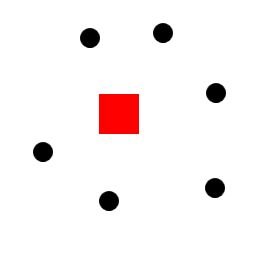


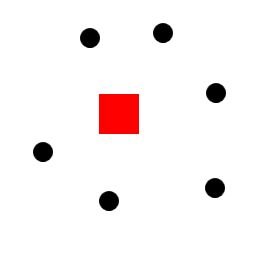

In [ ]:
#@title Main
SY =  256#@param {type:"integer"}
SX =  256#@param {type:"integer"}
# timesteps =  200#@param {type:"integer"}
mode = "draw" #@param ["draw", "random"]
modeb = "none" #@param ["growth", "sum", "none", "both"]
borders = False #@param {type:"boolean"}
creature= "crea1"  #@param ["crea1","crea2","crea3"]
main(SX,SY,mode,borders,[0,1,2,3,4,5,6,7,8,9],creaFile=creature+".pickle",modeb=modeb,zoom=1)

# Run the method to learn the rules leading to emergent robust creatures.


In this section you can run the method from the blogpost.

If you want to try to find new creatures, don't run the seed cell below.
 There is no certainty to find perfect creature, you may find creatures that don't have individuality in the multi creature setting or even some might die from specific collision with walls.

If you didn't run the seed cell, there is no certainty to find perfect creature, you may find creatures that don't have individuality in the multi creature setting or even some might die from specific collision with walls. Thus you may have to run this part few times before getting a very robust creature.



##seed



In [ ]:
torch.manual_seed(3)

## IMGEP code

### output representation

In [ ]:
class OutputRepresentation:
    """ Base class to map the observations of a system to an embedding vector (BC characterization)
    """

    @staticmethod
    def default_config():
        default_config = Dict()
        return default_config

    def __init__(self, config={}, **kwargs):
        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)

    def calc(self, observations, **kwargs):
        """ Maps the observations of a behavioral descriptor
            Args:
                observations (Dict): observations received after one environment run
            Returns
                embeddings (Dict): generally vector but we might need Dict structures, for instance for IMGEP-HOLMES
        """
        raise NotImplementedError

    def calc_distance(self, embedding_a, embedding_b, **kwargs):
        """ Compute the distance between 2 embedding
        """
        raise NotImplementedError


In [ ]:
class LeniaCentroidRepresentation(OutputRepresentation):

    @staticmethod
    def default_config():
        default_config = OutputRepresentation.default_config()
        default_config.env_size = (256, 256)
        default_config.distance_function = "L2"
        return default_config

    def __init__(self, config=None, **kwargs):
        super().__init__(config=config, **kwargs)
        self.n_latents = 3


    def calc(self, observations):
        """
            Maps the observations of a system to an embedding vector
            Return a torch tensor
        """

        # filter low values
        filtered_im =observations.states[-1,:,:,0]

        # recenter
        mu_0 = filtered_im.sum()

        # implementation of meshgrid in torch
        x = torch.arange(self.config.env_size[0])
        y = torch.arange(self.config.env_size[1])
        yy = y.repeat(self.config.env_size[0], 1)
        xx = x.view(-1, 1).repeat(1, self.config.env_size[1])

        X = (xx - int(self.config.env_size[0] / 2)).double()
        Y = (yy - int(self.config.env_size[1] / 2)).double()

        centroid_x = ((X * filtered_im).sum() / (mu_0+1e-10))
        centroid_y = ((Y * filtered_im).sum() / (mu_0+1e-10))
        X = (xx -centroid_x-self.config.env_size[0] / 2).double()
        Y = (yy - centroid_y-self.config.env_size[1] / 2).double()

        # distance to center in normalized space
        D = torch.sqrt(X ** 2 + Y ** 2)/ (35)

        mask=0.85*(D<0.5).float()+0.15*(D<1).float()
        loss=(filtered_im-0.9*mask).pow(2).sum().sqrt()

        embedding = torch.zeros(3)
        embedding[0]=loss/230
        embedding[1]=centroid_x.mean()/self.config.env_size[0]
        embedding[2]=centroid_y.mean()/self.config.env_size[1]
        if(mu_0<1e-4):
          embedding[1]=embedding[1]-10
          embedding[2]=embedding[2]-10


        # print(embedding)



        return embedding





    def calc_distance(self, embedding_a, embedding_b):
        """
            Compute the distance between 2 embeddings in the latent space
            /!\ batch mode embedding_a and embedding_b can be N*M or M
        """
        # l2 loss
        if self.config.distance_function == "L2":
            dist = (embedding_a - embedding_b).pow(2).sum(-1).sqrt()

        else:
            raise NotImplementedError

        return dist

### IMGEP def

In [ ]:
class Explorer:
    """
    Base class for exploration experiments.
    Allows to save and load exploration results
    """

    @staticmethod
    def default_config():
        default_config = Dict()
        return default_config

    def __init__(self, system, explorationdb, config={}, **kwargs):
        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)

        self.system = system
        self.db = explorationdb

    def save(self, filepath):
        """
        Saves the explorer object using torch.save function in pickle format
        /!\ We intentionally empty explorer.db from the pickle
        because the database is already automatically saved in external files each time the explorer call self.db.add_run_data
        """
        # do not pickle the data as already saved in extra files
        tmp_data = self.db
        self.db.reset_empty_db()

        # pickle exploration object
        torch.save(self, filepath)

        # attach db again to the exploration object
        self.db = tmp_data

    @staticmethod
    def load(explorer_filepath, load_data=True, run_ids=None, map_location='cuda'):

        explorer = torch.load(explorer_filepath, map_location=map_location)

        # loop over policy parameters to coalesce sparse tensors (not coalesced by default)
        def coalesce_parameter_dict(d, has_coalesced_tensor=False):
            for k, v in d.items():
                if isinstance(v, Dict):
                    d[k], has_coalesced_tensor = coalesce_parameter_dict(v, has_coalesced_tensor=has_coalesced_tensor)
                elif isinstance(v, torch.Tensor) and v.is_sparse and not v.is_coalesced():
                    d[k] = v.coalesce()
                    has_coalesced_tensor = True
            return d, has_coalesced_tensor

        for policy_idx, policy in enumerate(explorer.policy_library):
            explorer.policy_library[policy_idx], has_coalesced_tensor = coalesce_parameter_dict(policy)
            if not has_coalesced_tensor:
                break

        if load_data:
            explorer.db = ExplorationDB(config=explorer.db.config)
            explorer.db.load(run_ids=run_ids, map_location=map_location)

        return explorer

In [ ]:


class IMGEPExplorer(Explorer):
    """
    Basic explorer that samples goals in a goalspace and uses a policy library to generate parameters to reach the goal.
    """

    # Set these in ALL subclasses
    goal_space = None  # defines the obs->goal representation and the goal sampling strategy (self.goal_space.sample())
    reach_goal_optimizer = None

    @staticmethod
    def default_config():
        default_config = Dict()
        # base config
        default_config.num_of_random_initialization = 40  # number of random runs at the beginning of exploration to populate the IMGEP memory

        # Pi: source policy parameters config
        default_config.source_policy_selection = Dict()
        default_config.source_policy_selection.type = 'optimal'  # either: 'optimal', 'random'

        # Opt: Optimizer to reach goal
        default_config.reach_goal_optimizer = Dict()
        default_config.reach_goal_optimizer.optim_steps = 10
        default_config.reach_goal_optimizer.name = "SGD"
        default_config.reach_goal_optimizer.initialization_cppn.parameters.lr =  1e-3
        default_config.reach_goal_optimizer.lenia_step.parameters.lr = 1e-4
        # default_config.reach_goal_optimizer.parameters.eps=1e-4

        return default_config

    def __init__(self, system, explorationdb, goal_space, config={}, **kwargs):
        super().__init__(system=system, explorationdb=explorationdb, config=config, **kwargs)

        self.goal_space = goal_space

        # initialize policy library
        self.policy_library = []

        # initialize goal library
        self.goal_library = torch.empty((0,) + self.goal_space.shape)

        # reach goal optimizer
        self.reach_goal_optimizer = None

    def get_source_policy_idx(self, target_goal):

        if self.config.source_policy_selection.type == 'optimal':
            # get distance to other goals
            tbis=self.goal_library*1.0
            #augment distance to creature that exploded or died because we don't want to select them.
            tbis[:,1]=tbis[:,1]+(tbis[:,1]<-9).float()*100
            tbis[:,1]=tbis[:,1]+(tbis[:,0]>0.11).float()*100
            goal_distances = self.goal_space.calc_distance(target_goal.unsqueeze(0), tbis)
            source_policy_idx = torch.argmin(goal_distances)

        elif self.config.source_policy_selection.type == 'random':
            source_policy_idx = sample_value(('discrete', 0, len(self.goal_library) - 1))

        else:
            raise ValueError('Unknown source policy selection type {!r} in the configuration!'.format(
                self.config.source_policy_selection.type))

        return source_policy_idx

    def sample__interesting_goal(self):
      """ Sample a target goal randomly but taking into account the goal already reached in order to not sample an area to close from an already reached zone or too far from what can be reached """
      # arbitrary sampling of goal, some other may be more efficient
      close =0
      veryclose=10
      compt=0

      #change distance for reached goal when the creature died or exploded
      tbis=self.goal_library*1.0
      tbis[:,2]=tbis[:,2]+(tbis[:,1]<-9).float()*100
      tbis[:,2]=tbis[:,2]+(tbis[:,0]>0.11).float()*100



      # loop until region not explored too much and also not too far
      target_goal=torch.ones(3)*-10
      while close<1 or veryclose>2:
        target_goal[0]=0.065+torch.normal(torch.zeros(1))*0.002
        if(torch.rand(1)<0.2):
          #go a little further than previous best
          ind=torch.argmin(tbis[:,2])
          target_goal[1]=tbis[ind,1]+(torch.rand(1)*0.45-0.22)/4
          target_goal[2]=tbis[ind,2]-0.04*torch.rand(1)-0.02

        else:
          # with high probability try far points
            if(torch.rand(1)<0.7):
              target_goal[2]=torch.rand(1)*0.2-0.35
              target_goal[1]=-(torch.rand(1)*0.45-0.22)
            else:
              target_goal[2]=torch.rand(1)*0.35-0.35
              target_goal[1]=-(torch.rand(1)*0.45-0.22)

        goal_distances = self.goal_space.calc_distance(target_goal.unsqueeze(0), tbis)
        close=(goal_distances<0.1).float().sum()
        veryclose=(goal_distances<0.06).float().sum()
        compt=compt+1
      return(target_goal)






    def run(self, n_exploration_runs, continue_existing_run=False):

      again =True
      #while loop that sample new initialization and try until a good run is achieved,
      #the run will start from a new initialization in some cases like not enough progress in a certain number of steps etc
      while again :
        print('NEW TRY OF INIT')


        print('Exploration: ')
        progress_bar = tqdm(total=n_exploration_runs)
        if continue_existing_run:
            run_idx = len(self.policy_library)
            progress_bar.update(run_idx)
        else:
            self.policy_library = []
            self.goal_library = torch.empty((0,) + self.goal_space.shape)
            run_idx = 0
        nb_alive_random=0

        ############# Beginning of the search ##############
        while run_idx < n_exploration_runs:
            policy_parameters = Dict.fromkeys(
                ['initialization', 'update_rule'])  # policy parameters (output of IMGEP policy)






            ############ Initial Random Sampling of Parameters ####################
            if len(self.policy_library) < self.config.num_of_random_initialization:

                target_goal = None
                source_policy_idx = None
                reached_goal=torch.ones(19)

                # sample new parameters to test
                policy_parameters['initialization'] = self.system.initialization_space.sample()
                policy_parameters['update_rule'] = self.system.update_rule_space.sample()
                #divide h by 3 at the beginning as some unbalanced kernels can easily kill
                policy_parameters['update_rule'].h =policy_parameters['update_rule'].h/3
                self.system.reset(initialization_parameters=policy_parameters['initialization'],
                update_rule_parameters=policy_parameters['update_rule'])

                #run the system
                with torch.no_grad():
                    self.system.random_obstacle(8)
                    self.system.generate_init_state()
                    observations = self.system.run()
                    reached_goal = self.goal_space.map(observations)
                is_dead = reached_goal[0]>0.9 or reached_goal[1]<-0.5
                if not is_dead:
                    nb_alive_random=nb_alive_random+1

                optim_step_idx = 0
                dist_to_target = None






            ############## Goal-directed Sampling of Parameters ######################
            else:


                # sample a goal space from the goal space

                # for the first 8 target goal simply try to go as far as possible straight (each time goal a little bit further)
                if(len(self.policy_library)-self.config.num_of_random_initialization<8):
                  target_goal=torch.ones(3)*-10
                  target_goal[0]=0.065
                  target_goal[2]=0.19-(len(self.policy_library)-self.config.num_of_random_initialization)*0.06
                  target_goal[1]=0
                # then random goal in a region not reached but not too far
                else:
                  target_goal=self.sample__interesting_goal()




                if(len(self.policy_library)-self.config.num_of_random_initialization>=2):
                  print(f'Run {run_idx}, optimisation toward goal: ')
                  print("TARGET ="+str(target_goal))


                # get source policy for this target goal
                source_policy_idx = self.get_source_policy_idx(target_goal)
                source_policy = self.policy_library[source_policy_idx]


                # if we're at the beginning or iteration%5==0 then don't mutate and train for longer
                if(len(self.policy_library)-self.config.num_of_random_initialization<8 or len(self.policy_library)%5==0 ):

                  policy_parameters['initialization'] = deepcopy(source_policy['initialization'])
                  policy_parameters['update_rule'] = deepcopy(source_policy['update_rule'])
                  self.system.reset(initialization_parameters=policy_parameters['initialization'],
                                    update_rule_parameters=policy_parameters['update_rule'])
                  ite=self.config.reach_goal_optimizer.optim_steps
                # else mutate
                else:
                  ite=15
                  # mutate until finding a non dying and non exploding creature
                  die_mutate=True
                  while die_mutate:
                    policy_parameters['initialization'] = self.system.initialization_space.mutate(source_policy['initialization'])
                    policy_parameters['update_rule'] = self.system.update_rule_space.mutate(source_policy['update_rule'])
                    self.system.reset(initialization_parameters=policy_parameters['initialization'],
                                      update_rule_parameters=policy_parameters['update_rule'])
                    with torch.no_grad():
                      self.system.generate_init_state()
                      observations = self.system.run()
                      reached_goal = self.goal_space.map(observations)
                    # if doesn't not die or explode break the loop
                    if observations.states[-1,:,:,0].sum()>10 or reached_goal[0]>0.11:
                      die_mutate=False


                ##### INNER LOOP (Optimization part toward target goal ) ####
                if isinstance(self.system, torch.nn.Module) and self.config.reach_goal_optimizer.optim_steps > 0:


                    optimizer_class = eval(f'torch.optim.{self.config.reach_goal_optimizer.name}')
                    self.reach_goal_optimizer = optimizer_class([{'params': self.system.initialization.parameters(), **self.config.reach_goal_optimizer.initialization_cppn.parameters},
                                                                {'params': self.system.lenia_step.parameters(), **self.config.reach_goal_optimizer.lenia_step.parameters}],
                                                                **self.config.reach_goal_optimizer.parameters)

                    last_dead=False
                    for optim_step_idx in range(1, ite):

                        # run system with IMGEP's policy parameters
                        self.system.random_obstacle(8)
                        self.system.generate_init_state()
                        observations = self.system.run()
                        reached_goal = self.goal_space.map(observations)

                        ### Define  target disk
                        x = torch.arange(self.system.config.SX)
                        y = torch.arange(self.system.config.SY)
                        xx = x.view(-1, 1).repeat(1, self.system.config.SY)
                        yy = y.repeat(self.system.config.SX, 1)
                        X = (xx -(target_goal[1]+0.5)*self.system.config.SX).float() / (35)
                        Y = (yy - (target_goal[2]+0.5)*self.system.config.SY).float() / (35)
                        # distance to center in normalized space
                        D = torch.sqrt(X ** 2 + Y ** 2)
                        # mask is the target circles
                        mask=0.85*(D<0.5).float()+0.15*(D<1).float()



                        loss= (0.9*mask-observations.states[-1,:,:,0]).pow(2).sum().sqrt()

                        # optimisation step
                        self.reach_goal_optimizer.zero_grad()
                        loss.backward()
                        self.reach_goal_optimizer.step()



                        #compute again the kernels for the next step because parameters have been changed with the optimization
                        self.system.lenia_step.compute_kernel()


                        dead=observations.states[-1,:,:,0].sum()<10
                        if(dead and last_dead):
                          self.reach_goal_optimizer.zero_grad()
                          break
                        last_dead=dead

                    ###### END of INNER loop #####


                    # if not enough improvement at the first outer loop (just after random explo) then try another init
                    if(len(self.policy_library) >= self.config.num_of_random_initialization and len(self.policy_library)-self.config.num_of_random_initialization<2 ):
                      if(loss>19.5):
                        break
                      else:
                        if(len(self.policy_library)-self.config.num_of_random_initialization==2):
                          again=False

                    # gather back the trained parameters
                    self.system.update_initialization_parameters()
                    self.system.update_update_rule_parameters()
                    policy_parameters['initialization'] = self.system.initialization_parameters
                    policy_parameters['update_rule'] = self.system.update_rule_parameters
                    dist_to_target = loss.item()




                ## look at the reached goal ##
                reached_goal=torch.zeros(3).cpu()
                with torch.no_grad():
                  for i in range(20):
                    self.system.random_obstacle(8)
                    self.system.generate_init_state()
                    observations = self.system.run()
                    if(observations.states[-1,:,:,0].sum()<10):
                      reached_goal[0]=10
                      break
                    reached_goal = reached_goal+self.goal_space.map(observations).cpu()/20
                if(len(self.policy_library)-self.config.num_of_random_initialization>=2):
                  print("reached= "+str(reached_goal))





            # save results
            reached_goal=reached_goal.cpu()
            self.db.add_run_data(id=run_idx,
                                 policy_parameters=policy_parameters,
                                 observations=observations,
                                 source_policy_idx=source_policy_idx,
                                 target_goal=target_goal,
                                 reached_goal=reached_goal,
                                 n_optim_steps_to_reach_goal=optim_step_idx,
                                 dist_to_target=dist_to_target)

            # add policy and reached goal into the libraries
            # do it after the run data is saved to not save them if there is an error during the saving


            self.policy_library.append(policy_parameters)
            self.goal_library = torch.cat([self.goal_library, reached_goal.reshape(1, -1).to(self.goal_library.device).detach()])
            if len(self.policy_library) >= self.config.num_of_random_initialization:
              plt.imshow(self.system.init_wall.cpu())
              plt.scatter(((self.goal_library[:,0]<0.11).float()*(self.goal_library[:,2]>-0.5).float()*(self.goal_library[:,2]+0.5)*self.system.config.SY).cpu(),((self.goal_library[:,0]<0.11).float()*(self.goal_library[:,1]>-0.5).float()*(self.goal_library[:,1]+0.5)*self.system.config.SX).cpu())
              plt.show()
            # increment run_idx


            run_idx += 1
            progress_bar.update(1)


            #after the random explo if not enough living crea (even static ones)
            if len(self.policy_library) == self.config.num_of_random_initialization:
                if(nb_alive_random<2):
                    break
                print(run_idx)

            if len(self.policy_library)==n_exploration_runs-1:
                again=False









## Run the method

NEW TRY OF INIT
Exploration: 


 24%|██▍       | 39/160 [00:05<00:13,  8.79it/s]

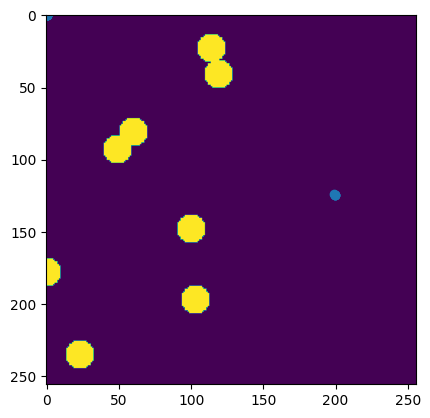

 25%|██▌       | 40/160 [00:05<00:28,  4.25it/s]

40


  warnings.warn('provided parameters are not in the space range and are therefore clamped')



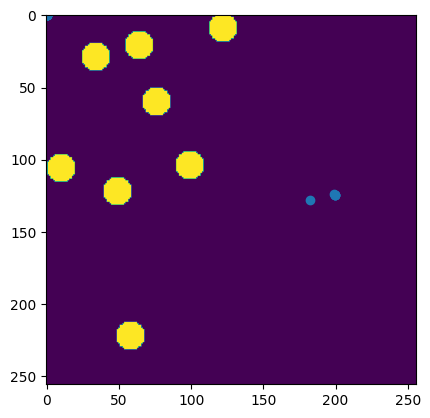

 26%|██▌       | 41/160 [00:40<21:09, 10.67s/it]

NEW TRY OF INIT
Exploration: 



  0%|          | 0/160 [00:00<?, ?it/s]WARNING:py.warnings:<ipython-input-12-55bd3ac50fbc>:59: UserWarning: /!\ id 0 already in the database: overwriting it with new run data !!!
  warnings.warn(f'/!\ id {id} already in the database: overwriting it with new run data !!!')

  warnings.warn(f'/!\ id {id} already in the database: overwriting it with new run data !!!')


  1%|▏         | 2/160 [00:00<00:14, 10.68it/s]WARNING:py.warnings:<ipython-input-12-55bd3ac50fbc>:59: UserWarning: /!\ id 2 already in the database: overwriting it with new run data !!!
  warnings.warn(f'/!\ id {id} already in the database: overwriting it with new run data !!!')

  warnings.warn(f'/!\ id {id} already in the database: overwriting it with new run data !!!')


  2%|▎         | 4/160 [00:00<00:14, 10.42it/s]WARNING:py.warnings:<ipython-input-12-55bd3ac50fbc>:59: UserWarning: /!\ id 4 already in the database: overwriting it with new run data !!!
  warnings.warn(f'/!\ id {id} already in the database: overwriti

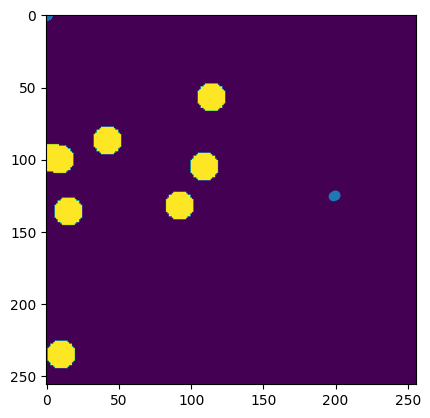


 26%|██▌       | 41/160 [01:18<03:48,  1.92s/it]


40
NEW TRY OF INIT
Exploration: 


 24%|██▍       | 38/160 [00:03<00:11, 10.67it/s]

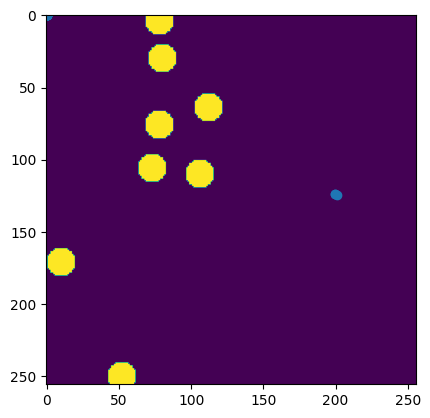

 25%|██▌       | 40/160 [00:09<00:27,  4.37it/s]


40
NEW TRY OF INIT
Exploration: 



 24%|██▍       | 39/160 [00:04<00:13,  8.64it/s]

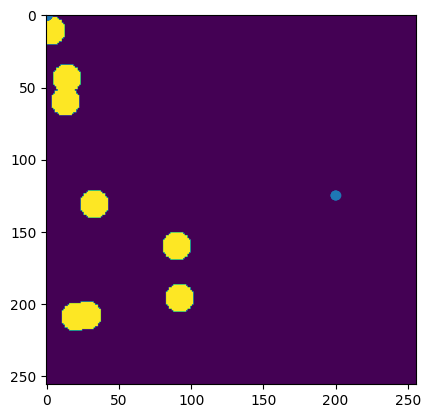


 25%|██▌       | 40/160 [00:42<02:06,  1.05s/it]


40
NEW TRY OF INIT
Exploration: 


 24%|██▍       | 39/160 [00:03<00:13,  9.14it/s]

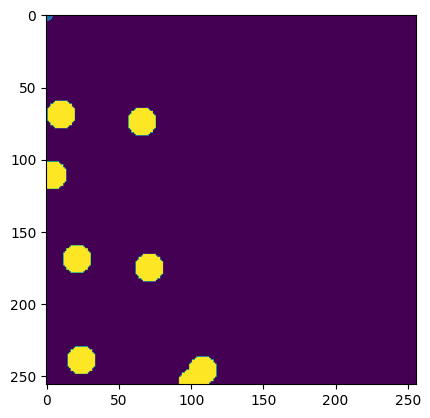

 25%|██▌       | 40/160 [00:42<02:06,  1.06s/it]


40
NEW TRY OF INIT
Exploration: 



 24%|██▍       | 38/160 [00:03<00:11, 10.53it/s]

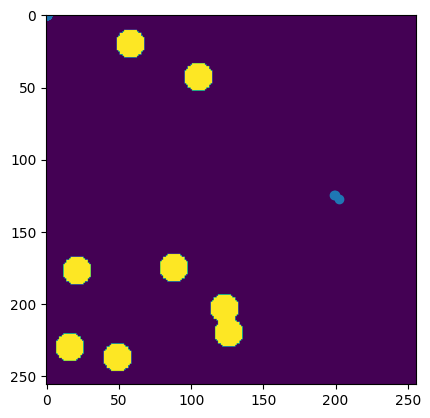


 25%|██▌       | 40/160 [00:12<00:36,  3.29it/s]


40
NEW TRY OF INIT
Exploration: 


 24%|██▍       | 38/160 [00:03<00:11, 10.69it/s]

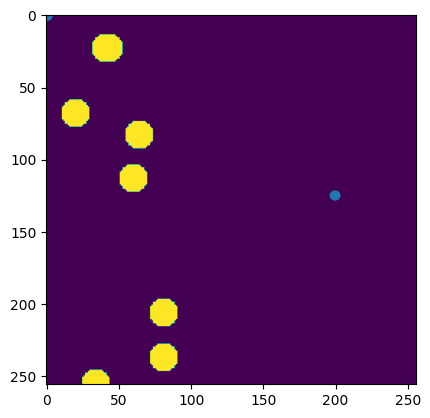

 25%|██▌       | 40/160 [00:41<02:04,  1.04s/it]


40


  warnings.warn('provided parameters are not in the space range and are therefore clamped')

  warnings.warn(f'/!\ id {id} already in the database: overwriting it with new run data !!!')



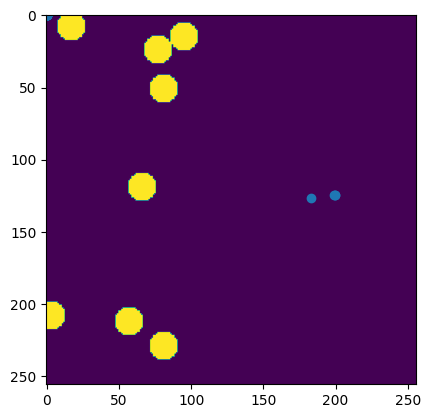

 26%|██▌       | 41/160 [00:39<12:35,  6.35s/it]

NEW TRY OF INIT
Exploration: 



 24%|██▍       | 39/160 [00:04<00:11, 10.41it/s]

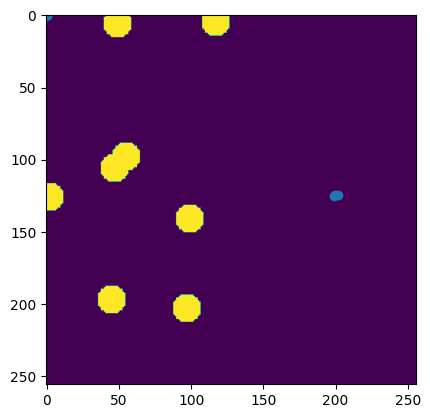

 26%|██▌       | 41/160 [01:17<03:44,  1.88s/it]

40


NEW TRY OF INIT
Exploration: 


 24%|██▍       | 38/160 [00:03<00:11, 10.85it/s]

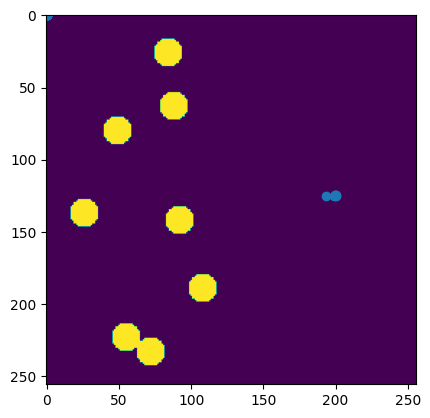

 25%|██▌       | 40/160 [00:09<00:27,  4.43it/s]


40
NEW TRY OF INIT
Exploration: 



 24%|██▍       | 39/160 [00:04<00:12,  9.88it/s]

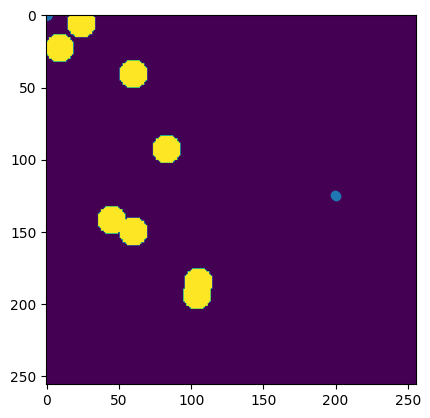


 25%|██▌       | 40/160 [00:11<00:34,  3.46it/s]


40
NEW TRY OF INIT
Exploration: 


 24%|██▍       | 38/160 [00:03<00:11, 10.86it/s]

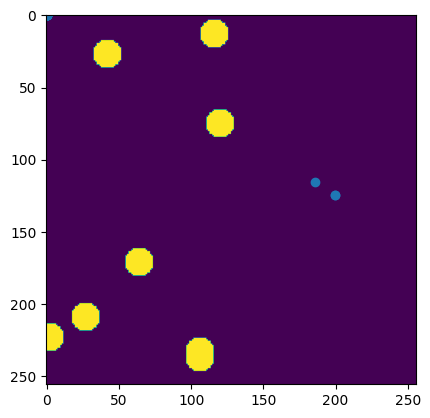

 25%|██▌       | 40/160 [00:09<00:28,  4.23it/s]


40


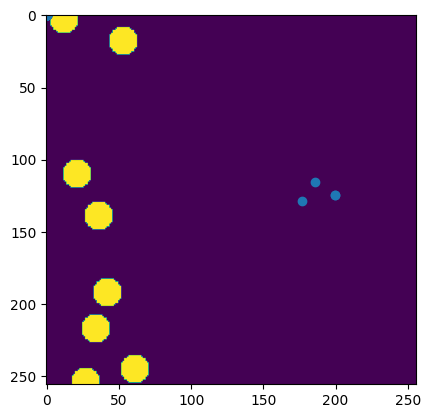

 26%|██▌       | 41/160 [00:39<12:36,  6.36s/it]

NEW TRY OF INIT
Exploration: 



 24%|██▍       | 39/160 [00:04<00:12,  9.74it/s]

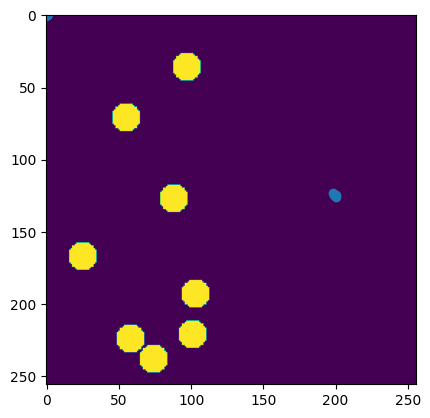


 26%|██▌       | 41/160 [01:17<03:45,  1.90s/it]


40
NEW TRY OF INIT
Exploration: 


 24%|██▍       | 38/160 [00:03<00:11, 10.80it/s]

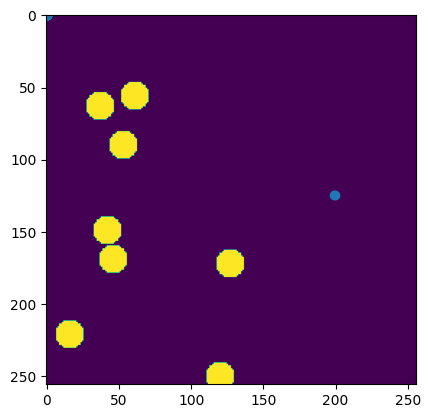

 25%|██▌       | 40/160 [00:09<00:28,  4.17it/s]


40


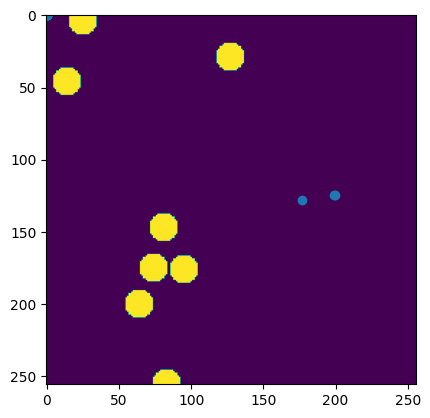

 26%|██▌       | 41/160 [00:39<12:39,  6.38s/it]

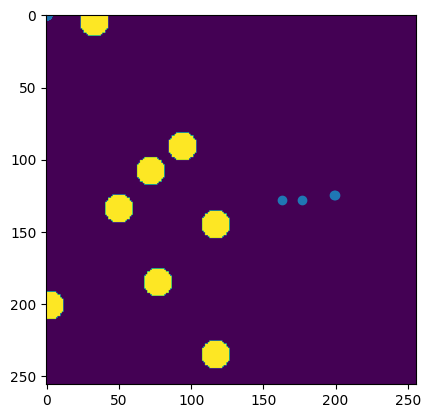

 26%|██▋       | 42/160 [01:15<24:06, 12.26s/it]

Run 42, optimisation toward goal: 
TARGET =tensor([0.0650, 0.0000, 0.0700])
reached= tensor([0.0461, 0.0003, 0.0680], device='cpu')


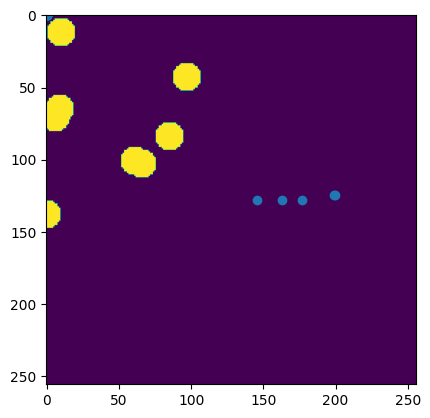

 27%|██▋       | 43/160 [01:50<34:02, 17.46s/it]

Run 43, optimisation toward goal: 
TARGET =tensor([0.0650, 0.0000, 0.0100])
reached= tensor([0.0518, 0.0003, 0.0106], device='cpu')


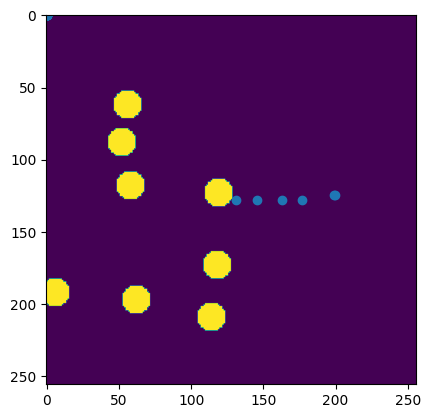

 28%|██▊       | 44/160 [02:25<42:02, 21.74s/it]

Run 44, optimisation toward goal: 
TARGET =tensor([ 0.0650,  0.0000, -0.0500])
reached= tensor([ 0.0638,  0.0023, -0.0326], device='cpu')


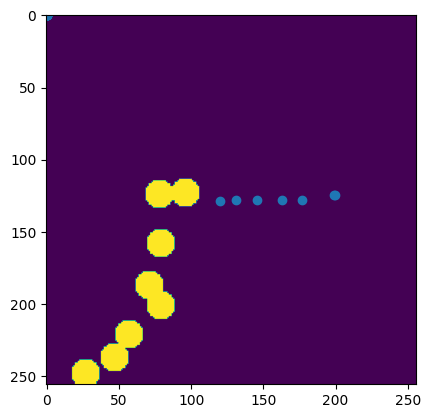

 28%|██▊       | 45/160 [03:01<48:37, 25.37s/it]

Run 45, optimisation toward goal: 
TARGET =tensor([ 0.0650,  0.0000, -0.1100])
reached= tensor([ 0.0686,  0.0092, -0.0704], device='cpu')


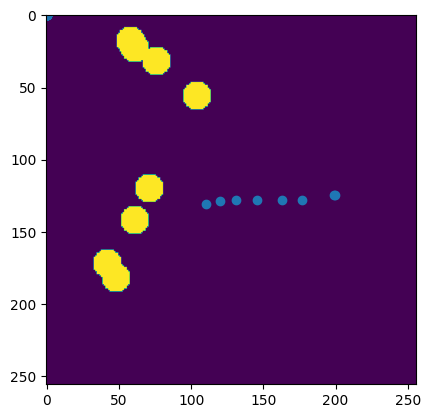

 29%|██▉       | 46/160 [03:37<53:28, 28.14s/it]

Run 46, optimisation toward goal: 
TARGET =tensor([ 0.0650,  0.0000, -0.1700])
reached= tensor([ 0.0694, -0.0067, -0.1266], device='cpu')


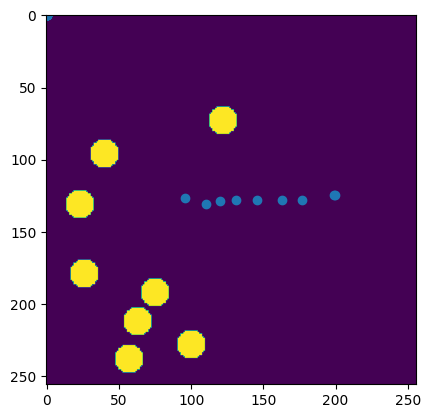

 29%|██▉       | 47/160 [04:13<56:59, 30.26s/it]

Run 47, optimisation toward goal: 
TARGET =tensor([ 0.0650,  0.0000, -0.2300])
reached= tensor([ 0.0697,  0.0242, -0.1763], device='cpu')


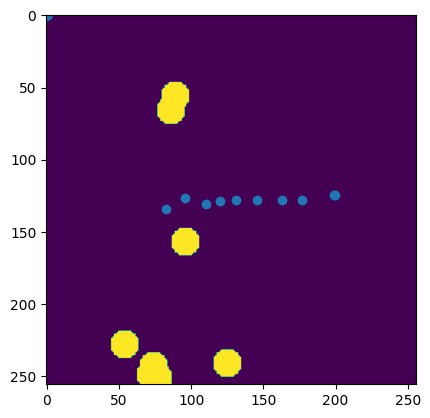

 30%|███       | 48/160 [04:48<59:09, 31.69s/it]

Run 48, optimisation toward goal: 
TARGET =tensor([ 0.0671,  0.0277, -0.2245])
reached= tensor([ 0.0729,  0.0064, -0.1427], device='cpu')


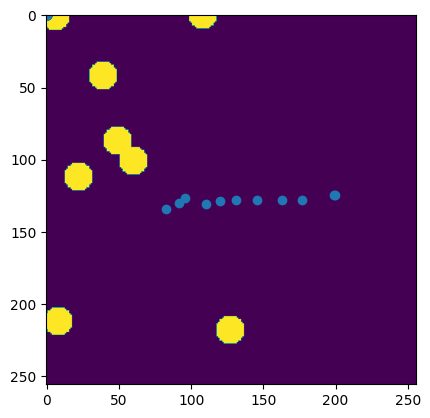

 31%|███       | 49/160 [04:54<44:44, 24.19s/it]

Run 49, optimisation toward goal: 
TARGET =tensor([ 0.0616,  0.0689, -0.2126])
reached= tensor([10.,  0.,  0.], device='cpu')


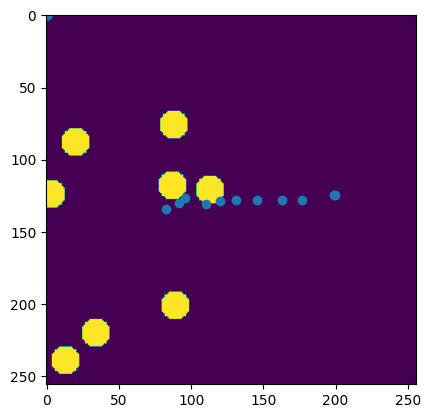

 31%|███▏      | 50/160 [04:55<32:02, 17.47s/it]

Run 50, optimisation toward goal: 
TARGET =tensor([ 0.0664,  0.0325, -0.2191])
reached= tensor([ 0.0712,  0.0257, -0.1886], device='cpu')


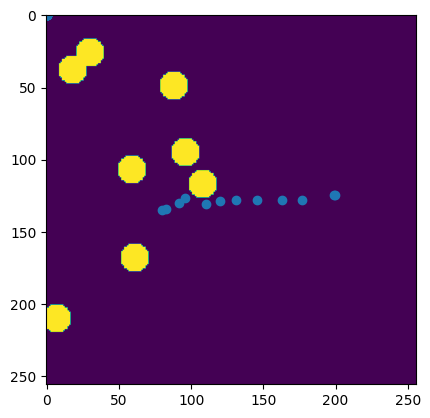

 32%|███▏      | 51/160 [05:30<41:23, 22.79s/it]

Run 51, optimisation toward goal: 
TARGET =tensor([ 0.0635, -0.0546, -0.2076])
reached= tensor([10.,  0.,  0.], device='cpu')


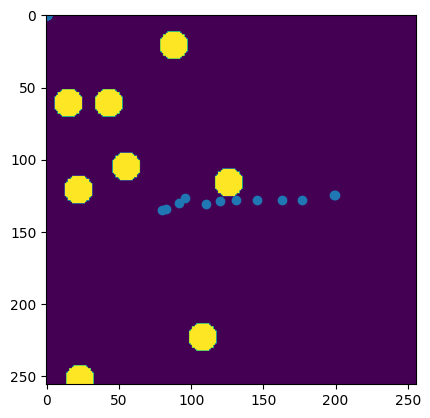

 32%|███▎      | 52/160 [05:31<29:20, 16.30s/it]

Run 52, optimisation toward goal: 
TARGET =tensor([ 0.0630, -0.0062, -0.2349])
reached= tensor([10.,  0.,  0.], device='cpu')


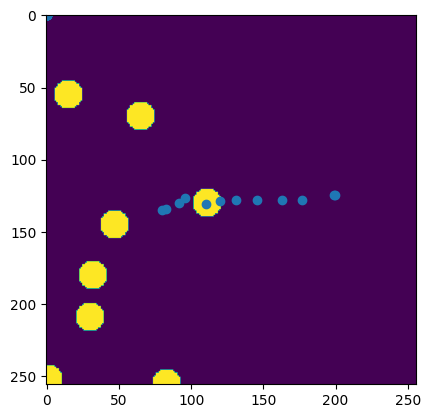

 33%|███▎      | 53/160 [05:32<20:54, 11.72s/it]

Run 53, optimisation toward goal: 
TARGET =tensor([ 0.0660,  0.0766, -0.2117])
reached= tensor([ 0.0761,  0.0610, -0.1463], device='cpu')


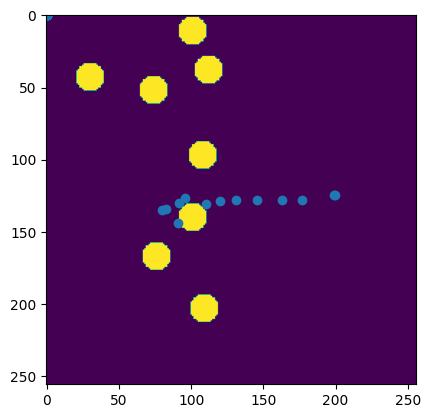

 34%|███▍      | 54/160 [05:37<17:24,  9.86s/it]

Run 54, optimisation toward goal: 
TARGET =tensor([ 0.0662,  0.0188, -0.2074])
reached= tensor([0.0685, 0.0803, 0.4033], device='cpu')


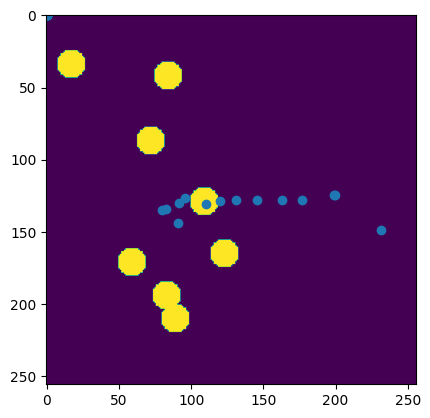

 34%|███▍      | 55/160 [05:43<15:10,  8.67s/it]

Run 55, optimisation toward goal: 
TARGET =tensor([ 0.0640,  0.1360, -0.2073])
reached= tensor([10.,  0.,  0.], device='cpu')


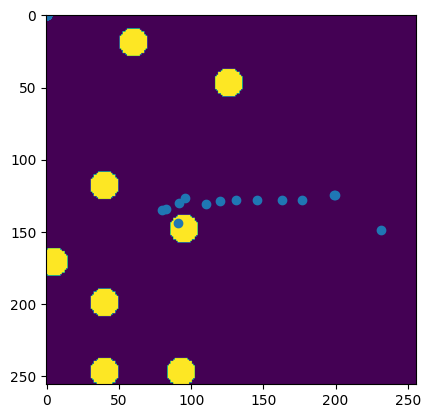

 35%|███▌      | 56/160 [05:59<18:38, 10.76s/it]

Run 56, optimisation toward goal: 
TARGET =tensor([ 0.0643,  0.0499, -0.2389])
reached= tensor([ 0.0727,  0.0465, -0.1457], device='cpu')


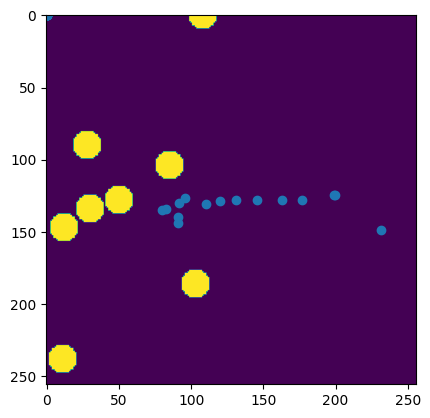

 36%|███▌      | 57/160 [06:05<15:51,  9.23s/it]

Run 57, optimisation toward goal: 
TARGET =tensor([ 0.0622, -0.0125, -0.2482])
reached= tensor([0.0949, 0.0135, 0.2333], device='cpu')


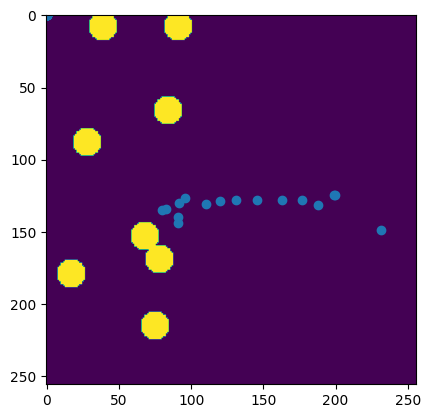

 36%|███▋      | 58/160 [06:10<13:52,  8.16s/it]

Run 58, optimisation toward goal: 
TARGET =tensor([ 0.0631,  0.0496, -0.2304])
reached= tensor([ 0.0745,  0.0084, -0.1180], device='cpu')


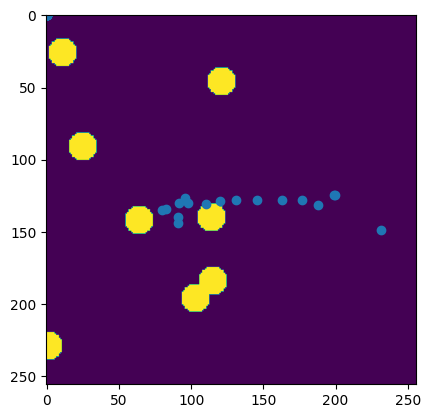

 37%|███▋      | 59/160 [06:16<12:27,  7.40s/it]

Run 59, optimisation toward goal: 
TARGET =tensor([ 0.0652,  0.0303, -0.2822])
reached= tensor([0.0814, 0.1997, 0.2578], device='cpu')


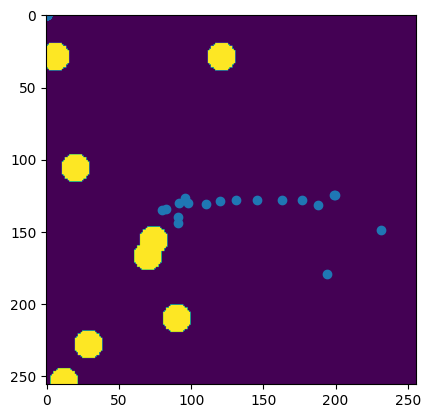

 38%|███▊      | 60/160 [06:22<11:35,  6.95s/it]

Run 60, optimisation toward goal: 
TARGET =tensor([ 0.0655,  0.0778, -0.1145])
reached= tensor([ 0.0712,  0.0816, -0.0852], device='cpu')


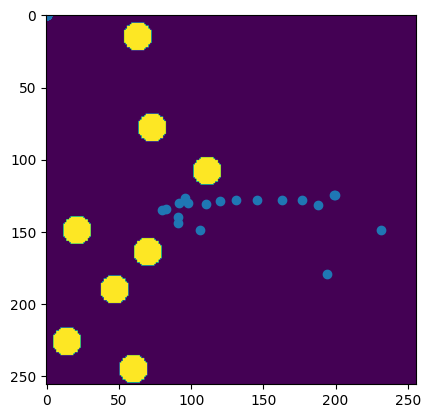

 38%|███▊      | 61/160 [06:57<25:35, 15.51s/it]

Run 61, optimisation toward goal: 
TARGET =tensor([ 0.0664,  0.0685, -0.2455])
reached= tensor([ 0.0842, -0.0728,  0.0633], device='cpu')


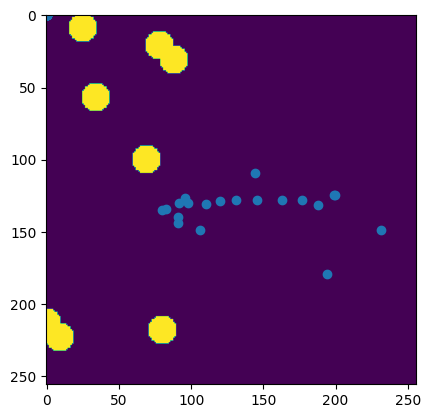

 39%|███▉      | 62/160 [07:03<20:25, 12.50s/it]

Run 62, optimisation toward goal: 
TARGET =tensor([ 0.0642,  0.0446, -0.2525])
reached= tensor([ 0.0781,  0.0260, -0.1792], device='cpu')


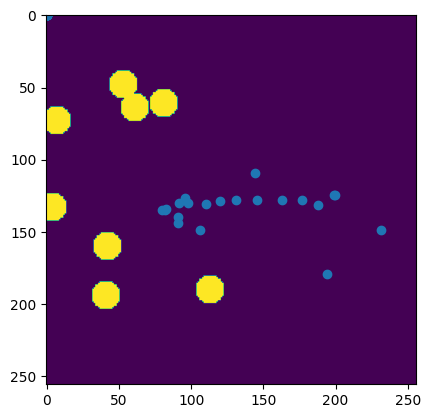

 39%|███▉      | 63/160 [07:08<16:52, 10.44s/it]

Run 63, optimisation toward goal: 
TARGET =tensor([ 0.0655,  0.1431, -0.1859])
reached= tensor([10.,  0.,  0.], device='cpu')


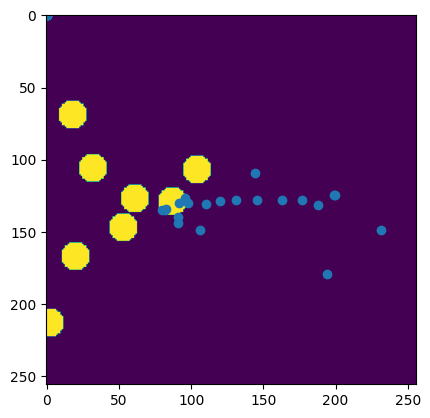

 40%|████      | 64/160 [07:10<12:38,  7.90s/it]

Run 64, optimisation toward goal: 
TARGET =tensor([ 0.0707,  0.0610, -0.0545])
reached= tensor([10.,  0.,  0.], device='cpu')


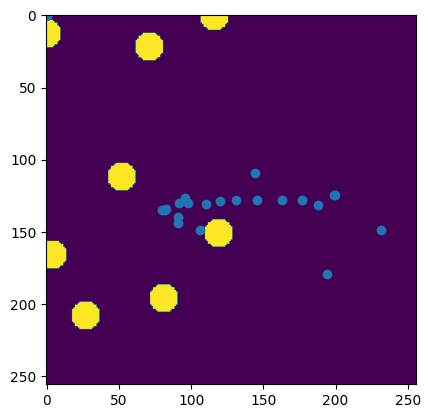

 41%|████      | 65/160 [07:11<09:10,  5.80s/it]

Run 65, optimisation toward goal: 
TARGET =tensor([ 0.0658,  0.0779, -0.2338])
reached= tensor([ 0.0739,  0.0720, -0.1657], device='cpu')


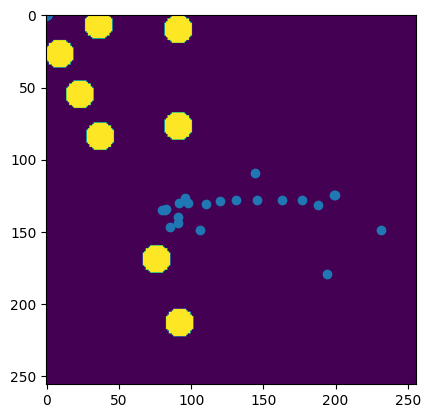

 41%|████▏     | 66/160 [07:47<22:53, 14.61s/it]

Run 66, optimisation toward goal: 
TARGET =tensor([ 0.0653, -0.0364, -0.1663])
reached= tensor([10.,  0.,  0.], device='cpu')


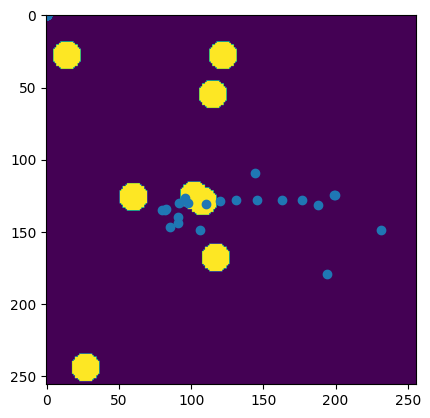

 42%|████▏     | 67/160 [07:49<16:47, 10.83s/it]

Run 67, optimisation toward goal: 
TARGET =tensor([ 0.0635,  0.0294, -0.2743])
reached= tensor([ 0.0903, -0.1124,  0.1433], device='cpu')


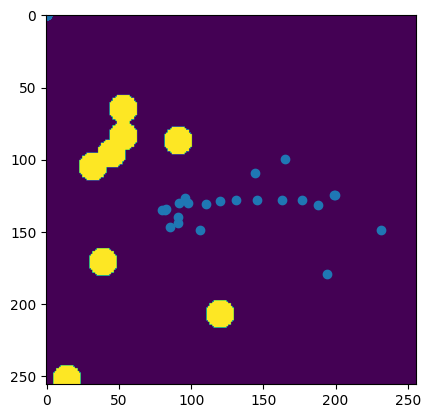

 42%|████▎     | 68/160 [07:54<14:10,  9.25s/it]

Run 68, optimisation toward goal: 
TARGET =tensor([ 0.0655,  0.0511, -0.2465])
reached= tensor([10.,  0.,  0.], device='cpu')


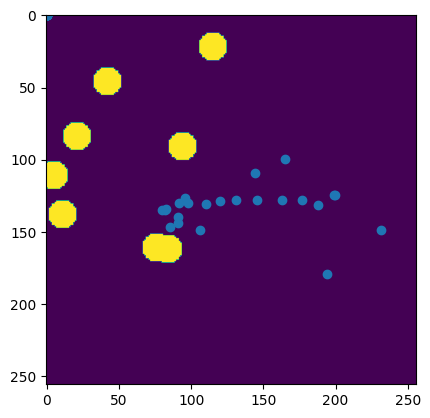

 43%|████▎     | 69/160 [07:57<10:56,  7.21s/it]

Run 69, optimisation toward goal: 
TARGET =tensor([ 0.0636,  0.0158, -0.2476])
reached= tensor([ 0.0753,  0.0178, -0.1710], device='cpu')


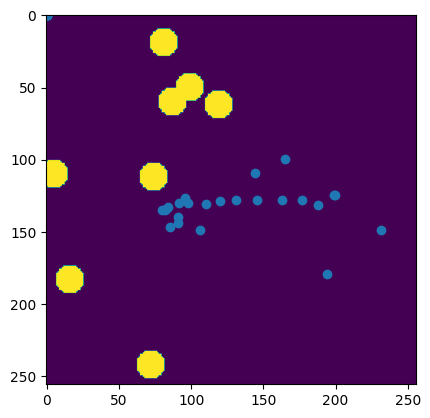

 44%|████▍     | 70/160 [08:02<10:12,  6.81s/it]

Run 70, optimisation toward goal: 
TARGET =tensor([ 0.0668, -0.0199, -0.2380])
reached= tensor([ 0.0709,  0.0194, -0.1924], device='cpu')


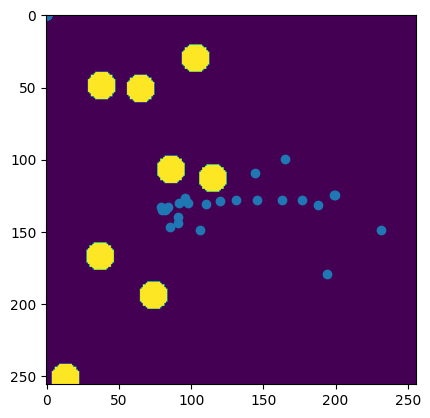

 44%|████▍     | 71/160 [08:38<22:46, 15.36s/it]

Run 71, optimisation toward goal: 
TARGET =tensor([ 0.0662,  0.1305, -0.1553])
reached= tensor([10.,  0.,  0.], device='cpu')


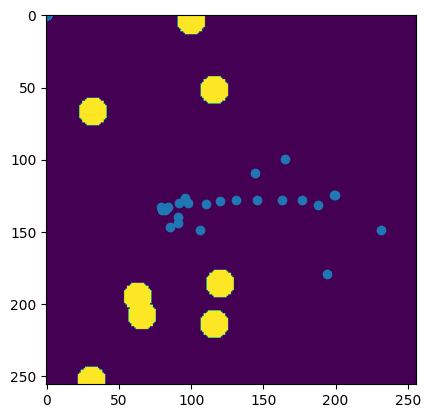

 45%|████▌     | 72/160 [08:42<17:35, 12.00s/it]

Run 72, optimisation toward goal: 
TARGET =tensor([ 0.0663,  0.0247, -0.2443])
reached= tensor([ 0.0717,  0.0005, -0.1969], device='cpu')


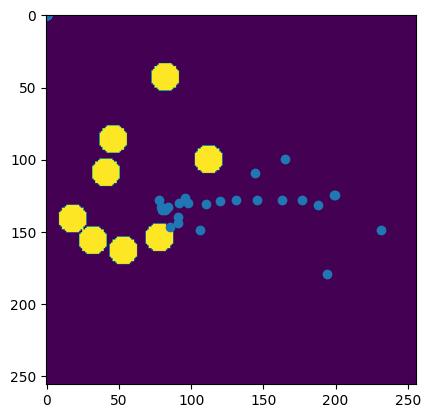

 46%|████▌     | 73/160 [08:47<14:34, 10.05s/it]

Run 73, optimisation toward goal: 
TARGET =tensor([ 0.0628,  0.0810, -0.0828])
reached= tensor([10.,  0.,  0.], device='cpu')


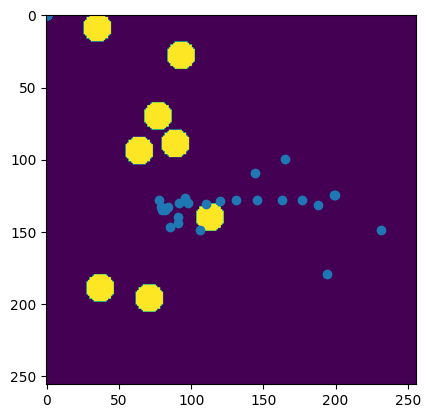

 46%|████▋     | 74/160 [08:49<10:34,  7.38s/it]

Run 74, optimisation toward goal: 
TARGET =tensor([ 0.0653, -0.0417, -0.2195])
reached= tensor([0.0825, 0.0813, 0.0769], device='cpu')


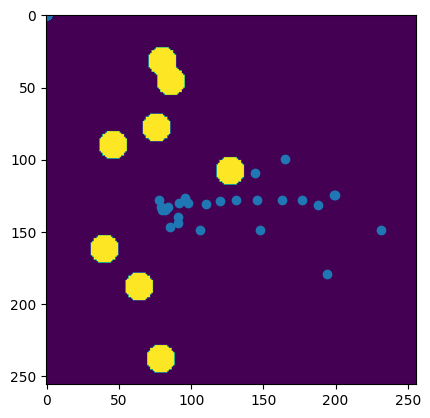

 47%|████▋     | 75/160 [08:54<09:47,  6.91s/it]

Run 75, optimisation toward goal: 
TARGET =tensor([ 0.0647, -0.0301, -0.2346])
reached= tensor([ 0.0714, -0.0434, -0.2018], device='cpu')


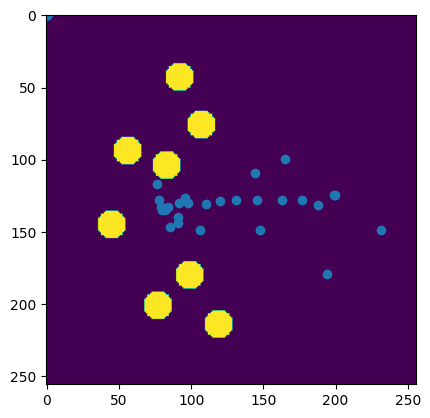

 48%|████▊     | 76/160 [09:30<21:37, 15.45s/it]

Run 76, optimisation toward goal: 
TARGET =tensor([ 0.0664, -0.0951, -0.2810])
reached= tensor([ 0.1011, -0.0071,  0.2407], device='cpu')


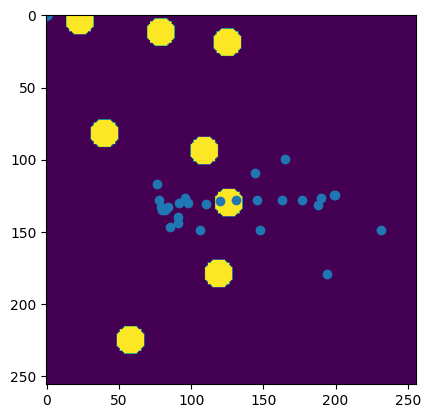

 48%|████▊     | 77/160 [09:35<17:20, 12.54s/it]

Run 77, optimisation toward goal: 
TARGET =tensor([ 0.0616, -0.0536, -0.2608])
reached= tensor([ 0.2166, -0.0316,  0.1054], device='cpu')


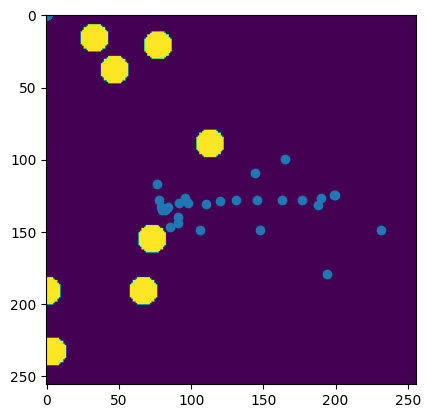

 49%|████▉     | 78/160 [09:41<14:14, 10.42s/it]

Run 78, optimisation toward goal: 
TARGET =tensor([ 0.0627, -0.0299, -0.2339])
reached= tensor([ 0.0844, -0.0416,  0.1315], device='cpu')


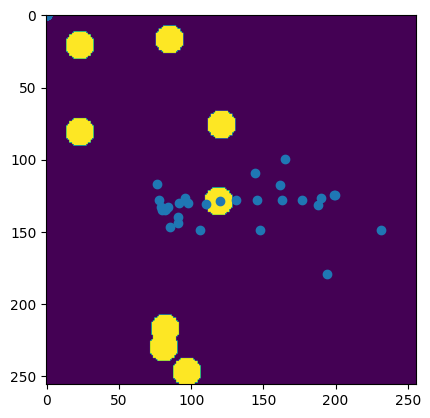

 49%|████▉     | 79/160 [09:47<12:13,  9.06s/it]

Run 79, optimisation toward goal: 
TARGET =tensor([ 0.0662,  0.0968, -0.1042])
reached= tensor([ 0.0700,  0.0910, -0.0957], device='cpu')


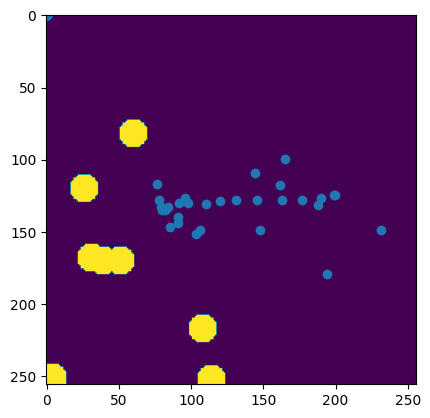

 50%|█████     | 80/160 [09:52<10:38,  7.99s/it]

Run 80, optimisation toward goal: 
TARGET =tensor([ 0.0603,  0.0591, -0.2309])
reached= tensor([10.,  0.,  0.], device='cpu')


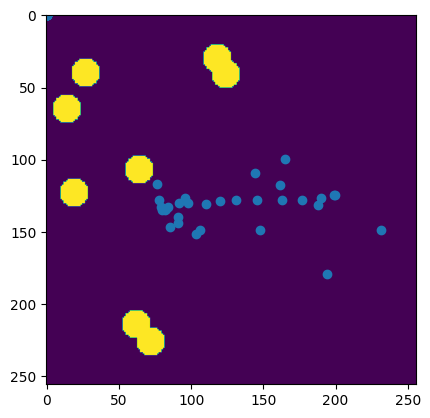

 51%|█████     | 81/160 [10:22<19:09, 14.55s/it]

Run 81, optimisation toward goal: 
TARGET =tensor([ 0.0658, -0.0752, -0.2312])
reached= tensor([10.,  0.,  0.], device='cpu')


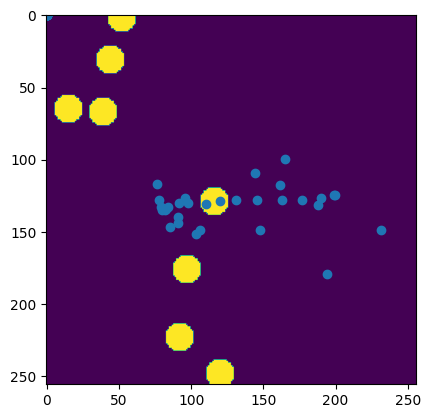

 51%|█████▏    | 82/160 [10:24<13:55, 10.72s/it]

Run 82, optimisation toward goal: 
TARGET =tensor([ 0.0633, -0.0130, -0.2569])
reached= tensor([10.,  0.,  0.], device='cpu')


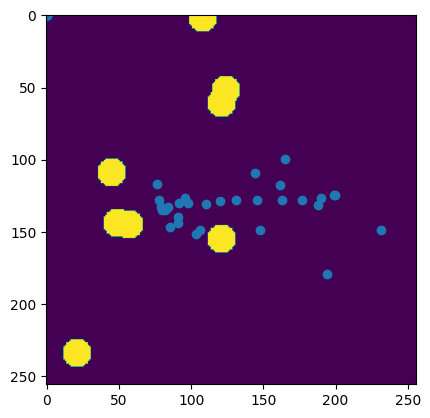

 52%|█████▏    | 83/160 [10:28<11:10,  8.71s/it]

Run 83, optimisation toward goal: 
TARGET =tensor([ 0.0633, -0.0669, -0.1565])
reached= tensor([ 0.0769, -0.0510, -0.0921], device='cpu')


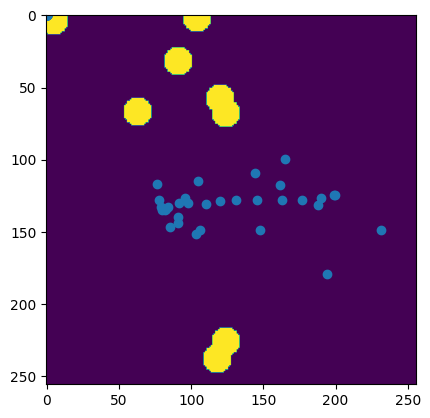

 52%|█████▎    | 84/160 [10:34<09:51,  7.79s/it]

Run 84, optimisation toward goal: 
TARGET =tensor([ 0.0638, -0.0347, -0.2503])
reached= tensor([ 0.0742, -0.0233, -0.1597], device='cpu')


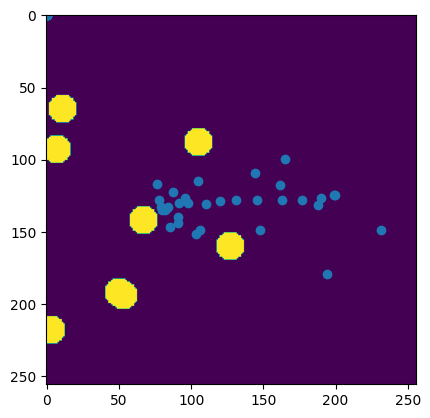

 53%|█████▎    | 85/160 [10:39<08:58,  7.18s/it]

Run 85, optimisation toward goal: 
TARGET =tensor([ 0.0662, -0.0758, -0.2472])
reached= tensor([ 0.0760, -0.0656, -0.1930], device='cpu')


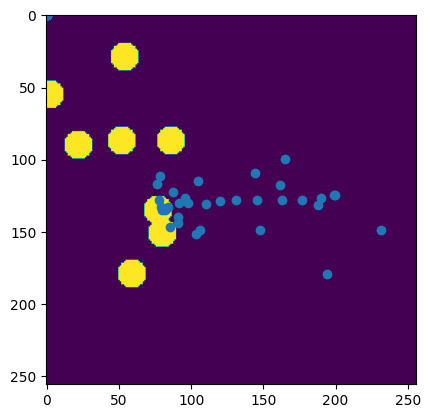

 54%|█████▍    | 86/160 [11:15<19:19, 15.66s/it]

Run 86, optimisation toward goal: 
TARGET =tensor([ 0.0626, -0.0813, -0.2068])
reached= tensor([10.,  0.,  0.], device='cpu')


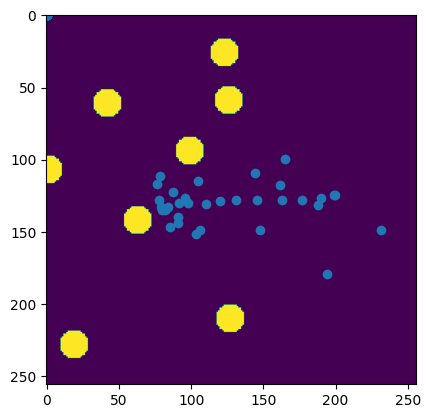

 54%|█████▍    | 87/160 [11:16<13:56, 11.46s/it]

Run 87, optimisation toward goal: 
TARGET =tensor([ 0.0682, -0.0818, -0.2234])
reached= tensor([ 0.0929, -0.0705, -0.1436], device='cpu')


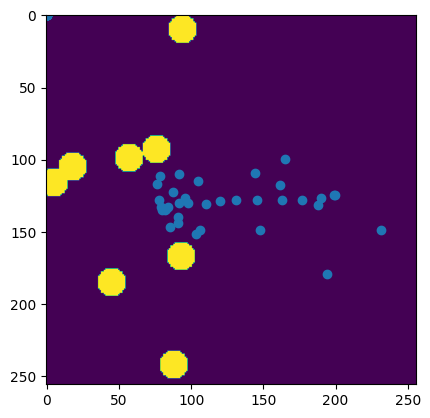

 55%|█████▌    | 88/160 [11:22<11:35,  9.67s/it]

Run 88, optimisation toward goal: 
TARGET =tensor([ 0.0643, -0.0516, -0.2536])
reached= tensor([10.,  0.,  0.], device='cpu')


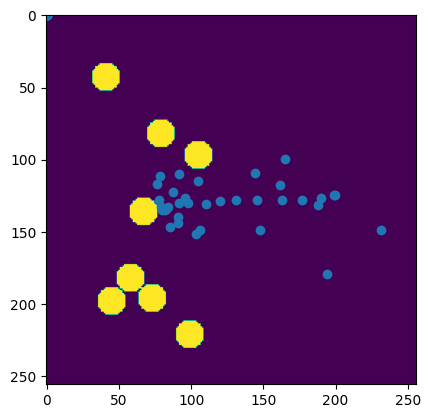

 56%|█████▌    | 89/160 [11:25<09:15,  7.82s/it]

Run 89, optimisation toward goal: 
TARGET =tensor([ 0.0644,  0.1033, -0.1938])
reached= tensor([ 0.0786,  0.0539, -0.0607], device='cpu')


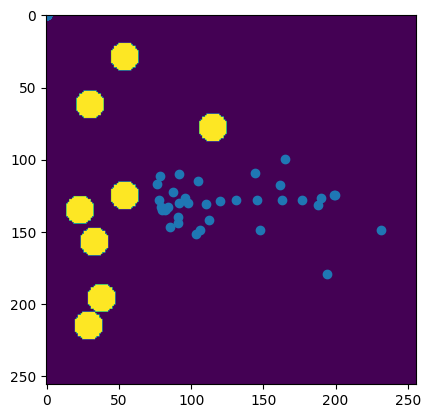

 56%|█████▋    | 90/160 [11:31<08:22,  7.18s/it]

Run 90, optimisation toward goal: 
TARGET =tensor([ 0.0641, -0.0087, -0.2529])
reached= tensor([ 0.0741, -0.0390, -0.1744], device='cpu')


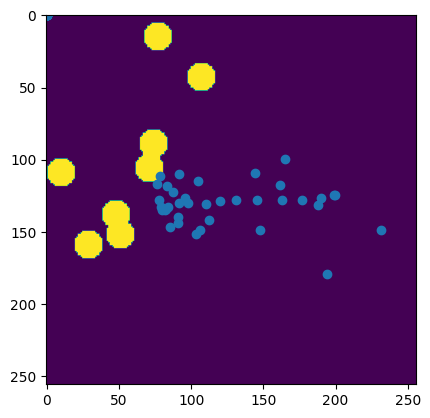

 57%|█████▋    | 91/160 [12:07<18:03, 15.71s/it]

Run 91, optimisation toward goal: 
TARGET =tensor([ 0.0659, -0.0568, -0.2411])
reached= tensor([ 0.0779, -0.0486,  0.1503], device='cpu')


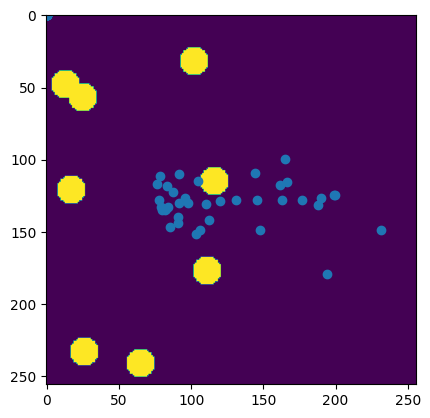

 57%|█████▊    | 92/160 [12:12<14:19, 12.64s/it]

Run 92, optimisation toward goal: 
TARGET =tensor([ 0.0653, -0.0609, -0.2558])
reached= tensor([ 0.2246, -0.0048,  0.0178], device='cpu')


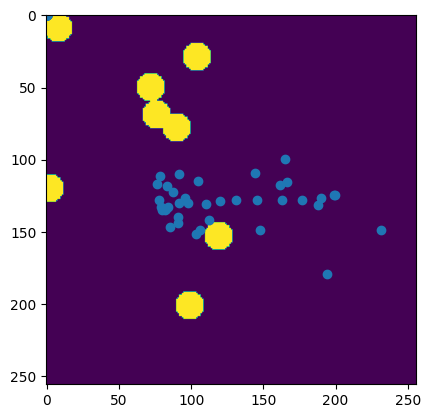

 58%|█████▊    | 93/160 [12:18<11:52, 10.63s/it]

Run 93, optimisation toward goal: 
TARGET =tensor([ 0.0666,  0.1582, -0.1892])
reached= tensor([ 0.0726,  0.1408, -0.1374], device='cpu')


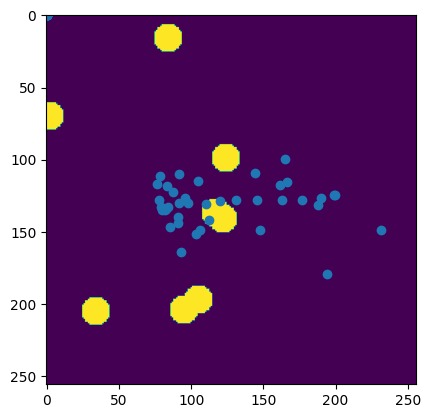

 59%|█████▉    | 94/160 [12:24<09:59,  9.08s/it]

Run 94, optimisation toward goal: 
TARGET =tensor([ 0.0658, -0.0421, -0.2456])
reached= tensor([ 0.0744, -0.0309, -0.1983], device='cpu')


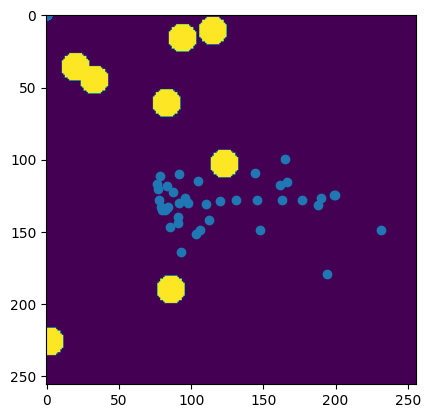

 59%|█████▉    | 95/160 [12:29<08:43,  8.06s/it]

Run 95, optimisation toward goal: 
TARGET =tensor([ 0.0652, -0.0076, -0.2542])
reached= tensor([ 0.0742,  0.0014, -0.1864], device='cpu')


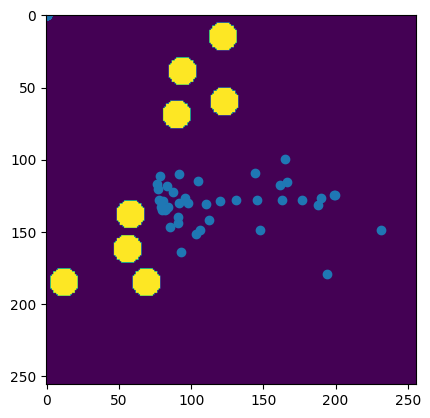

 60%|██████    | 96/160 [13:05<17:20, 16.26s/it]

Run 96, optimisation toward goal: 
TARGET =tensor([ 0.0655, -0.0250, -0.2516])
reached= tensor([ 0.0751, -0.0018,  0.2440], device='cpu')


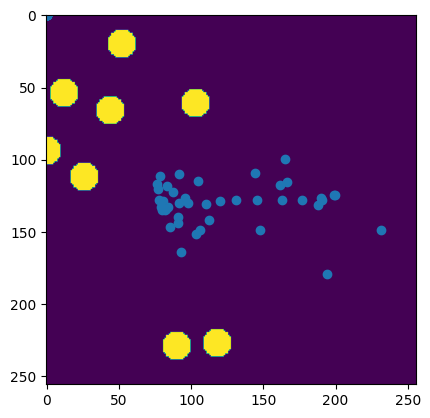

 61%|██████    | 97/160 [13:11<13:47, 13.13s/it]

Run 97, optimisation toward goal: 
TARGET =tensor([ 0.0664,  0.1943, -0.0758])
reached= tensor([ 0.0826, -0.0057,  0.3060], device='cpu')


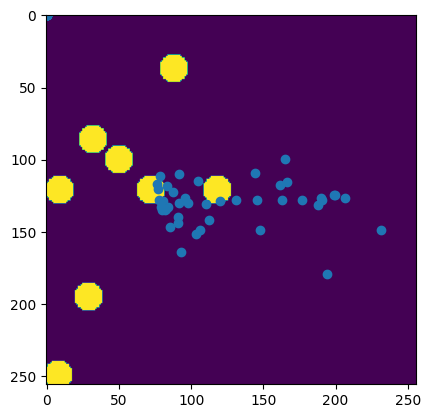

 61%|██████▏   | 98/160 [13:16<11:12, 10.84s/it]

Run 98, optimisation toward goal: 
TARGET =tensor([ 0.0644,  0.0101, -0.2665])
reached= tensor([ 0.0728,  0.0336, -0.1729], device='cpu')


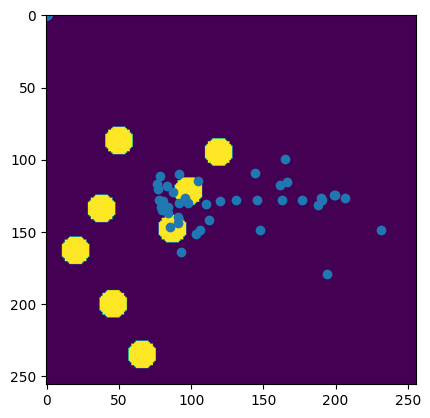

 62%|██████▏   | 99/160 [13:22<09:27,  9.30s/it]

Run 99, optimisation toward goal: 
TARGET =tensor([ 0.0629,  0.0962, -0.0047])
reached= tensor([0.0827, 0.0648, 0.1559], device='cpu')


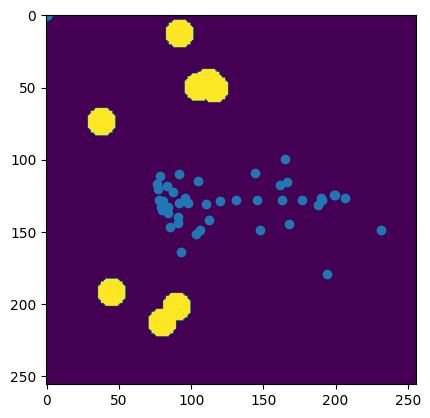

 62%|██████▎   | 100/160 [13:27<08:11,  8.19s/it]

Run 100, optimisation toward goal: 
TARGET =tensor([ 0.0635, -0.1194, -0.1777])
reached= tensor([ 0.0954, -0.0138,  0.1881], device='cpu')


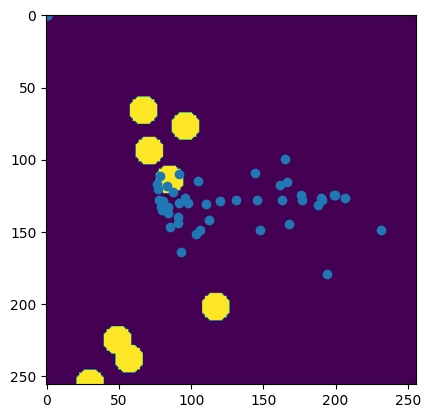

 63%|██████▎   | 101/160 [14:03<16:03, 16.34s/it]

Run 101, optimisation toward goal: 
TARGET =tensor([ 0.0704, -0.1429, -0.2053])
reached= tensor([ 0.0742, -0.1392, -0.1672], device='cpu')


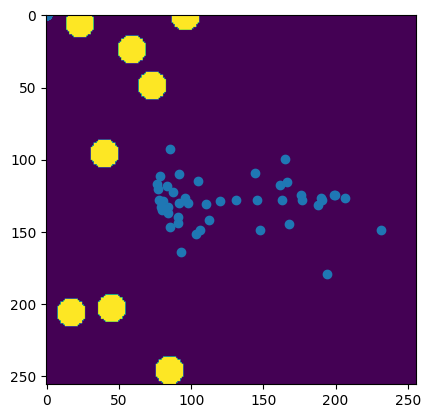

 64%|██████▍   | 102/160 [14:08<12:38, 13.08s/it]

Run 102, optimisation toward goal: 
TARGET =tensor([ 0.0694,  0.1116, -0.2512])
reached= tensor([0.0823, 0.1319, 0.1429], device='cpu')


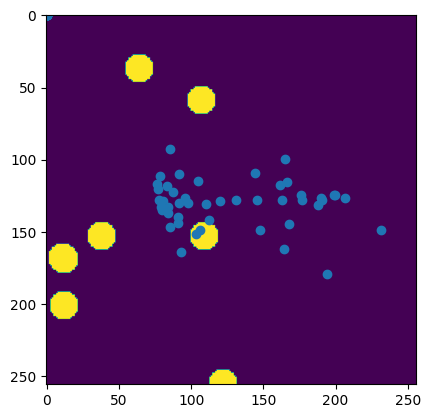

 64%|██████▍   | 103/160 [14:14<10:20, 10.88s/it]

Run 103, optimisation toward goal: 
TARGET =tensor([ 0.0626,  0.0251, -0.2669])
reached= tensor([0.0830, 0.0561, 0.1465], device='cpu')


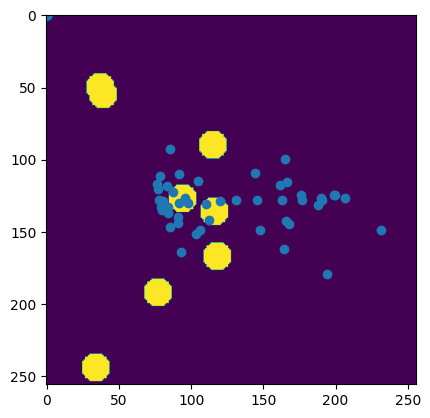

 65%|██████▌   | 104/160 [14:19<08:39,  9.27s/it]

Run 104, optimisation toward goal: 
TARGET =tensor([ 0.0685, -0.2258, -0.1817])
reached= tensor([10.,  0.,  0.], device='cpu')


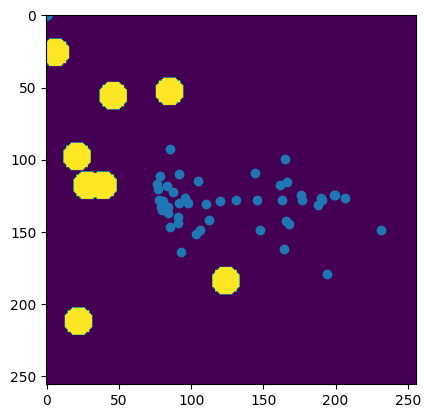

 66%|██████▌   | 105/160 [14:20<06:11,  6.76s/it]

Run 105, optimisation toward goal: 
TARGET =tensor([ 0.0621,  0.1427, -0.1090])
reached= tensor([ 0.0705,  0.1174, -0.0592], device='cpu')


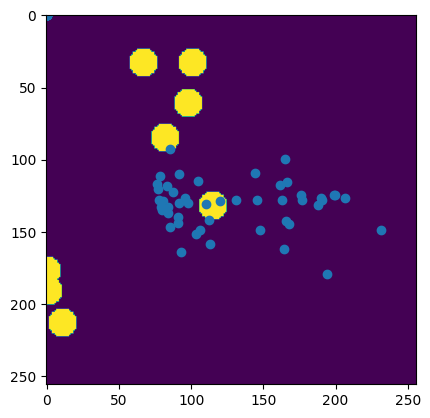

 66%|██████▋   | 106/160 [14:56<13:52, 15.41s/it]

Run 106, optimisation toward goal: 
TARGET =tensor([ 0.0674,  0.0508, -0.2819])
reached= tensor([ 0.0763, -0.0395, -0.1240], device='cpu')


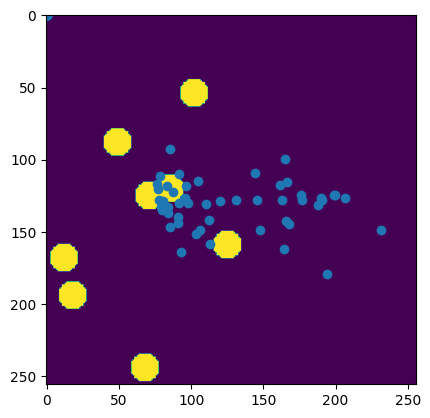

 67%|██████▋   | 107/160 [15:01<10:58, 12.43s/it]

Run 107, optimisation toward goal: 
TARGET =tensor([ 0.0643,  0.1286, -0.2330])
reached= tensor([0.0790, 0.0628, 0.1527], device='cpu')


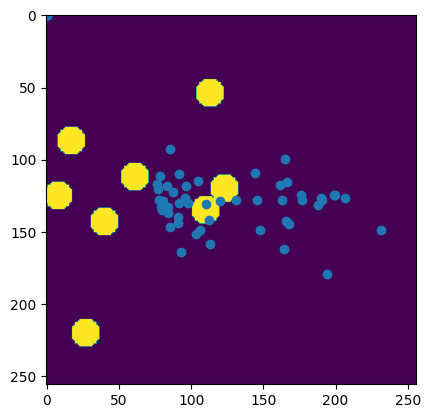

 68%|██████▊   | 108/160 [15:07<09:04, 10.48s/it]

Run 108, optimisation toward goal: 
TARGET =tensor([ 0.0673, -0.2160, -0.1746])
reached= tensor([ 0.0770, -0.2122, -0.1066], device='cpu')


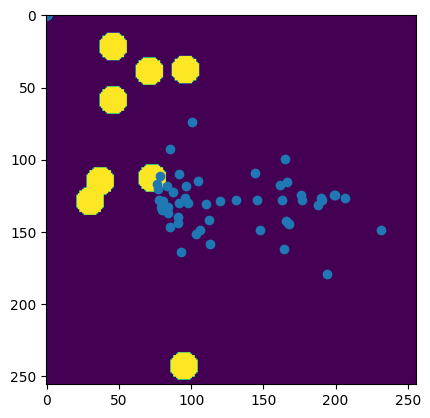

 68%|██████▊   | 109/160 [15:13<07:38,  8.98s/it]

Run 109, optimisation toward goal: 
TARGET =tensor([ 0.0650, -0.1681, -0.2045])
reached= tensor([ 0.0779, -0.1682, -0.1061], device='cpu')


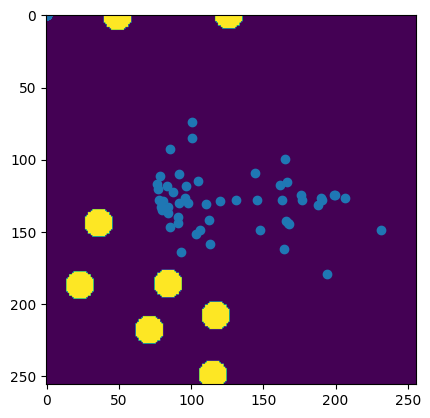

 69%|██████▉   | 110/160 [15:19<06:44,  8.09s/it]

Run 110, optimisation toward goal: 
TARGET =tensor([ 0.0638, -0.0114, -0.2748])
reached= tensor([ 0.0729, -0.0274, -0.1856], device='cpu')


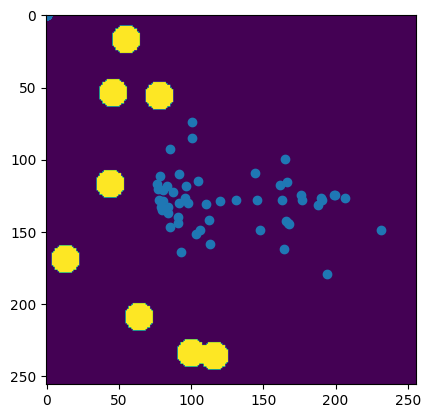

 69%|██████▉   | 111/160 [15:54<13:18, 16.29s/it]

Run 111, optimisation toward goal: 
TARGET =tensor([ 0.0620,  0.1805, -0.2002])
reached= tensor([ 0.0721,  0.1590, -0.1346], device='cpu')


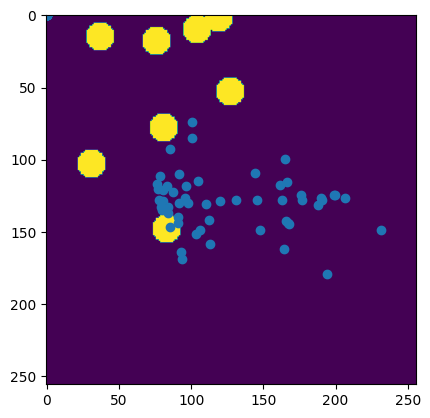

 70%|███████   | 112/160 [16:00<10:29, 13.12s/it]

Run 112, optimisation toward goal: 
TARGET =tensor([ 0.0668, -0.0261, -0.3001])
reached= tensor([10.,  0.,  0.], device='cpu')


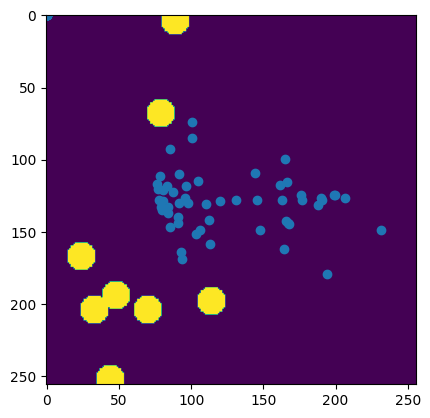

 71%|███████   | 113/160 [16:01<07:24,  9.45s/it]

Run 113, optimisation toward goal: 
TARGET =tensor([ 0.0644, -0.0341, -0.2473])
reached= tensor([ 0.2252, -0.0009, -0.0161], device='cpu')


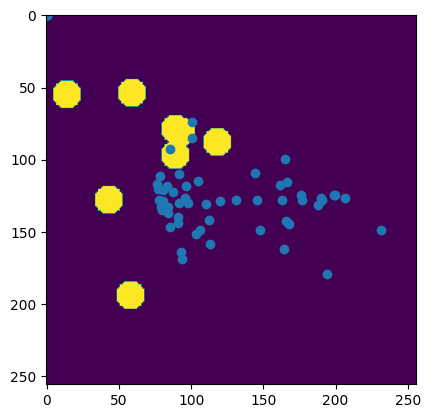

 71%|███████▏  | 114/160 [16:07<06:22,  8.31s/it]

Run 114, optimisation toward goal: 
TARGET =tensor([ 0.0666,  0.1510, -0.2049])
reached= tensor([0.0780, 0.1306, 0.2803], device='cpu')


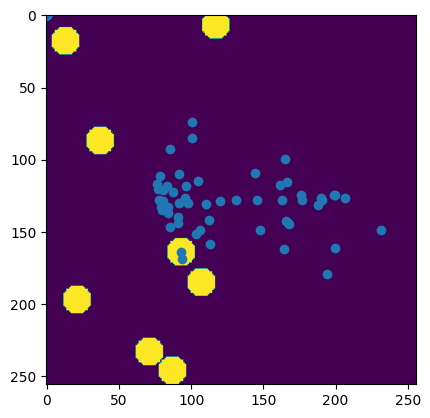

 72%|███████▏  | 115/160 [16:12<05:40,  7.57s/it]

Run 115, optimisation toward goal: 
TARGET =tensor([ 0.0613, -0.1925, -0.1784])
reached= tensor([ 0.0785, -0.3101,  0.1468], device='cpu')


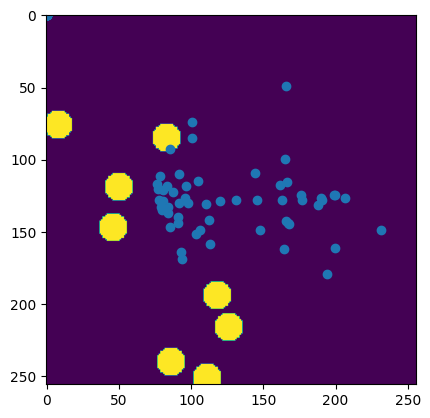

 72%|███████▎  | 116/160 [16:48<11:43, 15.99s/it]

Run 116, optimisation toward goal: 
TARGET =tensor([ 0.0665, -0.1125, -0.2551])
reached= tensor([ 0.0741, -0.1029, -0.2175], device='cpu')


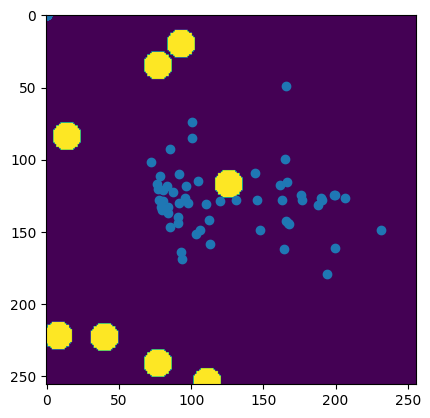

 73%|███████▎  | 117/160 [16:54<09:14, 12.90s/it]

Run 117, optimisation toward goal: 
TARGET =tensor([ 0.0667, -0.1904, -0.2214])
reached= tensor([ 0.0745, -0.1393, -0.1726], device='cpu')


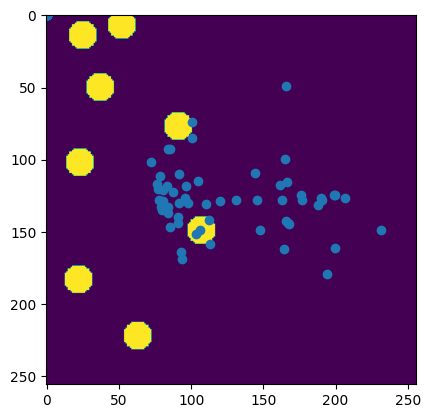

 74%|███████▍  | 118/160 [17:00<07:33, 10.79s/it]

Run 118, optimisation toward goal: 
TARGET =tensor([ 0.0634, -0.1323, -0.2666])
reached= tensor([10.,  0.,  0.], device='cpu')


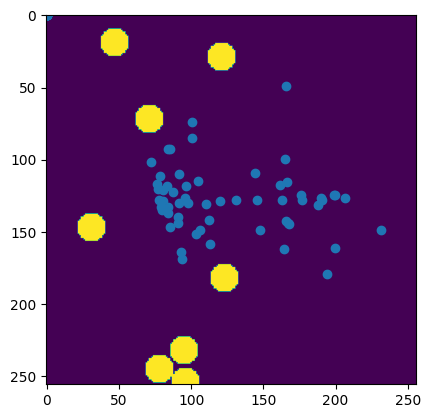

 74%|███████▍  | 119/160 [17:02<05:34,  8.16s/it]

Run 119, optimisation toward goal: 
TARGET =tensor([ 0.0676, -0.1087, -0.2665])
reached= tensor([ 0.0755, -0.0964, -0.1742], device='cpu')


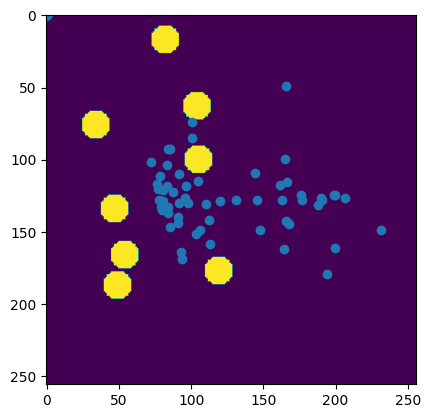

 75%|███████▌  | 120/160 [17:07<04:54,  7.37s/it]

Run 120, optimisation toward goal: 
TARGET =tensor([ 0.0623, -0.1133, -0.2740])
reached= tensor([ 0.0762, -0.0161,  0.2259], device='cpu')


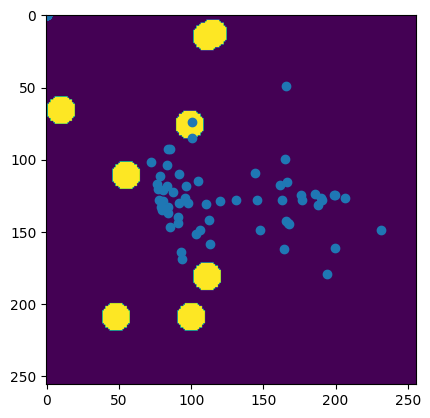

 76%|███████▌  | 121/160 [17:43<10:19, 15.88s/it]

Run 121, optimisation toward goal: 
TARGET =tensor([ 0.0649, -0.1233, -0.2388])
reached= tensor([10.,  0.,  0.], device='cpu')


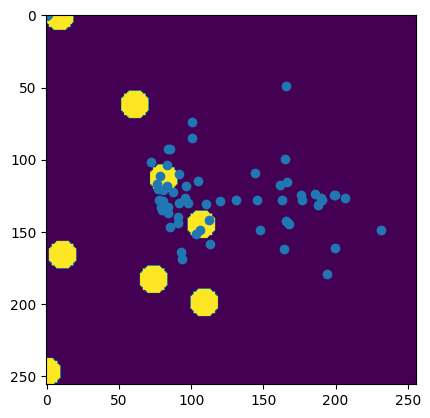

 76%|███████▋  | 122/160 [17:44<07:12, 11.39s/it]

Run 122, optimisation toward goal: 
TARGET =tensor([ 0.0625, -0.0758, -0.2565])
reached= tensor([ 0.0749, -0.0809, -0.2006], device='cpu')


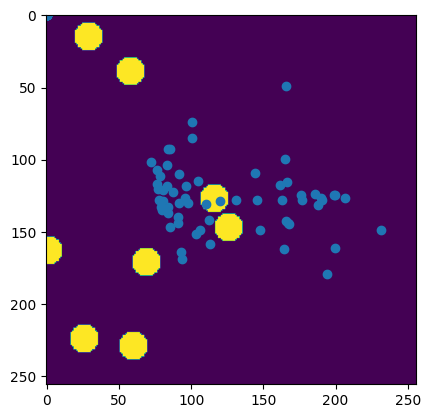

 77%|███████▋  | 123/160 [17:49<05:58,  9.68s/it]

Run 123, optimisation toward goal: 
TARGET =tensor([ 0.0668,  0.0305, -0.2654])
reached= tensor([ 0.0747,  0.0149, -0.1285], device='cpu')


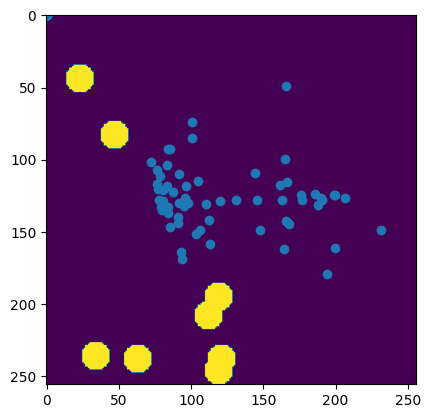

 78%|███████▊  | 124/160 [17:55<05:06,  8.52s/it]

Run 124, optimisation toward goal: 
TARGET =tensor([ 0.0638, -0.0706, -0.2621])
reached= tensor([ 0.2108, -0.0245,  0.1136], device='cpu')


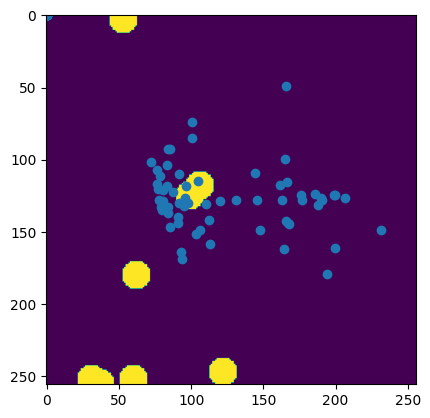

 78%|███████▊  | 125/160 [18:01<04:26,  7.62s/it]

Run 125, optimisation toward goal: 
TARGET =tensor([ 0.0639, -0.0803, -0.2596])
reached= tensor([ 0.0746, -0.0706, -0.2079], device='cpu')


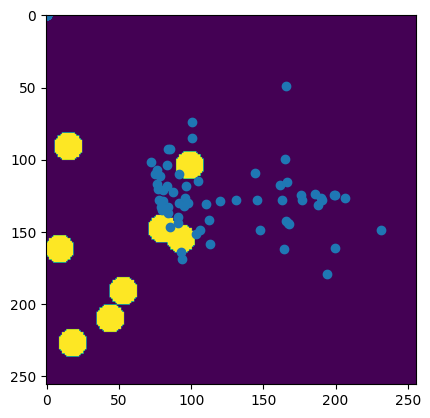

 79%|███████▉  | 126/160 [18:37<09:06, 16.07s/it]

Run 126, optimisation toward goal: 
TARGET =tensor([ 0.0629, -0.2269, -0.2020])
reached= tensor([10.,  0.,  0.], device='cpu')


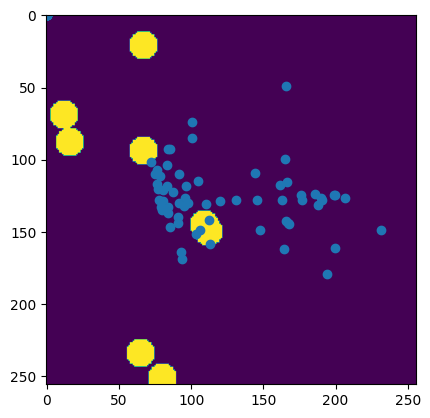

 79%|███████▉  | 127/160 [18:37<06:20, 11.52s/it]

Run 127, optimisation toward goal: 
TARGET =tensor([ 0.0646, -0.1432, -0.2700])
reached= tensor([ 0.0890, -0.0090,  0.2154], device='cpu')


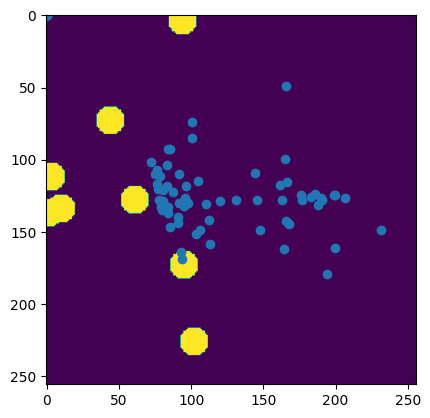

 80%|████████  | 128/160 [18:44<05:15,  9.87s/it]

Run 128, optimisation toward goal: 
TARGET =tensor([ 0.0645, -0.1576, -0.2991])
reached= tensor([10.,  0.,  0.], device='cpu')


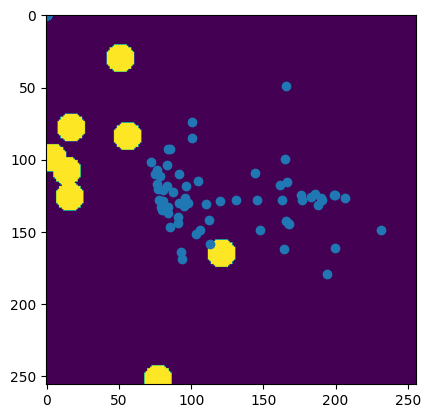

 81%|████████  | 129/160 [18:45<03:52,  7.50s/it]

Run 129, optimisation toward goal: 
TARGET =tensor([ 0.0639, -0.1840, -0.2584])
reached= tensor([ 0.1254, -0.0098,  0.2179], device='cpu')


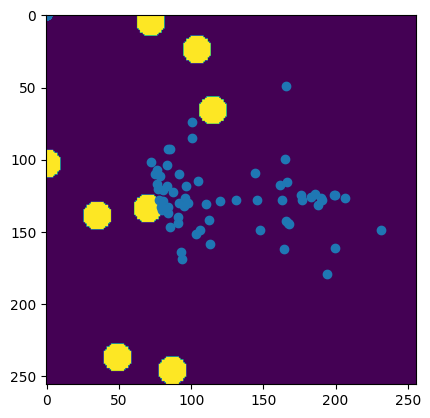

 81%|████████▏ | 130/160 [18:51<03:27,  6.90s/it]

Run 130, optimisation toward goal: 
TARGET =tensor([ 0.0653,  0.0393, -0.2707])
reached= tensor([0.0751, 0.0154, 0.1679], device='cpu')


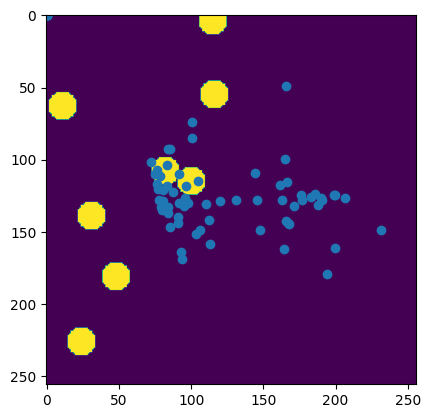

 82%|████████▏ | 131/160 [19:27<07:30, 15.52s/it]

Run 131, optimisation toward goal: 
TARGET =tensor([ 0.0667,  0.0946, -0.2140])
reached= tensor([10.,  0.,  0.], device='cpu')


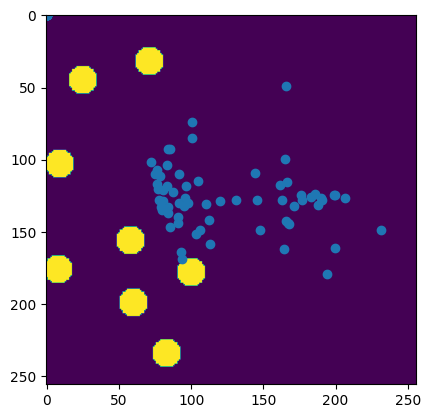

 82%|████████▎ | 132/160 [19:28<05:11, 11.13s/it]

Run 132, optimisation toward goal: 
TARGET =tensor([ 0.0635, -0.1576, -0.2905])
reached= tensor([ 0.0817, -0.0031,  0.2463], device='cpu')


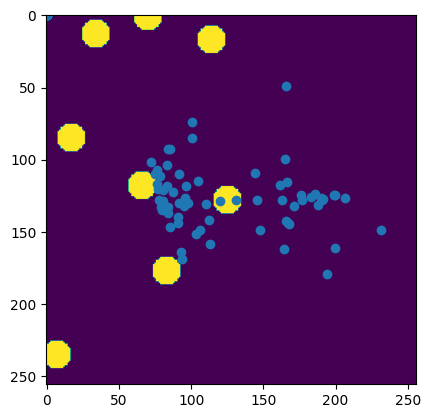

 83%|████████▎ | 133/160 [19:33<04:17,  9.52s/it]

Run 133, optimisation toward goal: 
TARGET =tensor([ 0.0678, -0.0842, -0.2775])
reached= tensor([ 0.0758, -0.0236, -0.1899], device='cpu')


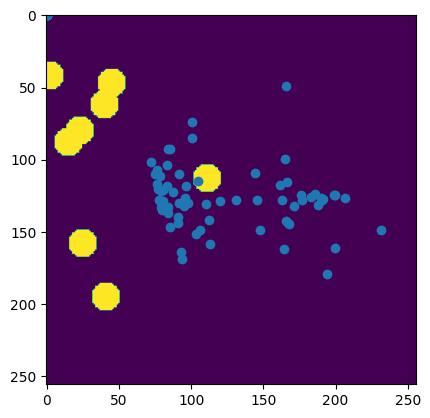

 84%|████████▍ | 134/160 [19:39<03:37,  8.35s/it]

Run 134, optimisation toward goal: 
TARGET =tensor([ 0.0666, -0.1159, -0.2685])
reached= tensor([ 0.0819, -0.0701,  0.0423], device='cpu')


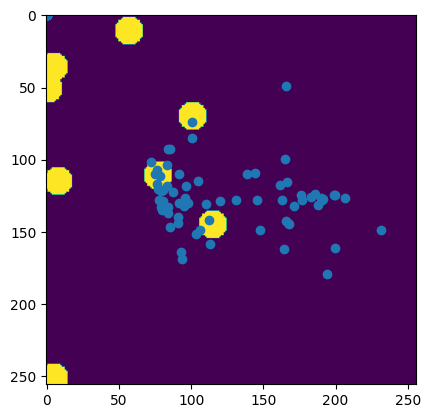

 84%|████████▍ | 135/160 [19:45<03:08,  7.54s/it]

Run 135, optimisation toward goal: 
TARGET =tensor([ 0.0623, -0.1118, -0.2901])
reached= tensor([ 0.0844, -0.1238,  0.2103], device='cpu')


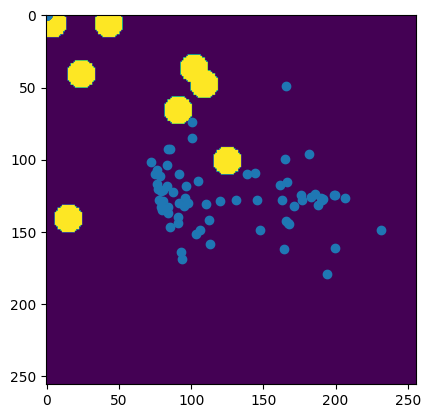

 85%|████████▌ | 136/160 [20:20<06:22, 15.94s/it]

Run 136, optimisation toward goal: 
TARGET =tensor([ 0.0657, -0.1755, -0.2281])
reached= tensor([10.,  0.,  0.], device='cpu')


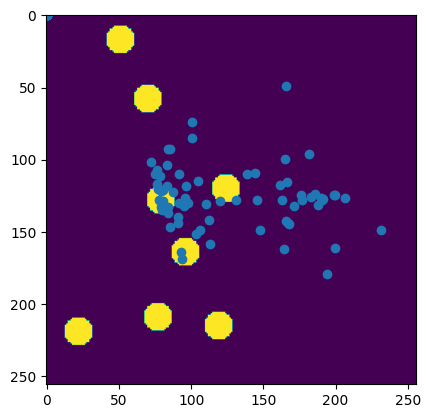

 86%|████████▌ | 137/160 [20:21<04:22, 11.42s/it]

Run 137, optimisation toward goal: 
TARGET =tensor([ 0.0662, -0.0784, -0.2698])
reached= tensor([10.,  0.,  0.], device='cpu')


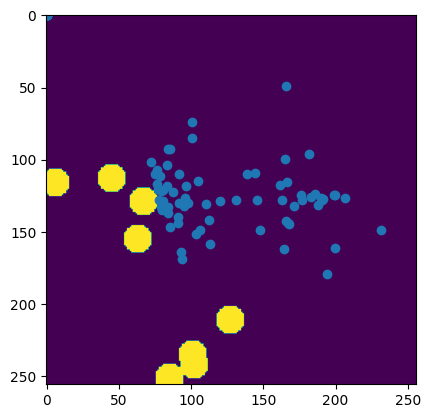

 86%|████████▋ | 138/160 [20:22<03:01,  8.27s/it]

Run 138, optimisation toward goal: 
TARGET =tensor([ 0.0638,  0.1141, -0.2442])
reached= tensor([ 0.0735,  0.0952, -0.1623], device='cpu')


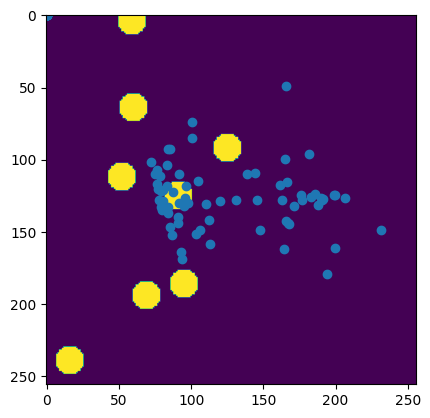

 87%|████████▋ | 139/160 [20:28<02:38,  7.54s/it]

Run 139, optimisation toward goal: 
TARGET =tensor([ 0.0657,  0.1330, -0.2481])
reached= tensor([ 0.0846, -0.0170,  0.1636], device='cpu')


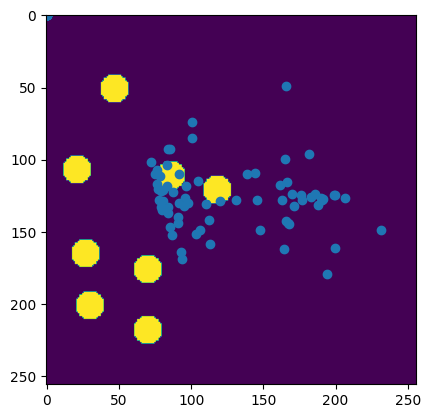

 88%|████████▊ | 140/160 [20:33<02:18,  6.92s/it]

Run 140, optimisation toward goal: 
TARGET =tensor([ 0.0666, -0.1287, -0.0232])
reached= tensor([ 0.0759, -0.1233, -0.0106], device='cpu')


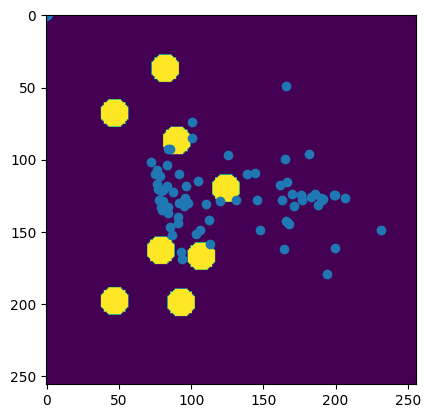

 88%|████████▊ | 141/160 [21:09<04:54, 15.50s/it]

Run 141, optimisation toward goal: 
TARGET =tensor([ 0.0628, -0.0487, -0.2788])
reached= tensor([10.,  0.,  0.], device='cpu')


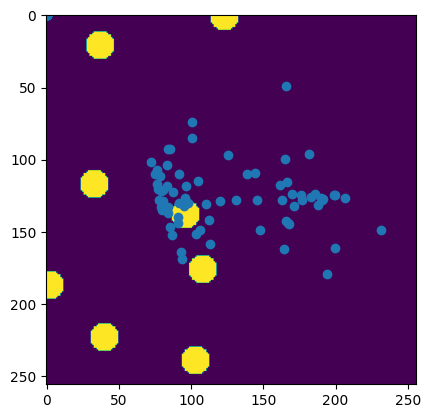

 89%|████████▉ | 142/160 [21:10<03:20, 11.12s/it]

Run 142, optimisation toward goal: 
TARGET =tensor([ 0.0664,  0.1975, -0.2103])
reached= tensor([ 0.0959, -0.0014,  0.2455], device='cpu')


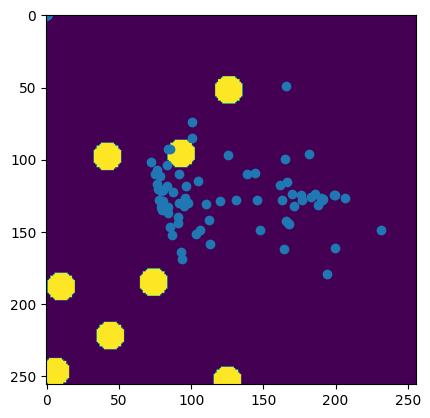

 89%|████████▉ | 143/160 [21:15<02:41,  9.48s/it]

Run 143, optimisation toward goal: 
TARGET =tensor([ 0.0651,  0.0103, -0.2661])
reached= tensor([10.,  0.,  0.], device='cpu')


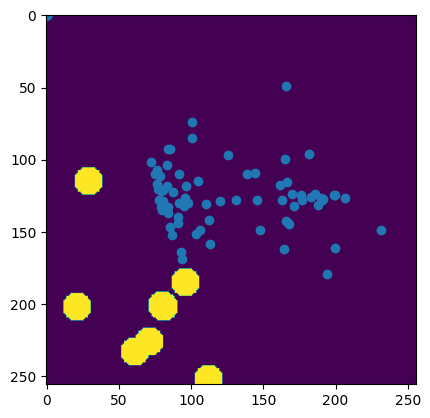

 90%|█████████ | 144/160 [21:16<01:51,  6.99s/it]

Run 144, optimisation toward goal: 
TARGET =tensor([ 0.0671,  0.0552, -0.2311])
reached= tensor([0.0836, 0.0039, 0.2358], device='cpu')


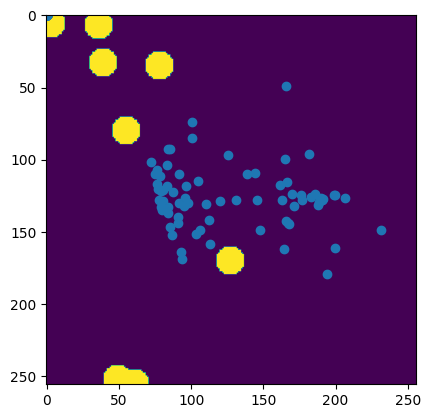

 91%|█████████ | 145/160 [21:22<01:38,  6.55s/it]

Run 145, optimisation toward goal: 
TARGET =tensor([ 0.0659, -0.1744, -0.2579])
reached= tensor([ 0.0799, -0.1265,  0.0491], device='cpu')


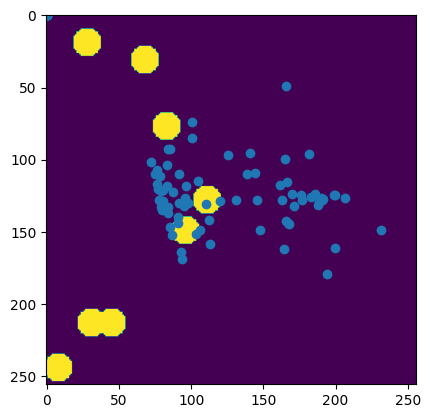

 91%|█████████▏| 146/160 [21:58<03:33, 15.28s/it]

Run 146, optimisation toward goal: 
TARGET =tensor([ 0.0629, -0.1321, -0.2956])
reached= tensor([ 0.1289, -0.0100,  0.2449], device='cpu')


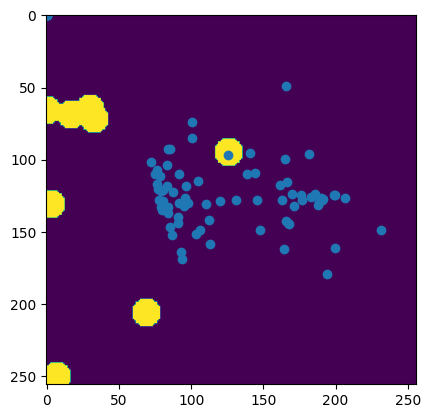

 92%|█████████▏| 147/160 [22:03<02:40, 12.34s/it]

Run 147, optimisation toward goal: 
TARGET =tensor([ 0.0634,  0.1377, -0.1994])
reached= tensor([ 0.0750,  0.1285, -0.1312], device='cpu')


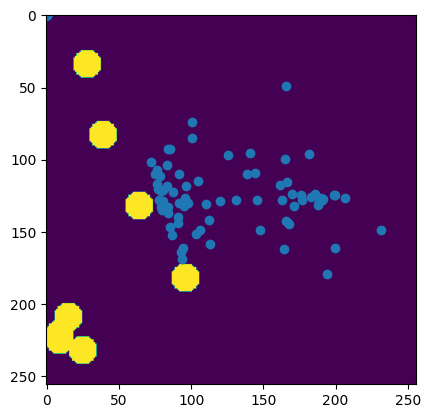

 92%|█████████▎| 148/160 [22:09<02:04, 10.40s/it]

Run 148, optimisation toward goal: 
TARGET =tensor([ 0.0655, -0.1766, -0.2224])
reached= tensor([10.,  0.,  0.], device='cpu')


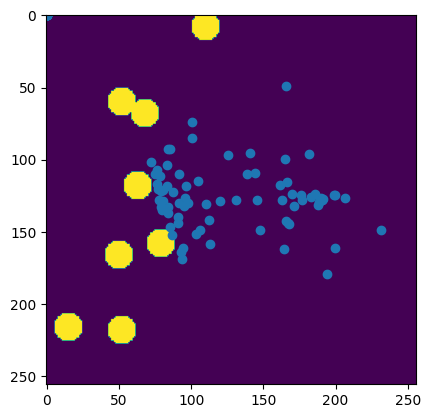

 93%|█████████▎| 149/160 [22:10<01:23,  7.55s/it]

Run 149, optimisation toward goal: 
TARGET =tensor([ 0.0619, -0.1393, -0.2756])
reached= tensor([ 0.2257, -0.0038,  0.0018], device='cpu')


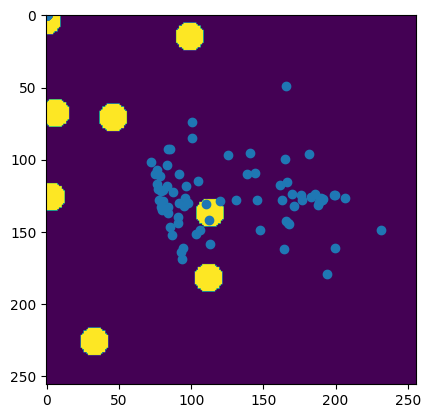

 94%|█████████▍| 150/160 [22:15<01:09,  6.94s/it]

Run 150, optimisation toward goal: 
TARGET =tensor([ 0.0662, -0.0979, -0.2624])
reached= tensor([ 0.0734, -0.0564, -0.1888], device='cpu')


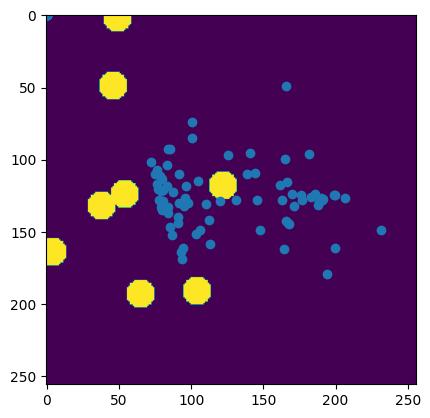

 94%|█████████▍| 151/160 [22:51<02:19, 15.50s/it]

Run 151, optimisation toward goal: 
TARGET =tensor([ 0.0673,  0.1268, -0.2392])
reached= tensor([10.,  0.,  0.], device='cpu')


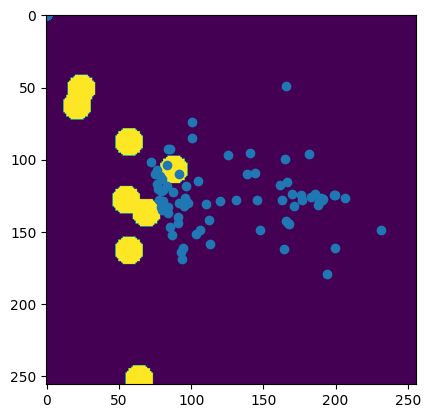

 95%|█████████▌| 152/160 [22:52<01:28, 11.12s/it]

Run 152, optimisation toward goal: 
TARGET =tensor([ 0.0658, -0.1462, -0.2556])
reached= tensor([ 0.2047, -0.0367,  0.1464], device='cpu')


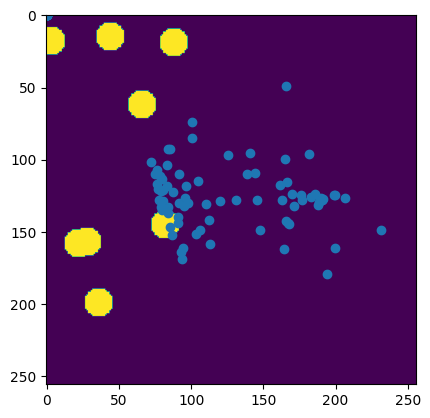

 96%|█████████▌| 153/160 [22:57<01:06,  9.50s/it]

Run 153, optimisation toward goal: 
TARGET =tensor([ 0.0622, -0.1359, -0.0686])
reached= tensor([10.,  0.,  0.], device='cpu')


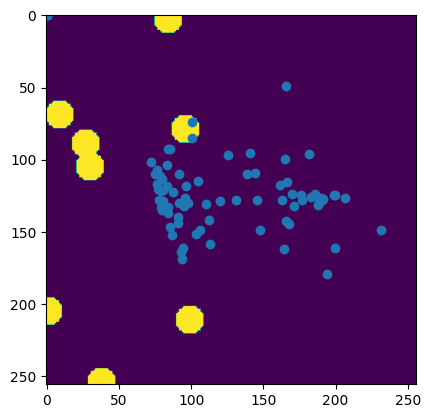

 96%|█████████▋| 154/160 [22:59<00:41,  7.00s/it]

Run 154, optimisation toward goal: 
TARGET =tensor([ 0.0657, -0.2018, -0.1710])
reached= tensor([10.,  0.,  0.], device='cpu')


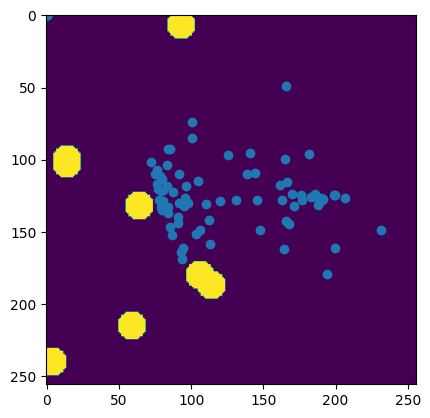

 97%|█████████▋| 155/160 [23:00<00:27,  5.43s/it]

Run 155, optimisation toward goal: 
TARGET =tensor([ 0.0645, -0.1104, -0.3081])
reached= tensor([ 0.2121, -0.0794,  0.1498], device='cpu')


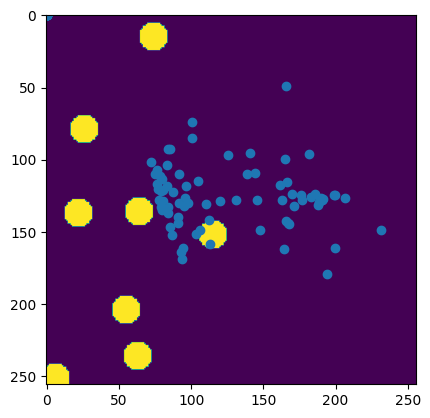

 98%|█████████▊| 156/160 [23:36<00:57, 14.37s/it]

Run 156, optimisation toward goal: 
TARGET =tensor([ 0.0660,  0.1934, -0.1698])
reached= tensor([10.,  0.,  0.], device='cpu')


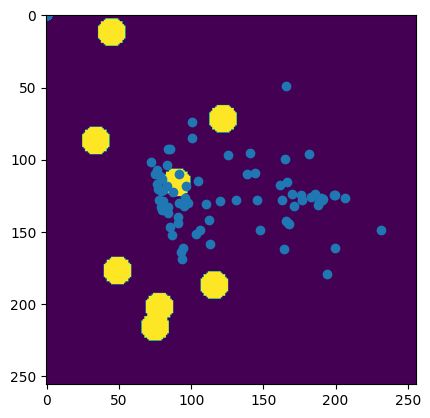

 98%|█████████▊| 157/160 [23:37<00:31, 10.38s/it]

Run 157, optimisation toward goal: 
TARGET =tensor([ 0.0651, -0.0855, -0.2964])
reached= tensor([ 0.0882, -0.0814, -0.0557], device='cpu')


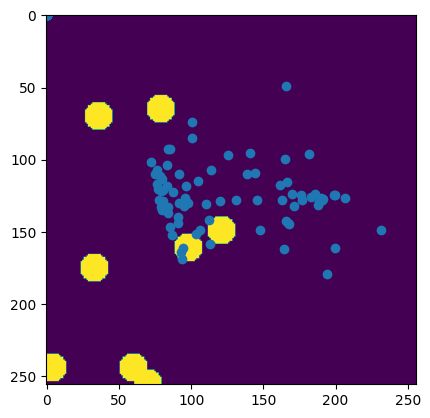

 99%|█████████▉| 158/160 [23:42<00:17,  8.97s/it]

Run 158, optimisation toward goal: 
TARGET =tensor([ 0.0643, -0.1417, -0.2726])
reached= tensor([ 0.0763, -0.1237, -0.2227], device='cpu')


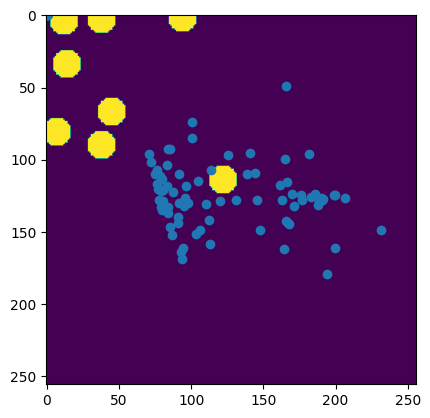

 99%|█████████▉| 159/160 [23:48<00:07,  7.94s/it]

Run 159, optimisation toward goal: 
TARGET =tensor([ 0.0660,  0.1214, -0.2201])
reached= tensor([8.7159e-02, 1.9227e-04, 2.4386e-01], device='cpu')


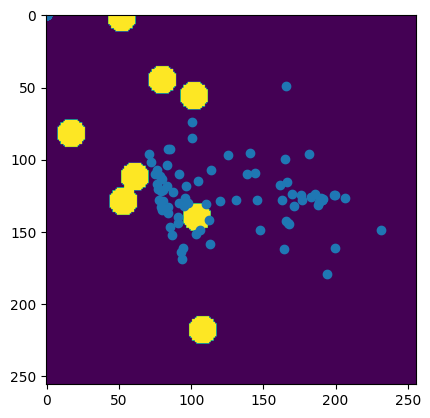

100%|██████████| 160/160 [23:54<00:00,  8.96s/it]

best achiever is run : tensor(158)
goal achieved by the best achiever :tensor([ 0.0763, -0.1237, -0.2227])


In [ ]:
# Load System: here lenia
lenia_config = Lenia_C.default_config()
lenia_config.SX = 256
lenia_config.SY = 256
lenia_config.final_step = 50
lenia_config.version = 'pytorch_fft'
lenia_config.nb_kernels=10

initialization_space_config = Dict()
initialization_space = LeniaInitializationSpace(config=initialization_space_config)

system = Lenia_C(initialization_space=initialization_space, config=lenia_config, device='cuda')

# Load ExplorationDB
db_config = ExplorationDB.default_config()
db_config.db_directory = '.'
db_config.save_observations = False
db_config.keep_saved_runs_in_memory=False
db_config.load_observations = True
exploration_db = ExplorationDB(config=db_config)

# Load Imgep Explorer


output_representation_config = LeniaCentroidRepresentation.default_config()
output_representation_config.env_size = (system.config.SX, system.config.SY)
output_representation = LeniaCentroidRepresentation(config=output_representation_config)
goal_space = BoxGoalSpace(output_representation)

## Load Goal Space Representation

# goal_space = BoxGoalSpace(output_representation,low=torch.tensor([0,-0.5,-0.5]),high=torch.tensor([2,0.5,0.5]),autoexpand=False)

## Load imgep explorer
explorer_config = IMGEPExplorer.default_config()
explorer_config.num_of_random_initialization = 40
explorer_config.reach_goal_optimizer = Dict()
explorer_config.reach_goal_optimizer.optim_steps = 125
explorer_config.reach_goal_optimizer.name = "Adam"
explorer_config.reach_goal_optimizer.initialization_cppn.parameters.lr = 0.8e-2
explorer_config.reach_goal_optimizer.lenia_step.parameters.lr = 0.8e-3
explorer = IMGEPExplorer(system, exploration_db, goal_space, config=explorer_config)


# Run Imgep Explorer
explorer.run(160)

# # save
# explorer.save('explorer.pickle')
#
#restart from checkpoint
# explorer = IMGEPExplorer.load('explorer.pickle', load_data=False, map_location='cpu')
# explorer.db = ExplorationDB(config=db_config)
# explorer.db.load(map_location='cpu')
# explorer.run(20, continue_existing_run=True)


goal_lib_copy=explorer.goal_library*1.0
goal_lib_copy[:,2]=goal_lib_copy[:,2]+1000*(goal_lib_copy[:,1]<-8)+1000*(goal_lib_copy[:,0]>0.12)
best_achiever=torch.argmin(goal_lib_copy[:,2])
print("best achiever is run : "+str(best_achiever))
print("goal achieved by the best achiever :" +str(explorer.goal_library[best_achiever]))

## Try the best creature you obtained during the method

{'R': tensor(24), 'c0': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'c1': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'T': tensor(5.5907), 'rk': tensor([[0.1890, 0.2070, 0.2660],
        [0.0640, 0.7530, 0.2540],
        [0.5550, 0.2470, 0.5690],
        [0.6310, 0.2940, 0.9370],
        [0.0850, 0.9260, 0.0990],
        [0.5740, 0.3370, 0.1410],
        [0.4430, 0.6850, 0.4910],
        [0.0000, 0.0210, 0.2600],
        [0.6560, 0.2430, 0.8160],
        [0.2010, 0.7830, 0.0010]]), 'b': tensor([[0.8450, 0.0400, 0.7200],
        [0.7800, 0.6650, 0.4850],
        [0.3150, 0.8750, 0.2000],
        [0.4650, 0.5450, 0.5000],
        [0.8100, 0.1800, 0.0150],
        [0.5500, 0.3450, 0.6550],
        [0.0000, 0.4750, 0.7150],
        [0.9400, 0.0250, 0.0450],
        [0.4200, 0.9950, 0.3100],
        [0.5500, 1.0000, 0.0500]]), 'w': tensor([[0.4920, 0.2210, 0.1480],
        [0.1190, 0.5000, 0.0240],
        [0.1000, 0.3060, 0.1310],
        [0.0410, 0.4930, 0.1270],
        [0.0710, 0.0940, 0.2450],

  cmap = cm.get_cmap('magma')



10500,0.058,0.498,0.137,0.481,0.189,0.207,0.266,0.492,0.221,0.148,0.845,0.04,0.72,0.357,0.103,0.0585,0.941,0.064,0.753,0.254,0.119,0.5,0.024,0.78,0.665,0.485,0.254,0.268,0.08,0.725,0.555,0.247,0.569,0.1,0.306,0.131,0.315,0.875,0.2,0.051,0.05,0.003,1.0,0.631,0.294,0.937,0.041,0.493,0.127,0.465,0.545,0.5,0.379,0.059,0.0845,0.9,0.085,0.926,0.099,0.071,0.094,0.245,0.81,0.18,0.015,0.094,0.051,0.047,0.558,0.574,0.337,0.141,0.144,0.101,0.418,0.55,0.345,0.655,0.247,0.373,0.165,0.609,0.443,0.685,0.491,0.325,0.223,0.222,0.0,0.475,0.715,0.008,0.46,0.046,0.597,0.0,0.021,0.26,0.293,0.036,0.178,0.94,0.025,0.045,0.139,0.336,0.08,0.5,0.656,0.243,0.816,0.396,0.079,0.392,0.42,0.995,0.31,0.407,0.135,0.01,0.78,0.201,0.783,0.001,0.013,0.207,0.114,0.55,1.0,0.05,
computation of lenia took 1.4043583869934082
you can draw on the canvas or click on circle to go to circle mode
click on video once you re done

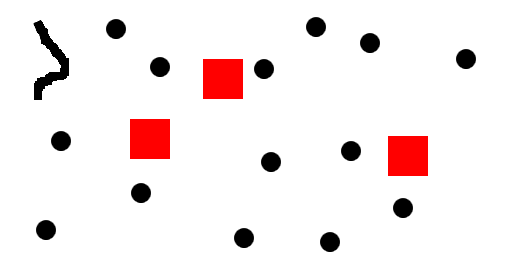


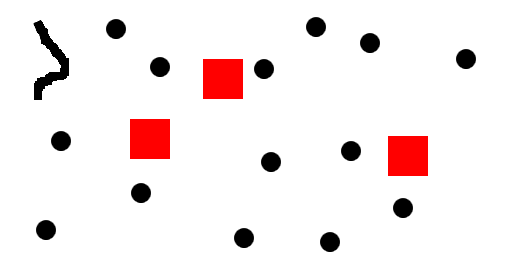

In [ ]:

SY =  512#@param {type:"integer"}
SX =  256#@param {type:"integer"}
# timesteps =  200#@param {type:"integer"}
mode = "draw" #@param ["draw", "random"]
modeb = "none" #@param ["growth", "sum", "none", "both"]
borders = False #@param {type:"boolean"}
nb=best_achiever.cpu().numpy()
if(nb<10):
  creaFile=("run_000000"+str(nb)+"_data.pickle")
elif(nb<100):
  creaFile=("run_00000"+str(nb)+"_data.pickle")
elif(nb<1000):
  creaFile=("run_0000"+str(nb)+"_data.pickle")
else:
  creaFile=("run_000"+str(nb)+"_data.pickle")

main(SX,SY,mode,borders,[0,1,2,3,4,5,6,7,8,9],creaFile=creaFile,modeb=modeb,zoom=1)

## save all

Run this if you want to save every creature obtained during the training (at every IMGEP outer loop step). Then you just need to download data.zip.



In [ ]:
print("best achiever is IMGEP step" + str(best_achiever))

best achiever is IMGEP steptensor(149)


In [ ]:
!rm -r data

rm: cannot remove 'data': No such file or directory


In [ ]:
!mkdir data

In [ ]:
!mv run_*_data.pickle data

In [ ]:
!zip data.zip data/*

  adding: data/run_0000000_data.pickle (deflated 31%)
  adding: data/run_0000001_data.pickle (deflated 30%)
  adding: data/run_0000002_data.pickle (deflated 31%)
  adding: data/run_0000003_data.pickle (deflated 31%)
  adding: data/run_0000004_data.pickle (deflated 31%)
  adding: data/run_0000005_data.pickle (deflated 31%)
  adding: data/run_0000006_data.pickle (deflated 31%)
  adding: data/run_0000007_data.pickle (deflated 31%)
  adding: data/run_0000008_data.pickle (deflated 31%)
  adding: data/run_0000009_data.pickle (deflated 31%)
  adding: data/run_0000010_data.pickle (deflated 31%)
  adding: data/run_0000011_data.pickle (deflated 31%)
  adding: data/run_0000012_data.pickle (deflated 31%)
  adding: data/run_0000013_data.pickle (deflated 31%)
  adding: data/run_0000014_data.pickle (deflated 30%)
  adding: data/run_0000015_data.pickle (deflated 31%)
  adding: data/run_0000016_data.pickle (deflated 30%)
  adding: data/run_0000017_data.pickle (deflated 31%)
  adding: data/run_0000018_d

# Gecko experiment (display of differentiable lenia)

 Experiment and code for image import  from https://distill.pub/2020/growing-ca/ . In our case we'll only try to converge towards a black and white gecko. And we'll also optimize the initialization.

 It can be hard to converge toward the gecko shape with a single channel (but single channel is very fast). And as the initialization matters a lot you may have to run several seed until you get a nice convergence. (With a single channel the shape will be only vaguely a gecko)

https://raw.githubusercontent.com/googlefonts/noto-emoji/main/png/128/emoji_u1f98e.png


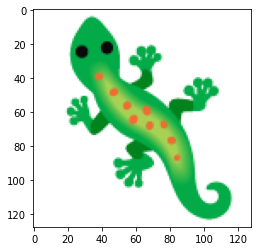

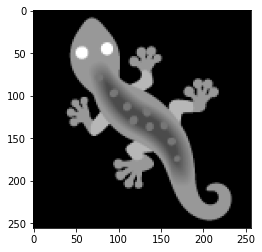

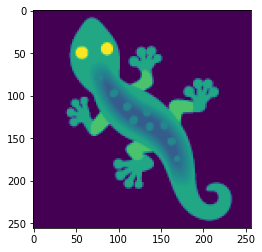

In [ ]:
#code from code for image import  from https://distill.pub/2020/growing-ca/

import json
import requests
import PIL.Image, PIL.ImageDraw
import io
import matplotlib.cm as cm

TARGET_EMOJI = "🦎" #@param {type:"string"}



from tensorflow.keras.layers import Conv2D

def load_image(url, max_size=256):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0
  # premultiply RGB by Alpha
  img[..., :3] *= img[..., 3:]
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://raw.githubusercontent.com/googlefonts/noto-emoji/main/png/128/emoji_u%s.png'%code
  print(url)
  return load_image(url)

target_img = load_emoji(TARGET_EMOJI)
def to_alpha(x):
  return np.clip(x[..., 3:4], 0.0, 1.0)
def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, a = x[..., :3], to_alpha(x)
  return 1.0-a+rgb
def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

plt.imshow(to_rgb(target_img))
plt.show()
gray_target_img=np.dot(zoom(to_rgb(target_img),2), [0.2989, 0.5870, 0.1140])
plt.imshow(1-gray_target_img,cmap='gray')
plt.show()

# cmap = cm.get_cmap('rainbow')
# plt.imshow(cmap(1-gray_target_img))
# plt.show()

target_img=torch.tensor(1-gray_target_img)
plt.imshow(target_img.cpu()[:,:])
plt.show()

tensor(0.)
tensor(0.)
tensor(2941.0903)


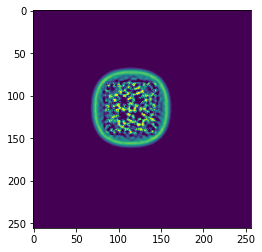

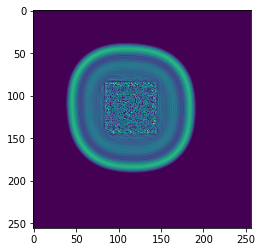

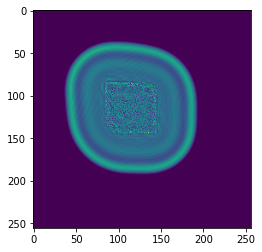

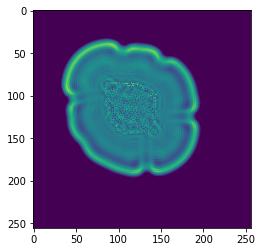

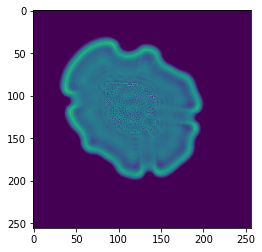

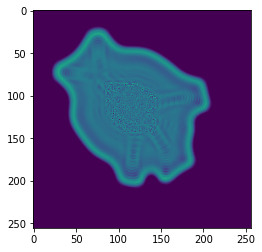

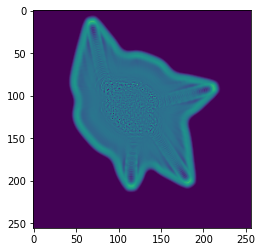

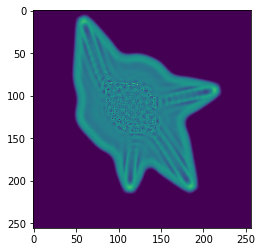

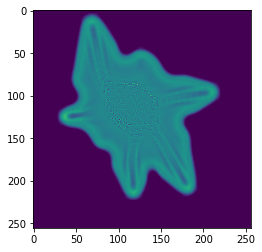

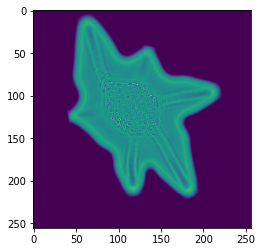

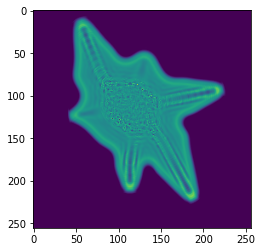

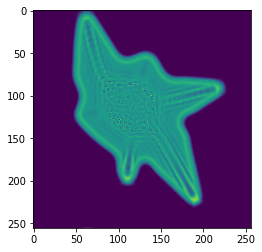

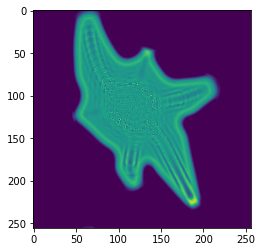

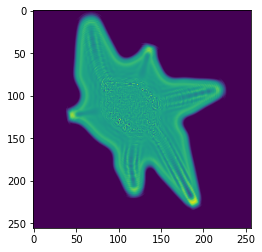

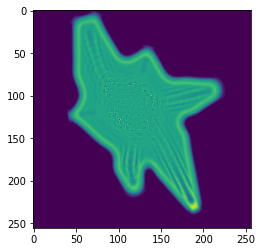

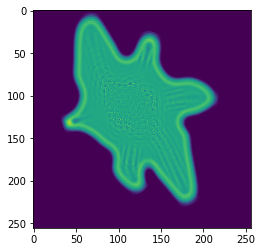

In [ ]:
from torch.optim import Adam

C=1
system=Lenia_C(nb_k=40,init_size=60,C=C,device='cuda')
system.final_step=50
system.generate_init_state()


#loop to sample new parameters until we get rules which do not kill the creature
with torch.no_grad():
  dead=True
  while dead:
    system.reset()
    observations=system.run()
    dead=(observations.states[-1,:,:,0].sum()<400)
    print(observations.states[-1,:,:,0].sum())
  system.update_update_rule_parameters()
  torch.save(system.update_rule_parameters, 'init.pickle')


# optimizer=Adam(system.lenia_step.parameters(),lr=1e-3)
optimizer=Adam([{'params': system.initialization.parameters(),"lr":8e-3},{'params': system.lenia_step.parameters(),'lr':1e-3}],lr=2e-3)
loss_list=[]


for training_step in range(601):
          system.generate_init_state(X=85,Y=85)
          observations = system.run()
          if(observations.states[-1,:,:,0].sum()<300):
            print("died")
            break
          loss= (target_img[:,:]-observations.states[-1,:,:,0]).pow(2).sum().sqrt()
          if training_step%40==0:
            plt.imshow(observations.states[-1,:,:,0].detach().cpu().numpy())
            plt.show()
            with VideoWriter("out.mp4", 30.0) as vid:
                for timestep in range(observations["states"].shape[0]):


                  rgb_im=torch.clip(target_img[:,:]+observations.states[timestep,:,:,0],0,1).detach().cpu().numpy()

                  vid.add(rgb_im)
                vid.show()
                  # print(system.lenia_step.h)

          loss_list.append(loss.detach().cpu())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          old_loss = loss.item()
          system.lenia_step.compute_kernel()




